In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('environment_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data['CO2'] = data['CO2'].interpolate(method='linear')
data = data.groupby(level=0).mean() 
data = data[~data.index.duplicated()]
data = data.resample('S').asfreq().interpolate(method='linear')
attributes_empirical = ['temp', 'humidity', 'voc', 'CO2']
attributes_iqr = ['pm1.0', 'pm2.5', 'pm10', 'pressure', 'sound']

for feature in attributes_empirical:
    mean = np.mean(data[feature])
    std_dev = np.std(data[feature])
    outliers_array = data[np.abs(data[feature] - mean) > 3 * std_dev].index
    if len(outliers_array) > 0:
        data.loc[outliers_array, feature] = np.nan
        data[feature] = data[feature].interpolate(method='linear')

for feature in attributes_iqr:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    upper_array = data[data[feature] >= upper].index
    lower_array = data[data[feature] <= lower].index

    if len(upper_array) > 0 or len(lower_array) > 0:        
        data.loc[upper_array, feature] = np.nan
        data.loc[lower_array, feature] = np.nan
        data[feature] = data[feature].interpolate(method='linear')

data_resample_30s = data.resample('30S').asfreq().interpolate(method='linear').dropna()

### Prvi korak

In [3]:
data = pd.read_csv('environment_data.csv', index_col=0)

In [4]:
data.index = pd.to_datetime(data.index)

In [5]:
data.info() # 345151, sto ne odgovara broju sekundi za 4 dana

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345151 entries, 2022-11-07 00:00:01 to 2022-11-10 23:59:59
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sound     345151 non-null  float64
 1   pressure  345151 non-null  float64
 2   temp      345151 non-null  float64
 3   humidity  345151 non-null  float64
 4   voc       345151 non-null  float64
 5   pm1.0     345151 non-null  float64
 6   pm2.5     345151 non-null  float64
 7   pm10      345151 non-null  float64
 8   CO2       344264 non-null  float64
dtypes: float64(9)
memory usage: 26.3 MB


In [6]:
data.head()

sound     pressure       temp   humidity      voc  \
timestamp                                                                   
2022-11-07 00:00:01  0.881076  1012.037290  24.777757  35.996349  29466.0   
2022-11-07 00:00:02  0.863325  1012.025698  24.762371  36.002125  29467.0   
2022-11-07 00:00:03  0.908509  1012.083523  24.767500  36.013384  29459.0   
2022-11-07 00:00:04  0.924645  1012.091207  24.767500  36.013384  29454.0   
2022-11-07 00:00:05  0.896406  1012.091207  24.764935  36.013405  29458.5   

                     pm1.0  pm2.5  pm10    CO2  
timestamp                                       
2022-11-07 00:00:01   26.0   36.0  45.0  421.0  
2022-11-07 00:00:02   26.0   36.0  45.0  419.0  
2022-11-07 00:00:03   26.0   36.0  45.0  418.0  
2022-11-07 00:00:04   26.0   36.0  44.0  418.0  
2022-11-07 00:00:05   26.0   36.0  44.0  416.0

In [7]:
data.describe()

sound       pressure           temp       humidity  \
count  345151.000000  345151.000000  345151.000000  345151.000000   
mean        1.035109    1014.807431      25.123033      34.636160   
std         0.493434       2.517912       1.210600       2.652997   
min         0.000000    1005.339453      20.326285      26.962989   
25%         0.931100    1013.215952      24.470044      32.984199   
50%         1.035990    1014.020586      24.972642      34.628268   
75%         1.229633    1015.415069      25.782958      36.830740   
max         3.303227    1024.071917      28.293446      41.651724   

                 voc          pm1.0          pm2.5           pm10  \
count  345151.000000  345151.000000  345151.000000  345151.000000   
mean    30512.354483      49.980410      68.674444      79.883421   
std      1329.625356      27.035828      31.107893      30.668957   
min     28427.000000      20.000000      30.000000      33.000000   
25%     29458.000000      33.000000      48.000000      61.000000   
50%     29964.500000      38.000000      54.000000      68.000000   
75%     31443.000000      59.000000      85.000000      93.000000   
max     34535.000000     270.500000     279.500000     428.000000   

                 CO2  
count  344264.000000  
mean      442.465660  
std        28.831611  
min       400.000000  
25%       418.000000  
50%       440.000000  
75%       462.000000  
max       562.000000

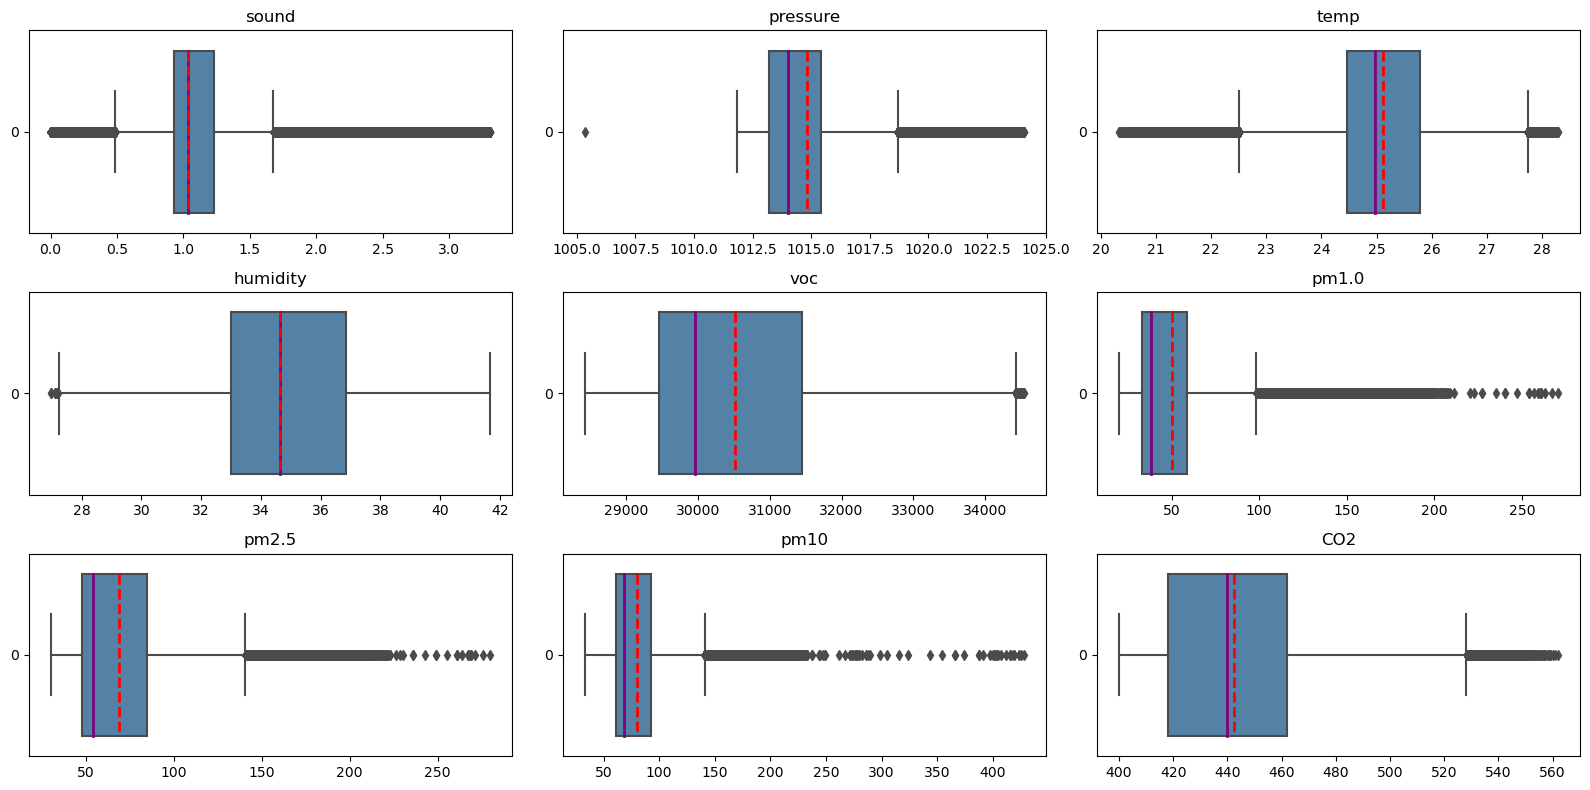

In [7]:
plt.figure(figsize=(16, 8))

for i, feature in enumerate(data):
    plt.subplot(3, 3, i+1)
    plt.title(feature)
    sns.boxplot(data[feature], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
    
plt.tight_layout()

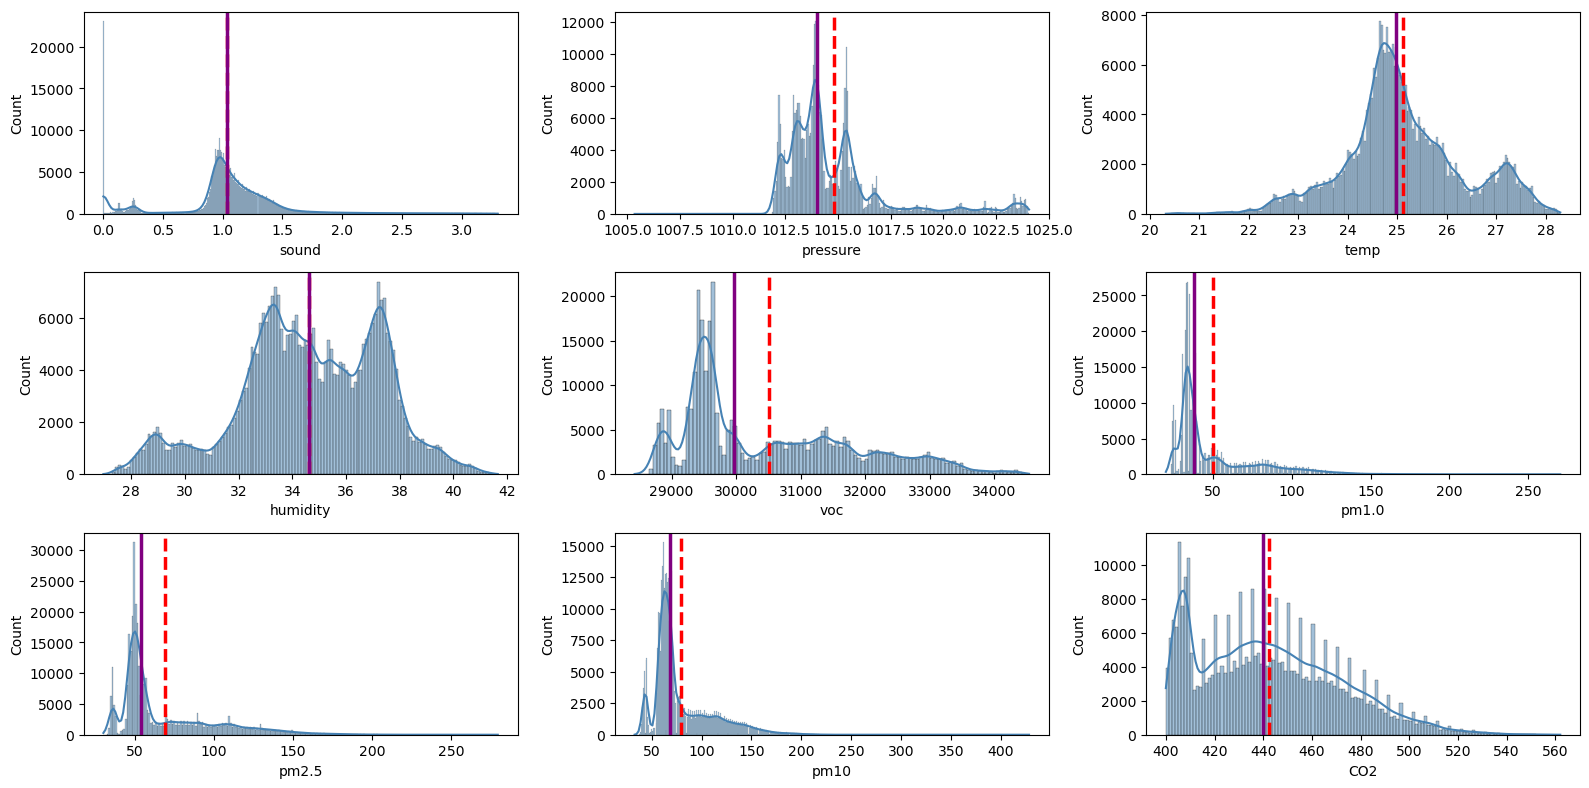

In [8]:
plt.figure(figsize=(16, 8))

for i, feature in enumerate(data):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[feature], color="steelblue", kde="true")
    plt.axvline(x=data[feature].mean(), c='red', ls='--', lw=2.5)
    plt.axvline(x=data[feature].median(), c='purple', ls='-', lw=2.5)

plt.tight_layout()

In [9]:
data.skew()

sound       0.390953
pressure    1.944262
temp        0.120681
humidity   -0.323284
voc         0.762294
pm1.0       1.698947
pm2.5       1.425518
pm10        1.516714
CO2         0.526927
dtype: float64

In [10]:
data.kurt()

sound       3.102921
pressure    3.737300
temp        0.227565
humidity   -0.236075
voc        -0.452798
pm1.0       2.683392
pm2.5       1.461839
pm10        2.619746
CO2        -0.322388
dtype: float64

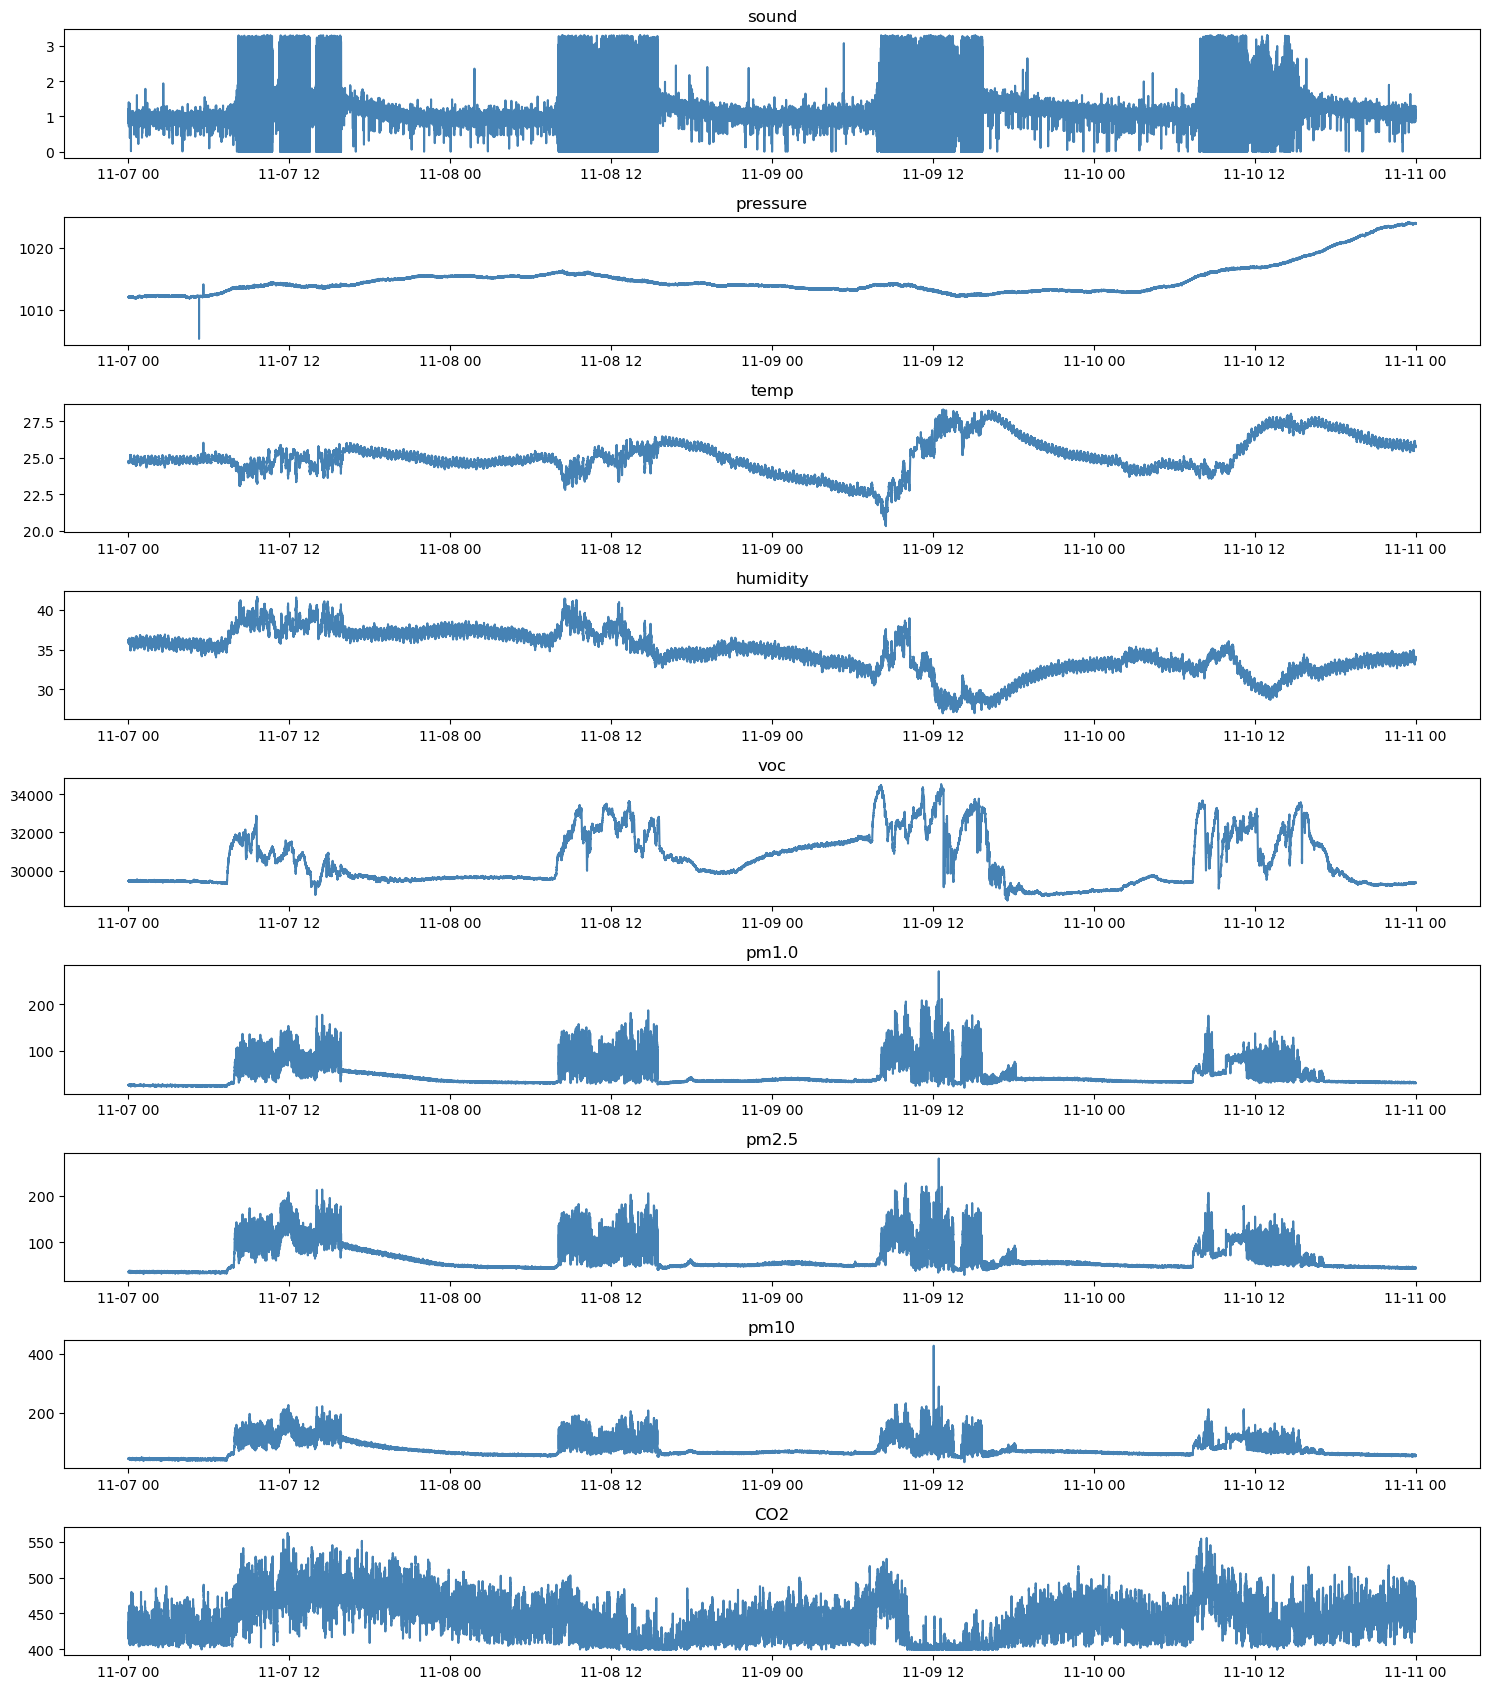

In [11]:
plt.figure(figsize=(15, 17))

for i, feature in enumerate(list(data.columns)):
    plt.subplot(9, 1, i+1)
    plt.title(feature)
    plt.plot(data.index, data[feature].values, color="steelblue")
    
plt.tight_layout()

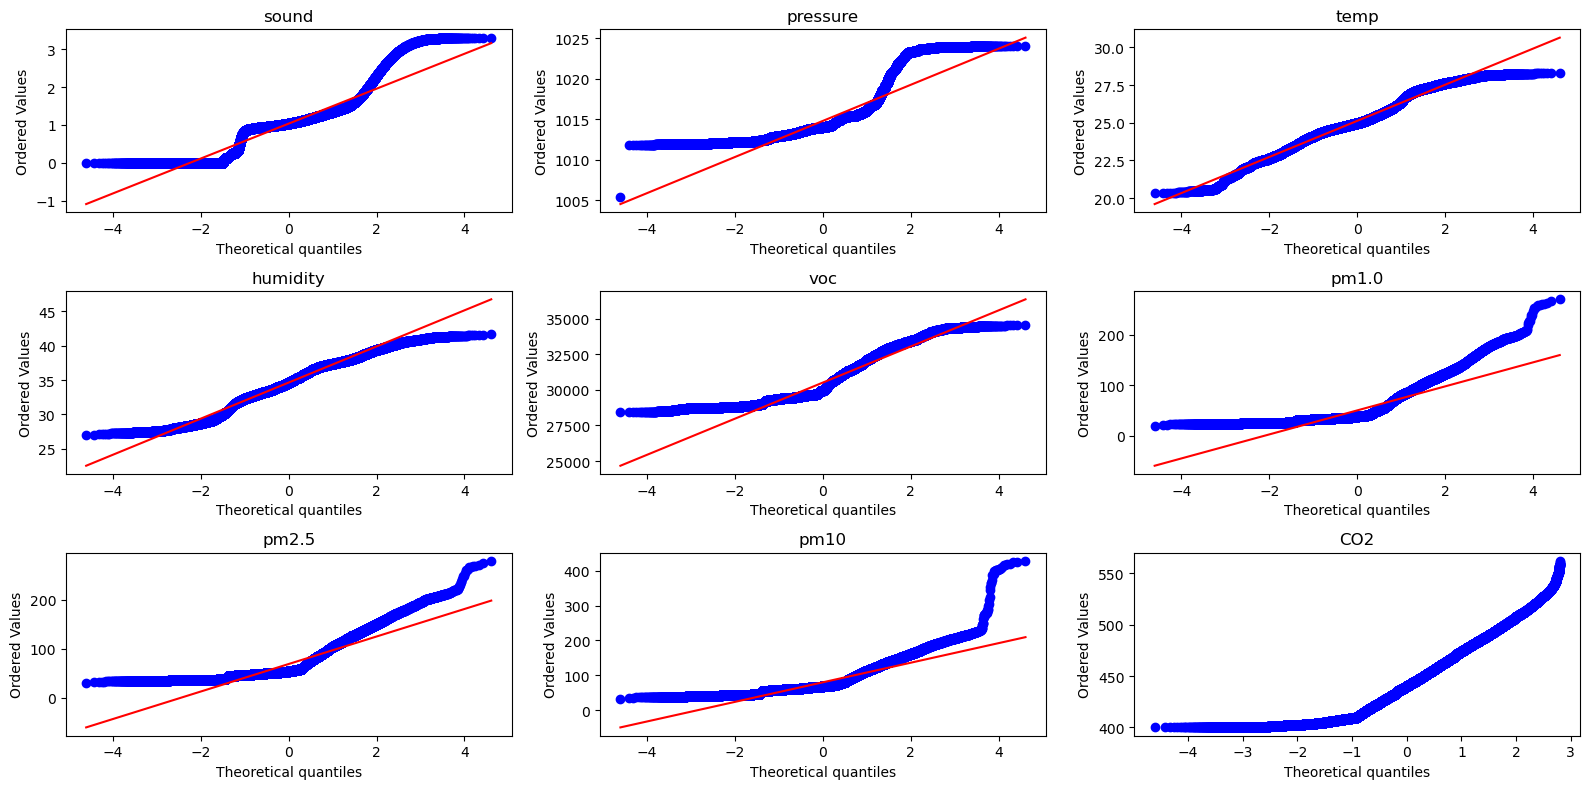

In [16]:
plt.figure(figsize=(16, 8))

for i, feature in enumerate(data):
    plt.subplot(3, 3, i+1)
    stats.probplot(data[feature], dist="norm", plot=pylab)
    plt.title(feature)

plt.tight_layout()

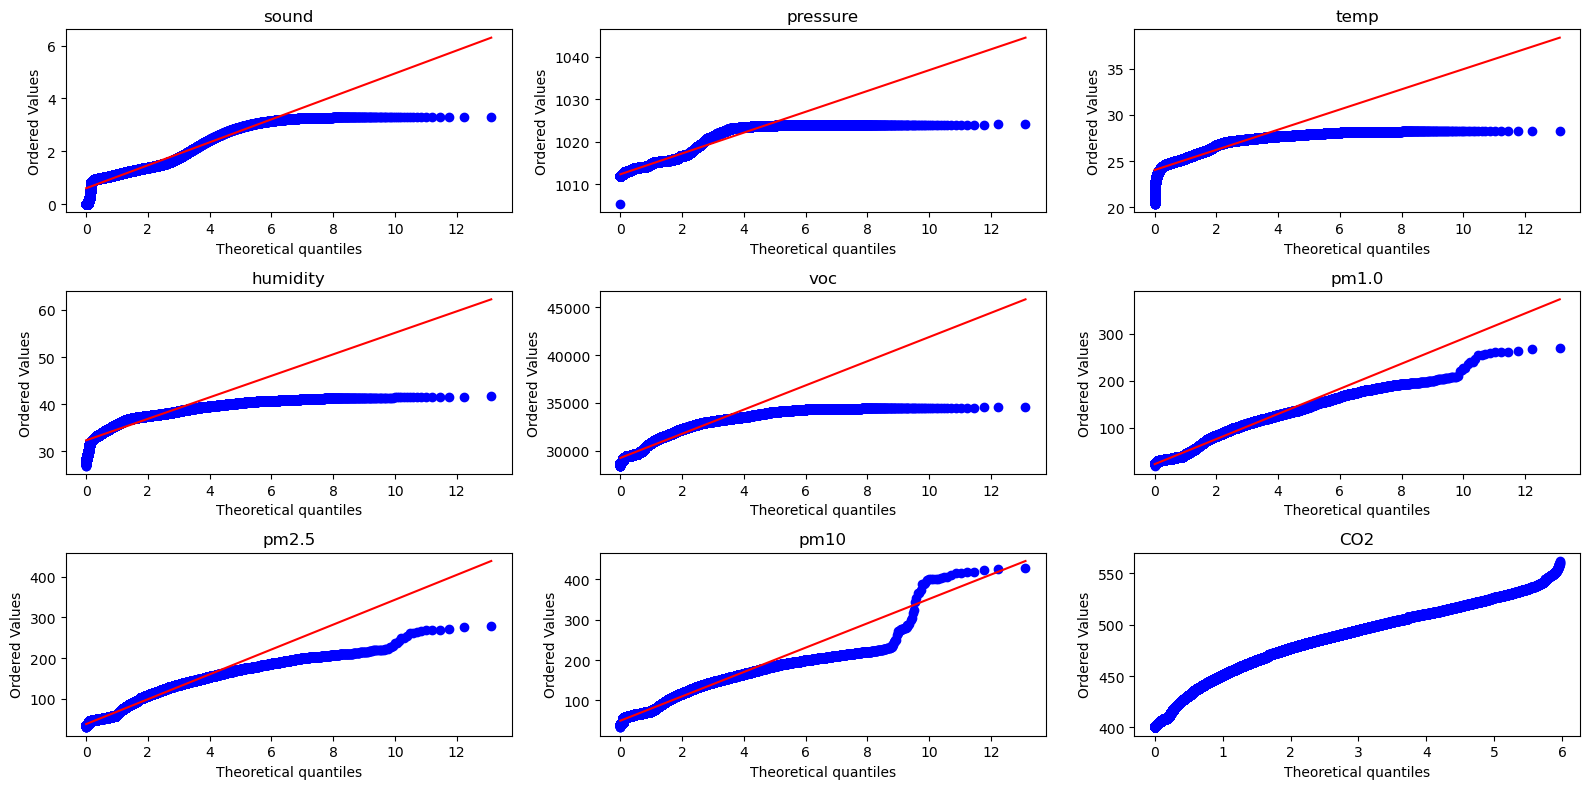

In [17]:
plt.figure(figsize=(16, 8))

for i, feature in enumerate(data):
    plt.subplot(3, 3, i+1)
    stats.probplot(data[feature], dist="expon", plot=pylab)
    plt.title(feature)

plt.tight_layout()

### Drugi korak

In [15]:
print(f"Number of missing values:\n{data.isna().sum()}")

Number of missing values:
sound         0
pressure      0
temp          0
humidity      0
voc           0
pm1.0         0
pm2.5         0
pm10          0
CO2         887
dtype: int64


In [8]:
null_data_index = pd.isna(data['CO2'])

In [9]:
data[null_data_index].head()

sound     pressure       temp   humidity      voc  \
timestamp                                                                   
2022-11-07 05:36:16  0.814914  1012.203064  24.700829  35.833130  29387.0   
2022-11-07 05:56:19  0.963374  1012.221396  24.962385  35.367310  29390.0   
2022-11-07 06:39:24  0.916577  1012.634170  24.782885  35.617693  29350.0   
2022-11-07 06:58:21  0.982738  1012.749966  24.685443  35.861509  29355.0   
2022-11-07 06:58:45  0.948851  1012.761371  24.746985  35.787535  29363.0   

                     pm1.0  pm2.5  pm10  CO2  
timestamp                                     
2022-11-07 05:36:16   25.0   35.0  42.0  NaN  
2022-11-07 05:56:19   25.0   37.0  47.0  NaN  
2022-11-07 06:39:24   24.0   35.0  41.0  NaN  
2022-11-07 06:58:21   24.0   35.0  42.0  NaN  
2022-11-07 06:58:45   25.0   36.0  42.0  NaN

In [10]:
data['CO2'] = data['CO2'].interpolate(method='linear')

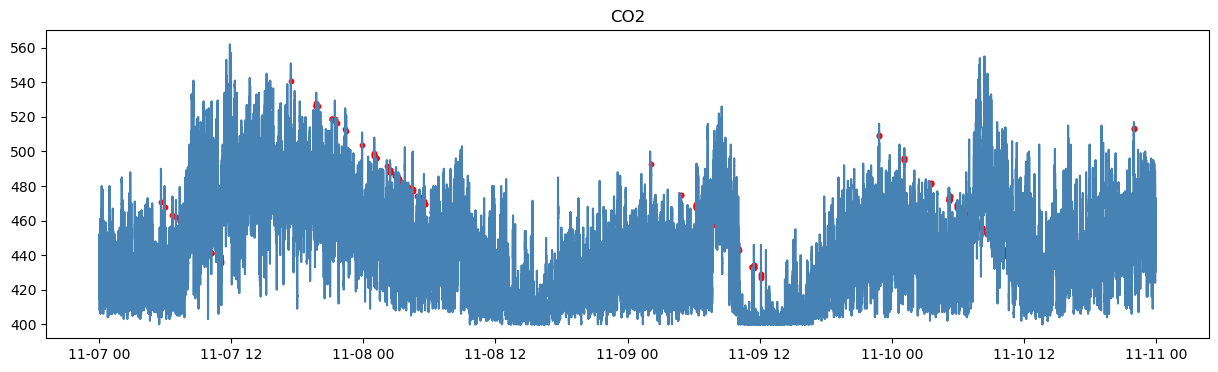

In [24]:
plt.figure(figsize=(15, 4))
plt.title('CO2')
plt.scatter(x=data[null_data_index].index, y=data[null_data_index]['CO2'], s=10, c='red')
plt.plot(data.index, data['CO2'].values, color="steelblue")
plt.show()

In [20]:
print(f"Number of duplicates in dataset: {data.duplicated().sum()}")
print(f"Number of duplicates in dataset (index): {data.index.duplicated().sum()}")

Number of duplicates in dataset: 0
Number of duplicates in dataset (index): 24


In [22]:
duplicate = data[data.index.duplicated()]
duplicate

sound     pressure       temp   humidity      voc  \
timestamp                                                                   
2022-11-07 01:00:00  0.927873  1012.029181  24.885456  35.769386  29454.0   
2022-11-07 05:00:00  0.929487  1012.083651  24.726471  35.821613  29466.0   
2022-11-07 09:00:00  0.731002  1013.577997  24.454659  38.499439  31630.0   
2022-11-07 10:00:00  1.844450  1013.874410  24.449530  38.928240  30666.0   
2022-11-07 11:00:00  1.591100  1014.204036  25.552171  36.589889  30518.0   
2022-11-07 16:00:00  1.391002  1013.957464  25.500885  37.518162  29939.0   
2022-11-08 04:00:00  0.874621  1015.260768  24.695700  37.036374  29647.0   
2022-11-08 05:00:00  1.032763  1015.392091  25.167527  36.219366  29643.0   
2022-11-08 07:00:00  0.916577  1015.672999  24.782885  36.691268  29551.0   
2022-11-08 11:00:00  0.950465  1015.642579  25.131627  36.813337  32351.0   
2022-11-08 12:00:00  1.899315  1015.222323  24.741857  38.182545  32943.0   
2022-11-08 15:00:00  0.000000  1014.405803  24.705957  36.657881  32743.0   
2022-11-09 08:00:00  1.006944  1014.055515  22.269931  32.164413  34351.0   
2022-11-09 14:00:00  1.358729  1012.260030  27.690820  27.930858  31607.0   
2022-11-09 16:00:00  1.457164  1012.446049  27.680563  28.620852  31522.0   
2022-11-09 17:00:00  1.392616  1012.778688  27.654919  28.963446  29666.0   
2022-11-09 20:00:00  1.263521  1013.127483  25.680386  32.244212  28815.0   
2022-11-09 23:00:00  1.118289  1013.048194  25.352156  32.515925  28827.0   
2022-11-10 09:00:00  2.055844  1016.085144  23.905907  34.982371  32659.0   
2022-11-10 10:00:00  2.057457  1016.529830  24.259775  34.911033  32403.0   
2022-11-10 12:00:00  0.414719  1016.921382  26.465065  30.742856  32603.0   
2022-11-10 13:00:00  1.160244  1017.015528  27.054862  30.252861  30294.0   
2022-11-10 17:00:00  1.273203  1019.435077  27.229237  32.337065  31342.0   
2022-11-10 21:00:00  0.982738  1022.787157  26.290692  33.442614  29251.0   

                     pm1.0  pm2.5   pm10    CO2  
timestamp                                        
2022-11-07 01:00:00   25.0   36.0   44.0  449.0  
2022-11-07 05:00:00   26.0   37.0   45.0  408.0  
2022-11-07 09:00:00   69.0  103.0  119.0  487.0  
2022-11-07 10:00:00   94.0  126.0  139.0  487.0  
2022-11-07 11:00:00   46.0   78.0   92.0  436.0  
2022-11-07 16:00:00   57.0   97.0  121.0  496.0  
2022-11-08 04:00:00   32.0   47.0   59.0  439.0  
2022-11-08 05:00:00   32.0   46.0   58.0  408.0  
2022-11-08 07:00:00   31.0   46.0   57.0  425.0  
2022-11-08 11:00:00   75.0   94.0  100.0  409.0  
2022-11-08 12:00:00   66.0   85.0   95.0  409.0  
2022-11-08 15:00:00  105.0  119.0  123.0  404.0  
2022-11-09 08:00:00   39.0   57.0   78.0  485.0  
2022-11-09 14:00:00   30.0   42.0   50.0  403.0  
2022-11-09 16:00:00   34.0   48.0   60.0  402.0  
2022-11-09 17:00:00   38.0   53.0   68.0  408.0  
2022-11-09 20:00:00   39.0   56.0   70.0  462.0  
2022-11-09 23:00:00   39.0   55.0   69.0  438.0  
2022-11-10 09:00:00   48.0   68.0   74.0  505.0  
2022-11-10 10:00:00   80.0  105.0  112.0  470.0  
2022-11-10 12:00:00   71.0   95.0  101.0  409.0  
2022-11-10 13:00:00   76.0   96.0  101.0  441.0  
2022-11-10 17:00:00   49.0   62.0   72.0  432.0  
2022-11-10 21:00:00   32.0   46.0   58.0  436.0

In [11]:
data = data.groupby(level=0).mean() 
data = data[~data.index.duplicated()]

In [25]:
print(f"Number of duplicates in dataset (index): {data.index.duplicated().sum()}")

Number of duplicates in dataset (index): 0


In [12]:
data = data.resample('S').asfreq().interpolate(method='linear')

In [26]:
data.info() # 345599, sto odgovara periodu od 4 dana

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345151 entries, 2022-11-07 00:00:01 to 2022-11-10 23:59:59
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sound     345151 non-null  float64
 1   pressure  345151 non-null  float64
 2   temp      345151 non-null  float64
 3   humidity  345151 non-null  float64
 4   voc       345151 non-null  float64
 5   pm1.0     345151 non-null  float64
 6   pm2.5     345151 non-null  float64
 7   pm10      345151 non-null  float64
 8   CO2       345151 non-null  float64
dtypes: float64(9)
memory usage: 26.3 MB


In [15]:
print("3 sigma: 68 95 99.7 \n")
for i, feature in enumerate(data):
    mean = np.mean(data[feature])
    std_dev = np.std(data[feature])

    within_one_std_dev = np.sum(np.abs(data[feature] - mean) < std_dev) / len(data[feature])
    within_two_std_dev = np.sum(np.abs(data[feature] - mean) < 2 * std_dev) / len(data[feature])
    within_three_std_dev = np.sum(np.abs(data[feature] - mean) < 3 * std_dev) / len(data[feature])

    print(feature)
    print("Percentage of data within one standard deviation:", round(within_one_std_dev * 100, 1))
    print("Percentage of data within two standard deviations:", round(within_two_std_dev * 100, 1))
    print("Percentage of data within three standard deviations:", round(within_three_std_dev * 100, 1))
    print("\n")

3 sigma: 68 95 99.7 

sound
Percentage of data within one standard deviation: 78.8
Percentage of data within two standard deviations: 89.8
Percentage of data within three standard deviations: 98.4


pressure
Percentage of data within one standard deviation: 83.1
Percentage of data within two standard deviations: 93.1
Percentage of data within three standard deviations: 96.4


temp
Percentage of data within one standard deviation: 71.3
Percentage of data within two standard deviations: 94.5
Percentage of data within three standard deviations: 99.8


humidity
Percentage of data within one standard deviation: 69.0
Percentage of data within two standard deviations: 94.1
Percentage of data within three standard deviations: 100.0


voc
Percentage of data within one standard deviation: 72.4
Percentage of data within two standard deviations: 95.8
Percentage of data within three standard deviations: 100.0


pm1.0
Percentage of data within one standard deviation: 83.1
Percentage of data within t

In [14]:
for i, feature in enumerate(data):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    upper_array = data[data[feature] >= upper].index
    lower_array = data[data[feature] <= lower].index

    if (len(upper_array) > 0):
        df_upper_outliers = data.loc[upper_array, feature]
        print(feature + ' upper outliers:')
        print(df_upper_outliers.describe())

    if (len(lower_array) > 0):
        df_lower_outliers = data.loc[lower_array, feature]
        print(feature + ' lower outliers:')
        print(df_lower_outliers.describe())

    print()

sound upper outliers:
count    19715.000000
mean         2.249913
std          0.453160
min          1.677433
25%          1.855746
50%          2.138142
75%          2.578680
max          3.303227
Name: sound, dtype: float64
sound lower outliers:
count    45300.000000
mean         0.108751
std          0.129023
min          0.000000
25%          0.000000
50%          0.000000
75%          0.237213
max          0.483301
Name: sound, dtype: float64

pressure upper outliers:
count    29267.000000
mean      1021.729205
std          1.670527
min       1018.718966
25%       1020.394165
50%       1021.936558
75%       1023.357489
max       1024.071917
Name: pressure, dtype: float64
pressure lower outliers:
count       1.000000
mean     1005.339453
std              NaN
min      1005.339453
25%      1005.339453
50%      1005.339453
75%      1005.339453
max      1005.339453
Name: pressure, dtype: float64

temp upper outliers:
count    4287.000000
mean       27.942598
std         0.140192
min   

In [6]:
attributes_empirical = ['temp', 'humidity', 'voc', 'CO2']
attributes_iqr = ['pm1.0', 'pm2.5', 'pm10', 'pressure', 'sound']

temp: 834
voc: 17
CO2: 1018


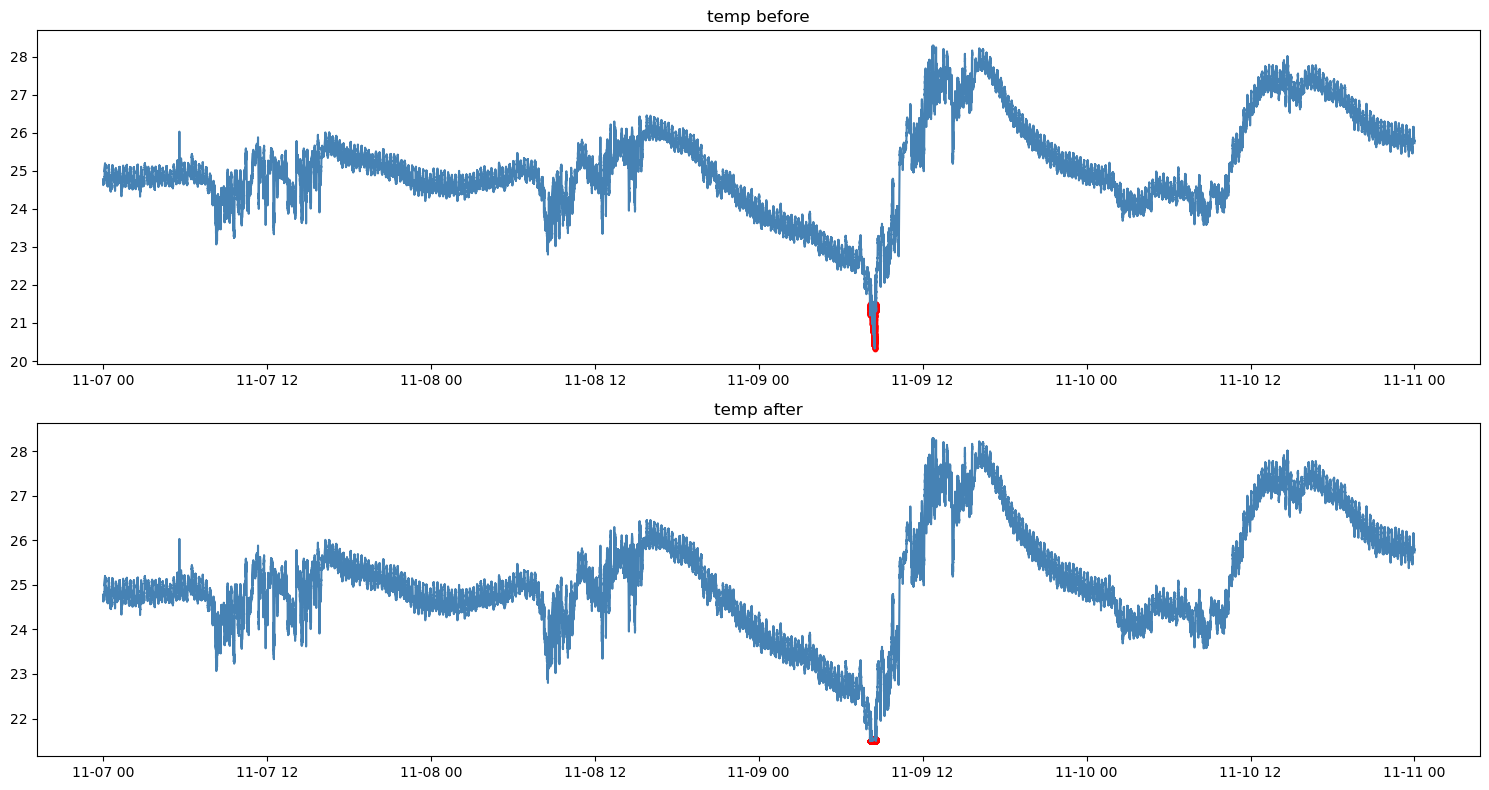

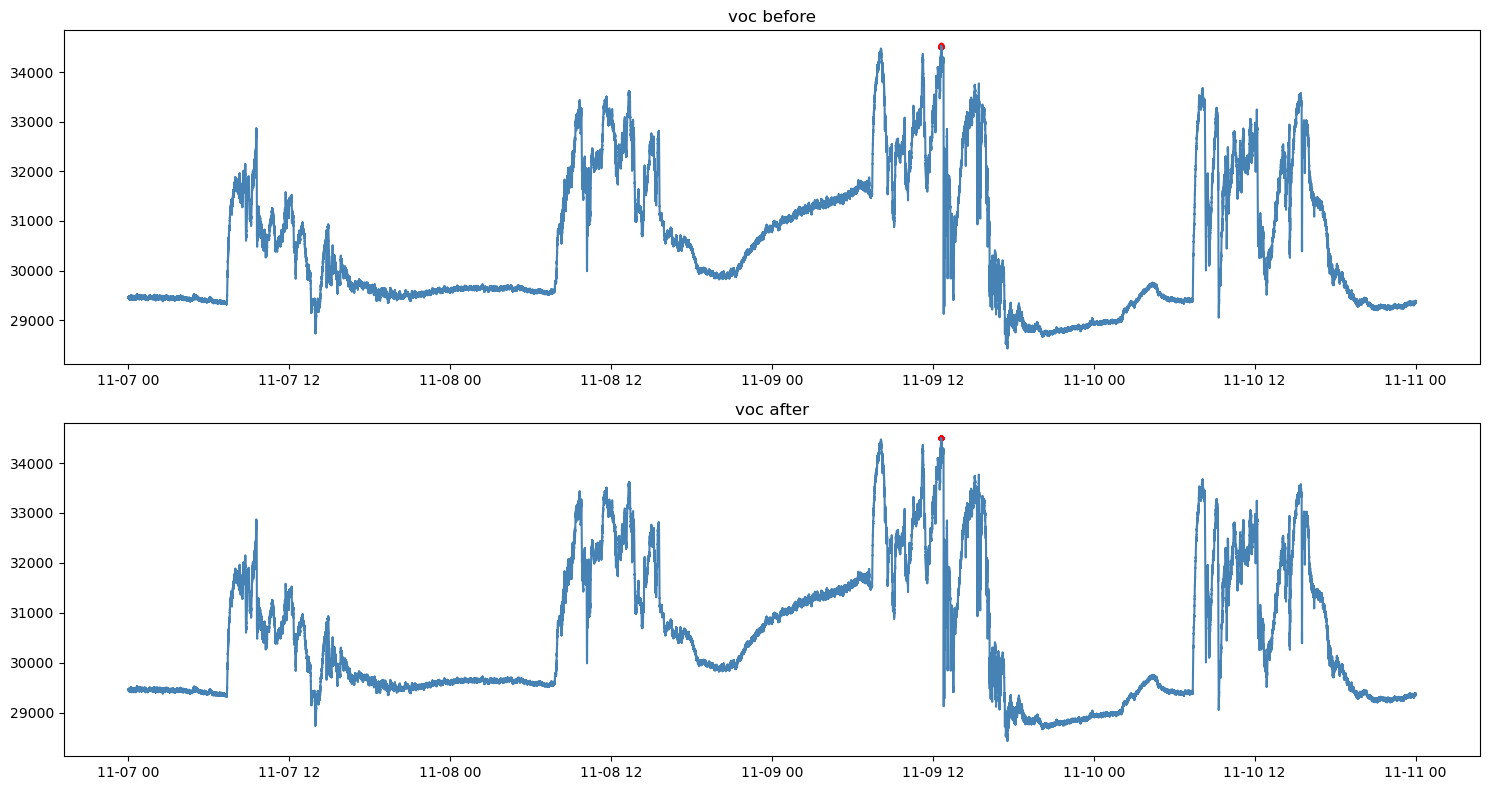

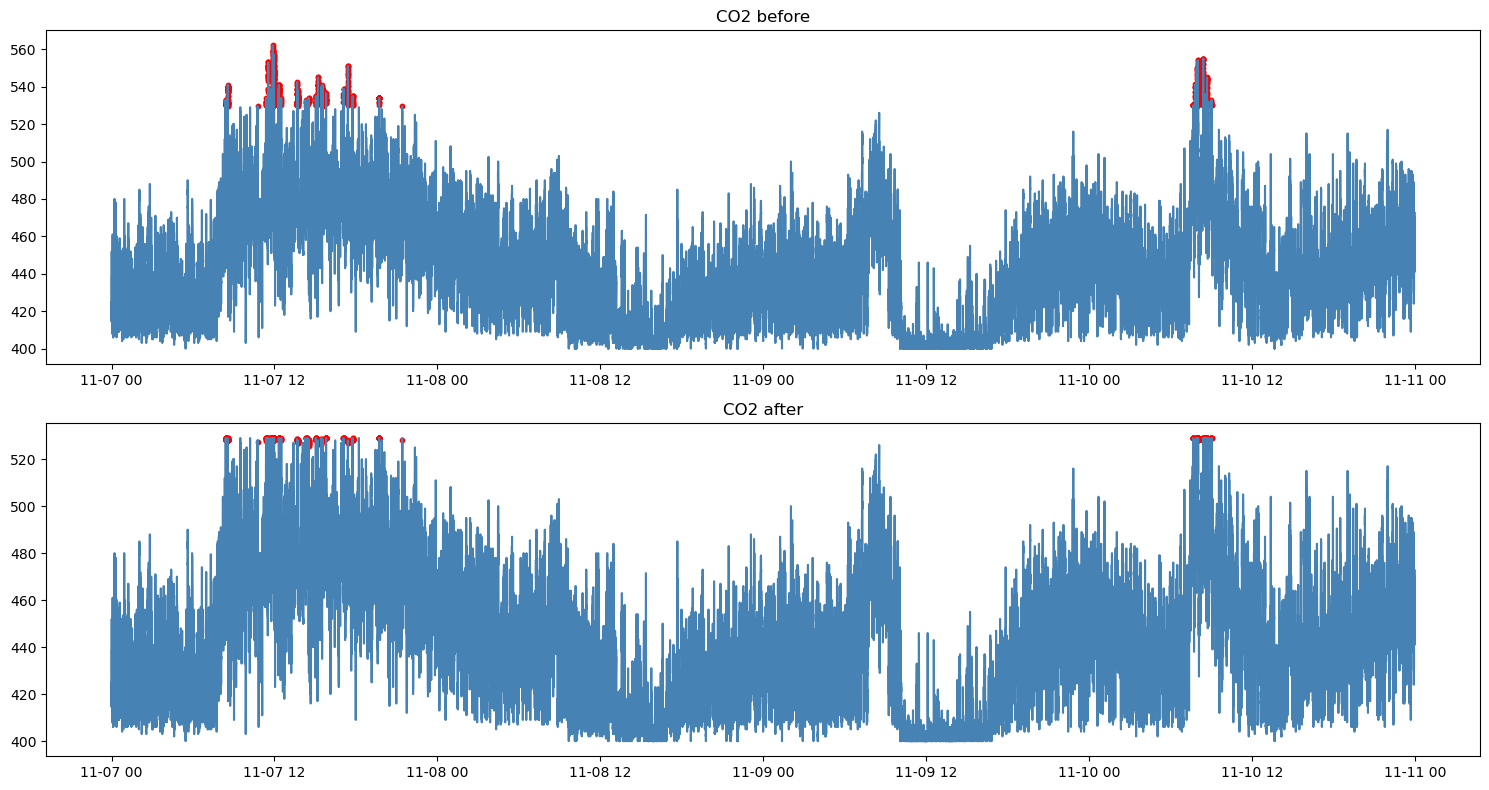

In [32]:
for feature in attributes_empirical:
    mean = np.mean(data[feature])
    std_dev = np.std(data[feature])

    outliers_array = data[np.abs(data[feature] - mean) > 3 * std_dev].index

    if len(outliers_array) > 0:
        print(feature + ": " + str(len(outliers_array)))
        plt.figure(figsize=(15, 8))

        plt.subplot(2, 1, 1)
        plt.title(feature + " before")
        plt.plot(data.index, data[feature].values, color="steelblue")
        plt.scatter(x=data.loc[outliers_array].index, y=data.loc[outliers_array][feature].values, s=10, c='red')

        plt.subplot(2, 1, 2)
        plt.title(feature + " after")
        data.loc[outliers_array, feature] = np.nan
        data[feature] = data[feature].interpolate(method='linear')
        plt.plot(data.index, data[feature].values, color="steelblue")
        plt.scatter(x=data.loc[outliers_array].index, y=data.loc[outliers_array][feature].values, s=10, c='red')
        
        plt.tight_layout()

In [33]:
for feature in attributes_empirical:
    mean = np.mean(data[feature])
    std_dev = np.std(data[feature])

    outliers_array = data[np.abs(data[feature] - mean) > 3 * std_dev].index

    if len(outliers_array) > 0:
        print(feature + ": " + str(len(outliers_array)))

temp: 106
CO2: 530


pm1.0: 28022
pm2.5: 13089
pm10: 21135
pressure: 29268
sound: 65015


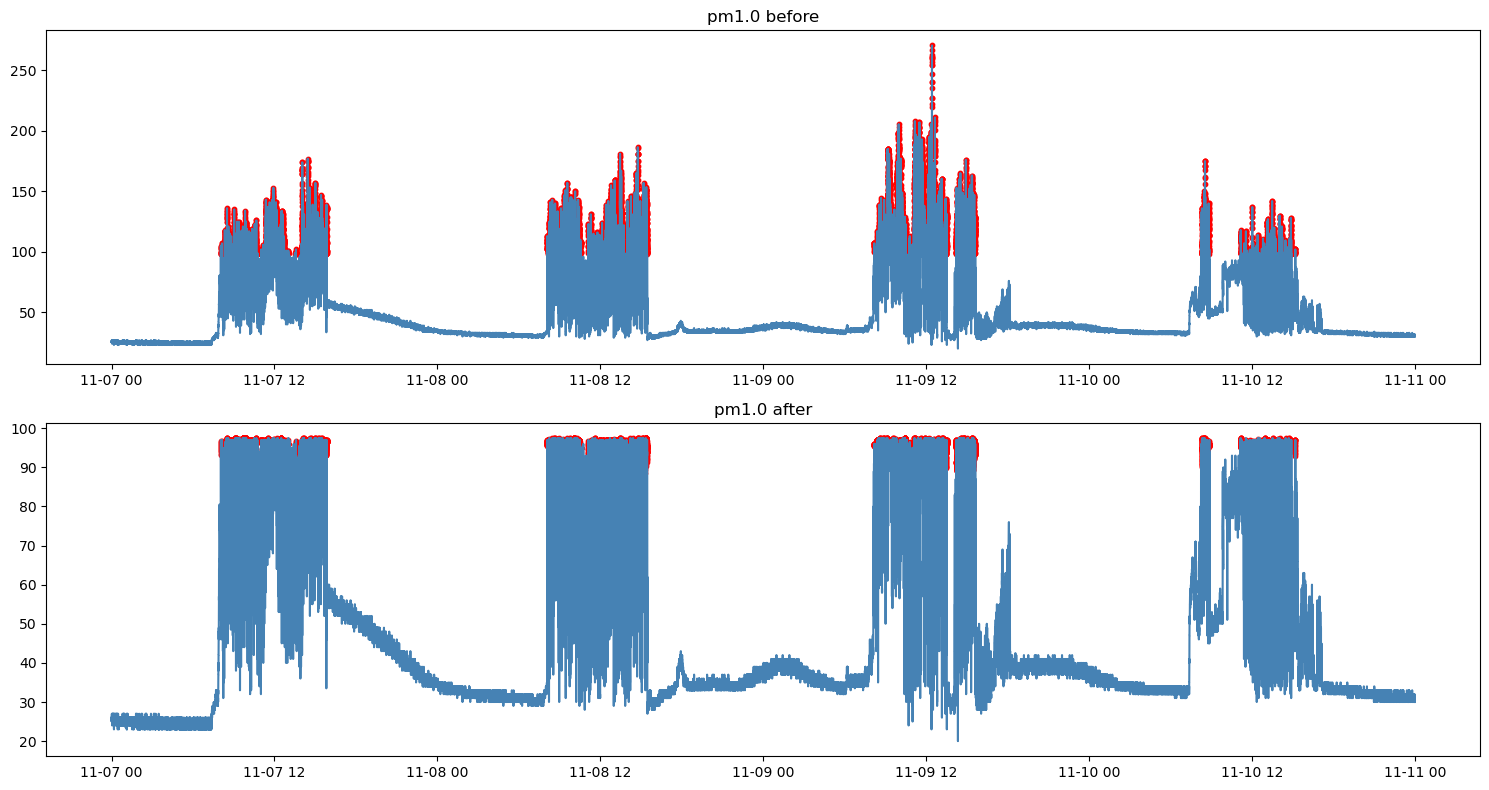

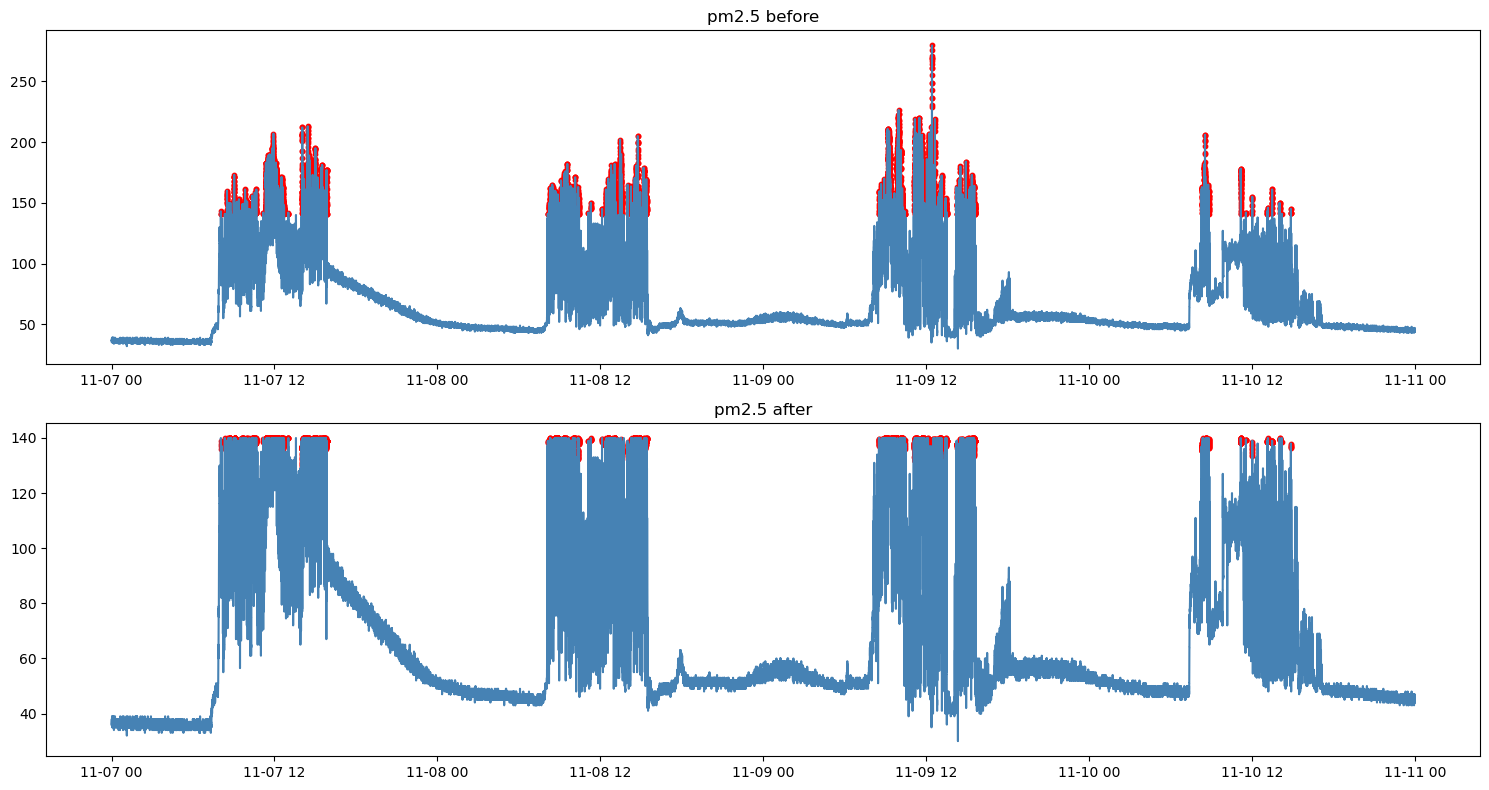

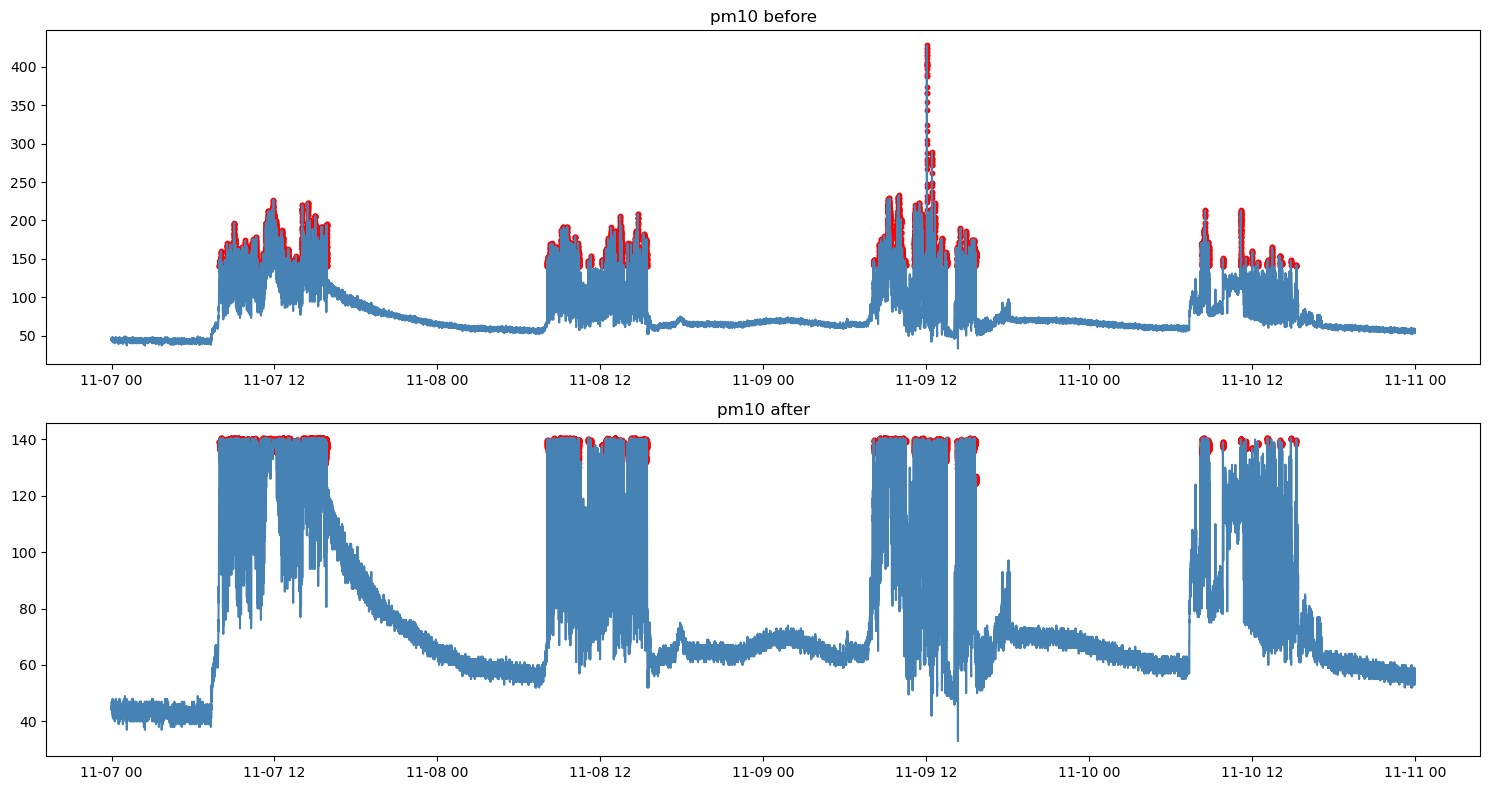

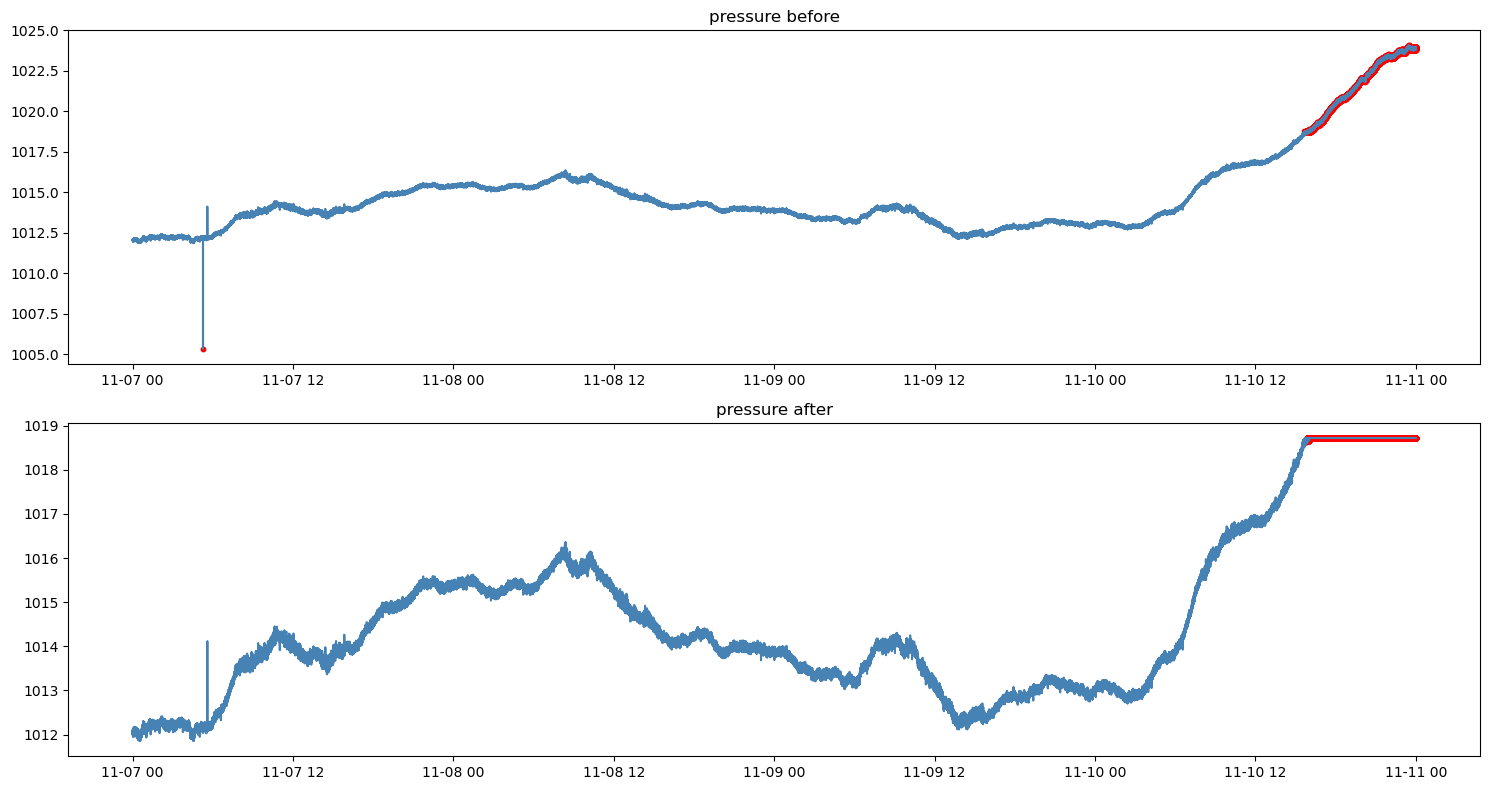

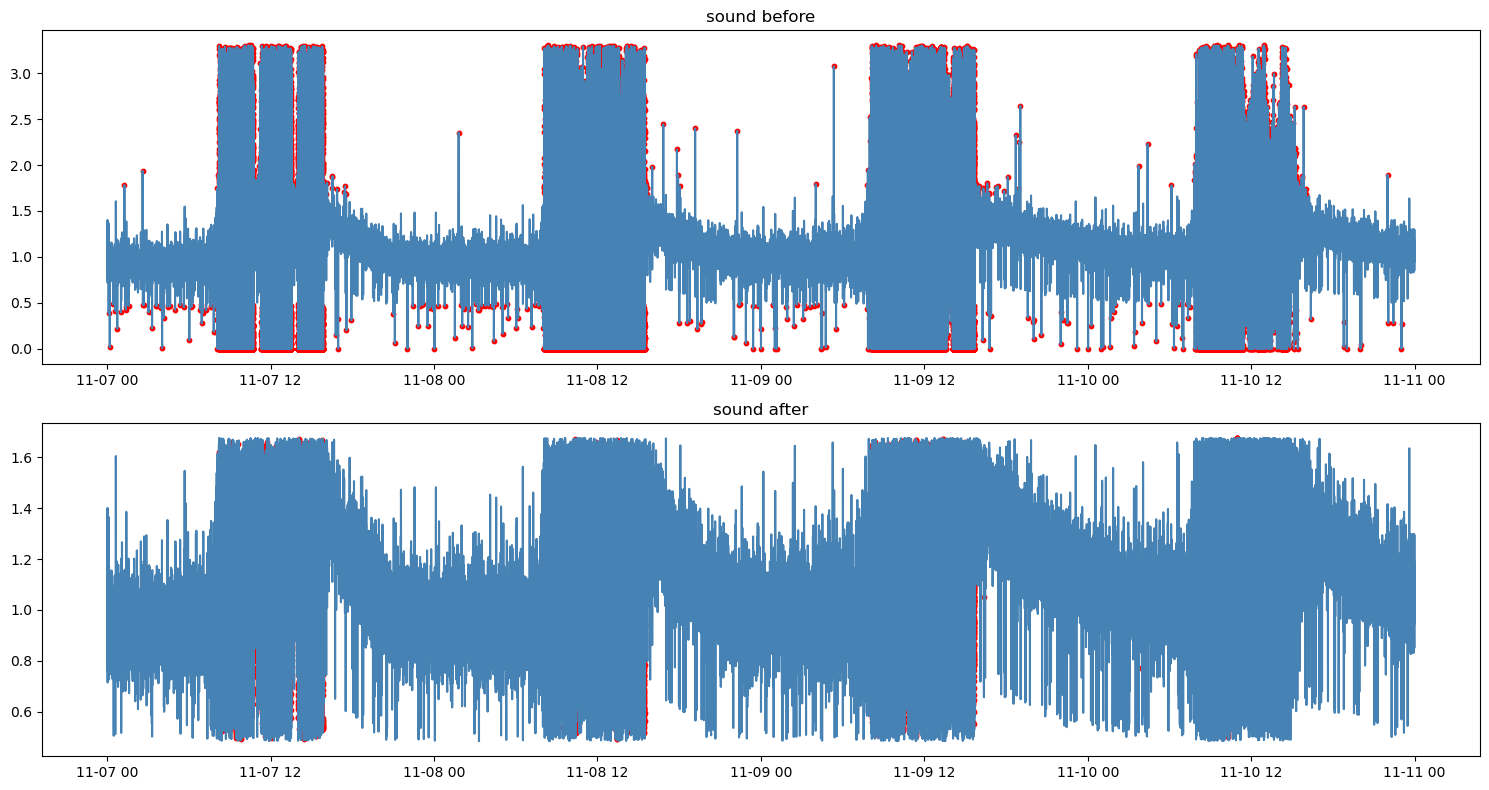

In [40]:
for feature in attributes_iqr:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    upper_array = data[data[feature] >= upper].index
    lower_array = data[data[feature] <= lower].index

    if len(upper_array) > 0 or len(lower_array) > 0:
        print(feature + ": " + str(len(upper_array) + len(lower_array)))
        plt.figure(figsize=(15, 8))

        plt.subplot(2, 1, 1)
        plt.title(feature + " before")
        plt.plot(data.index, data[feature].values, color="steelblue")
        plt.scatter(x=data.loc[upper_array].index, y=data.loc[upper_array][feature].values, s=10, c='red')
        plt.scatter(x=data.loc[lower_array].index, y=data.loc[lower_array][feature].values, s=10, c='red')

        plt.subplot(2, 1, 2)
        plt.title(feature + " after")
        
        data.loc[upper_array, feature] = np.nan
        data.loc[lower_array, feature] = np.nan
        data[feature] = data[feature].interpolate(method='linear')
        plt.plot(data.index, data[feature].values, color="steelblue")

        if len(upper_array) > 0:
            plt.scatter(x= data.loc[upper_array].index, y=data.loc[upper_array][feature].values, s=10, c='red')
        if len(lower_array) > 0:
            plt.scatter(x=data.loc[lower_array].index, y=data.loc[lower_array][feature].values, s=10, c='red')

        plt.tight_layout()       

In [41]:
for feature in attributes_iqr:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    upper_array = data[data[feature] >= upper].index
    lower_array = data[data[feature] <= lower].index

    if len(upper_array) > 0 or len(lower_array) > 0:
        print(feature + ": " + str(len(upper_array) + len(lower_array)))

sound: 1687


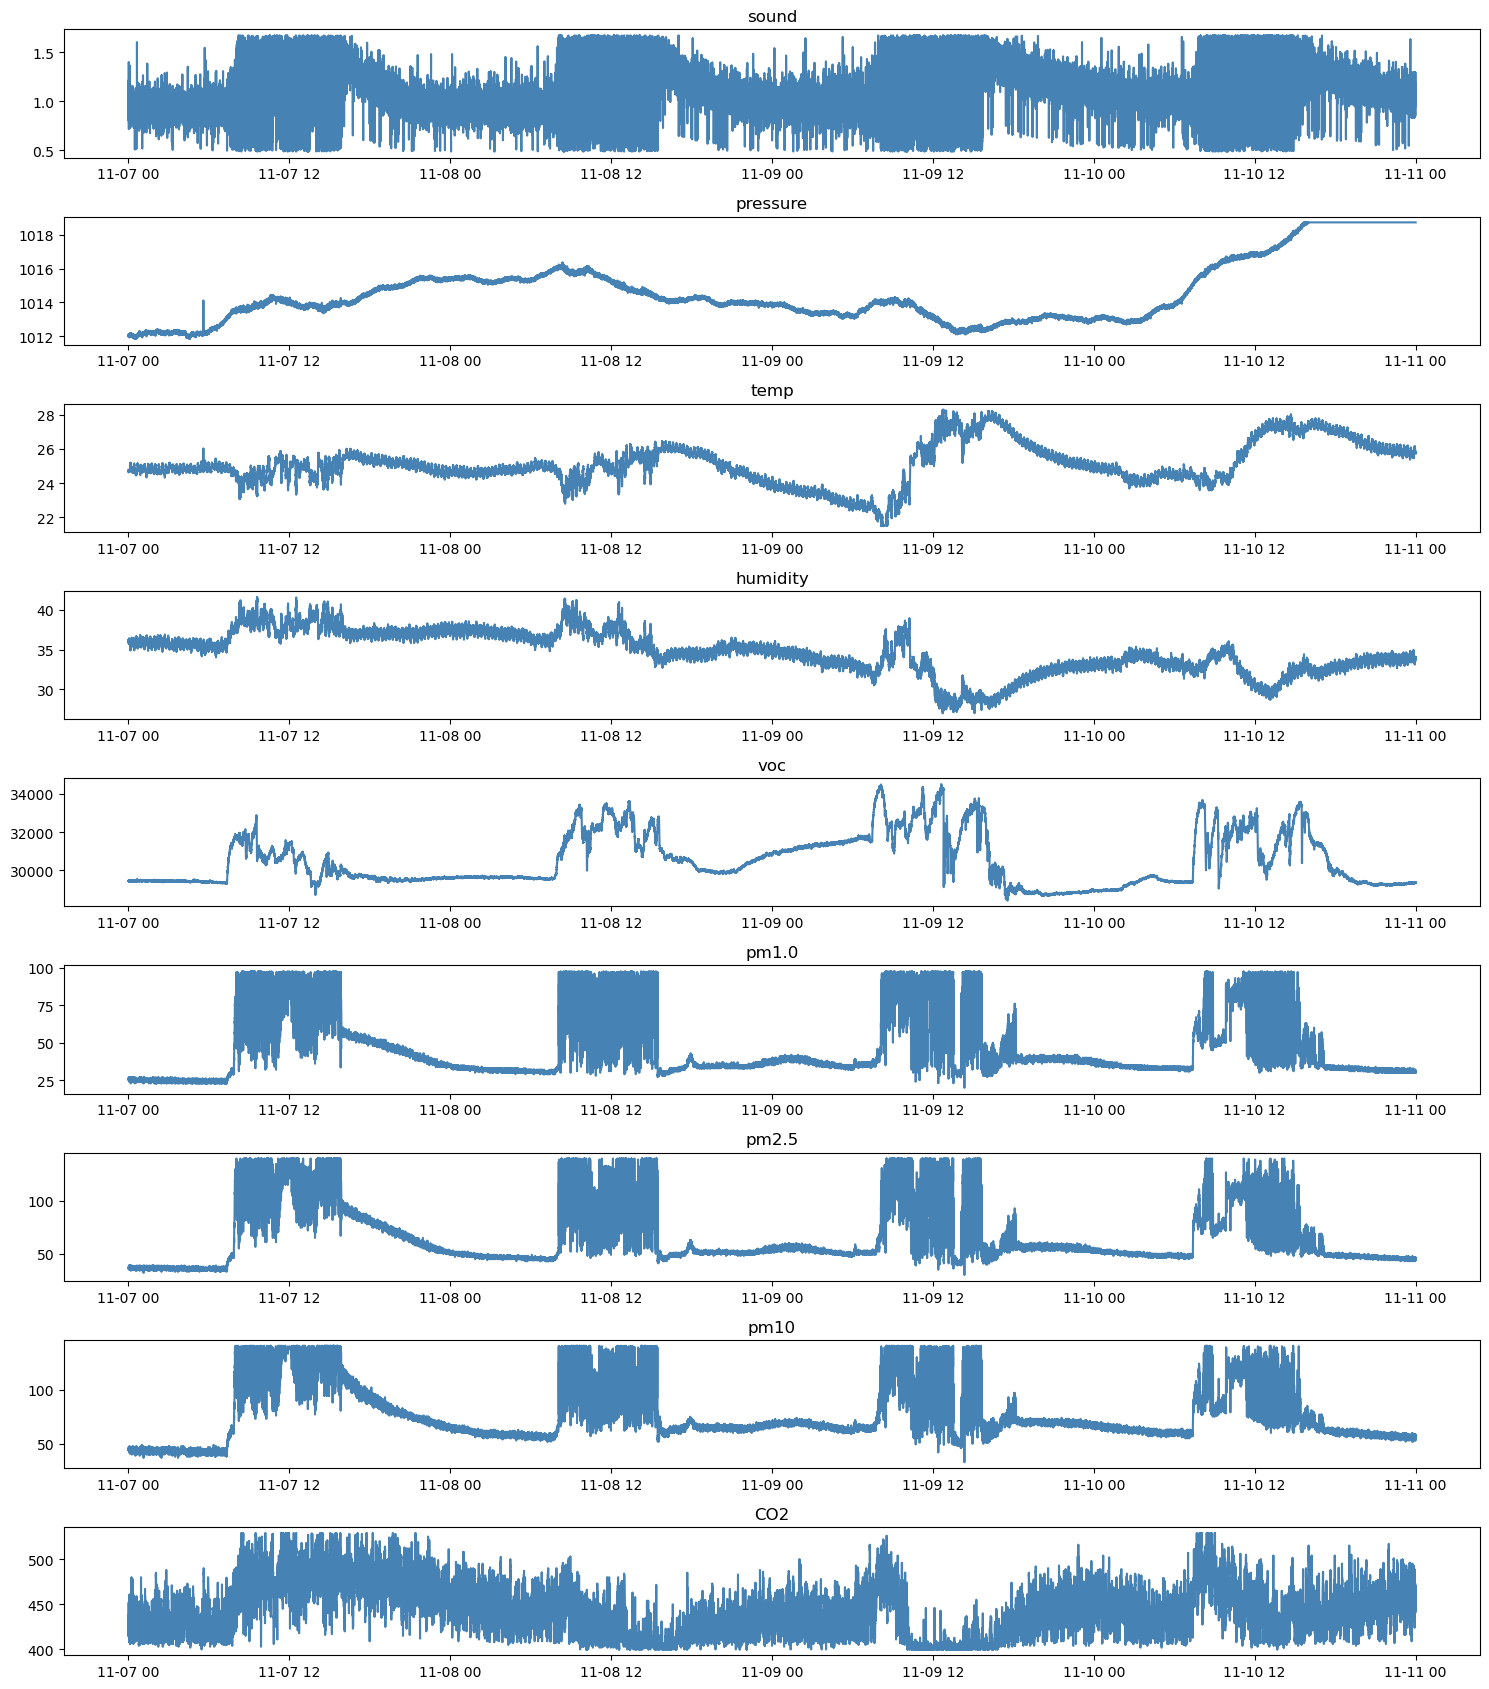

In [42]:
plt.figure(figsize=(15, 17))

for i, feature in enumerate(list(data.columns)):
    plt.subplot(9, 1, i+1)
    plt.title(feature)
    plt.plot(data.index, data[feature].values, color="steelblue")
    
plt.tight_layout()

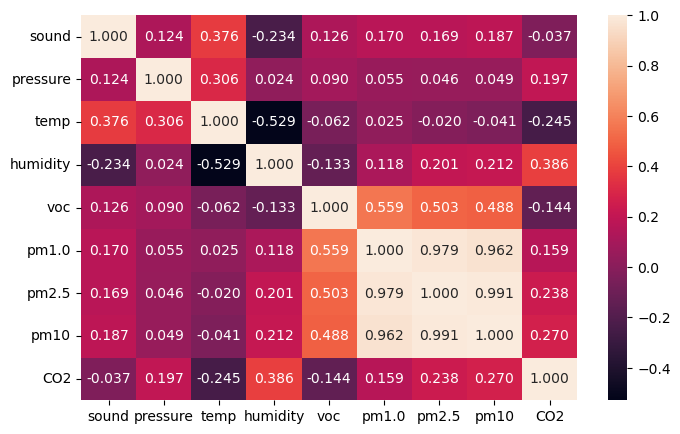

In [43]:
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot = True, fmt='.3f')
plt.show()

### Treci korak

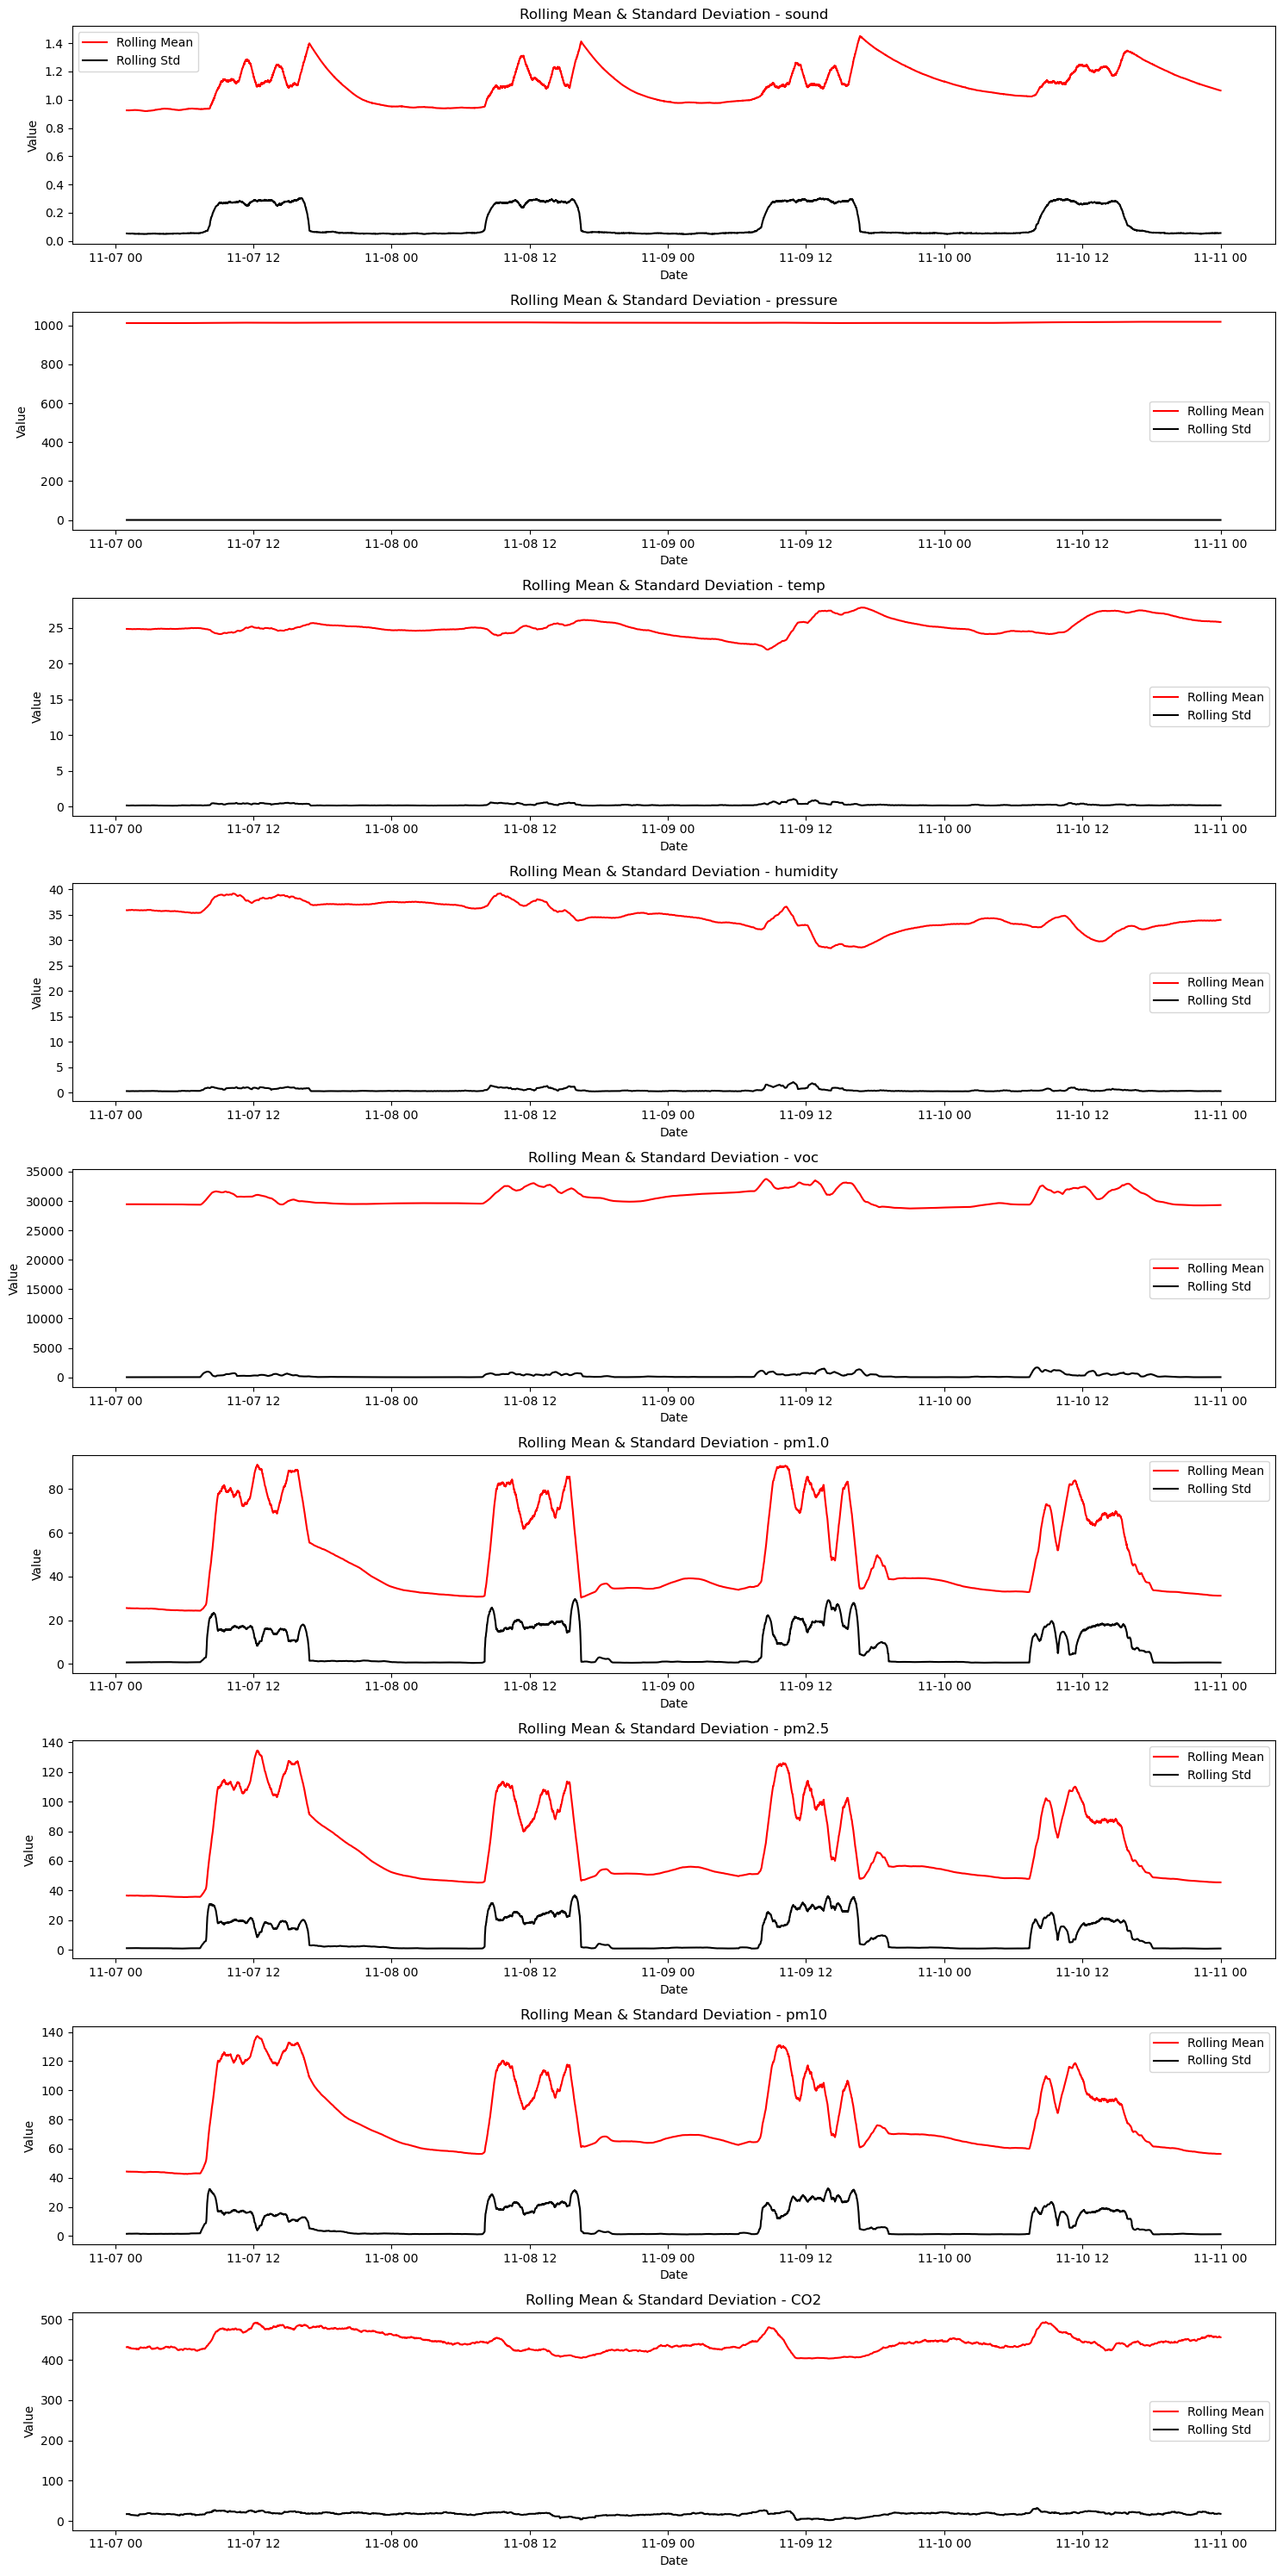

In [13]:
plt.figure(figsize=(15, 30))

window_size = 3600
for i, feature in enumerate(data):
    ts_data = data[feature]

    rolling_mean = ts_data.rolling(window=window_size).mean()
    rolling_std = ts_data.rolling(window=window_size).std()

    plt.subplot(9, 1, i+1)
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation' + ' - ' + feature)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    
plt.tight_layout()

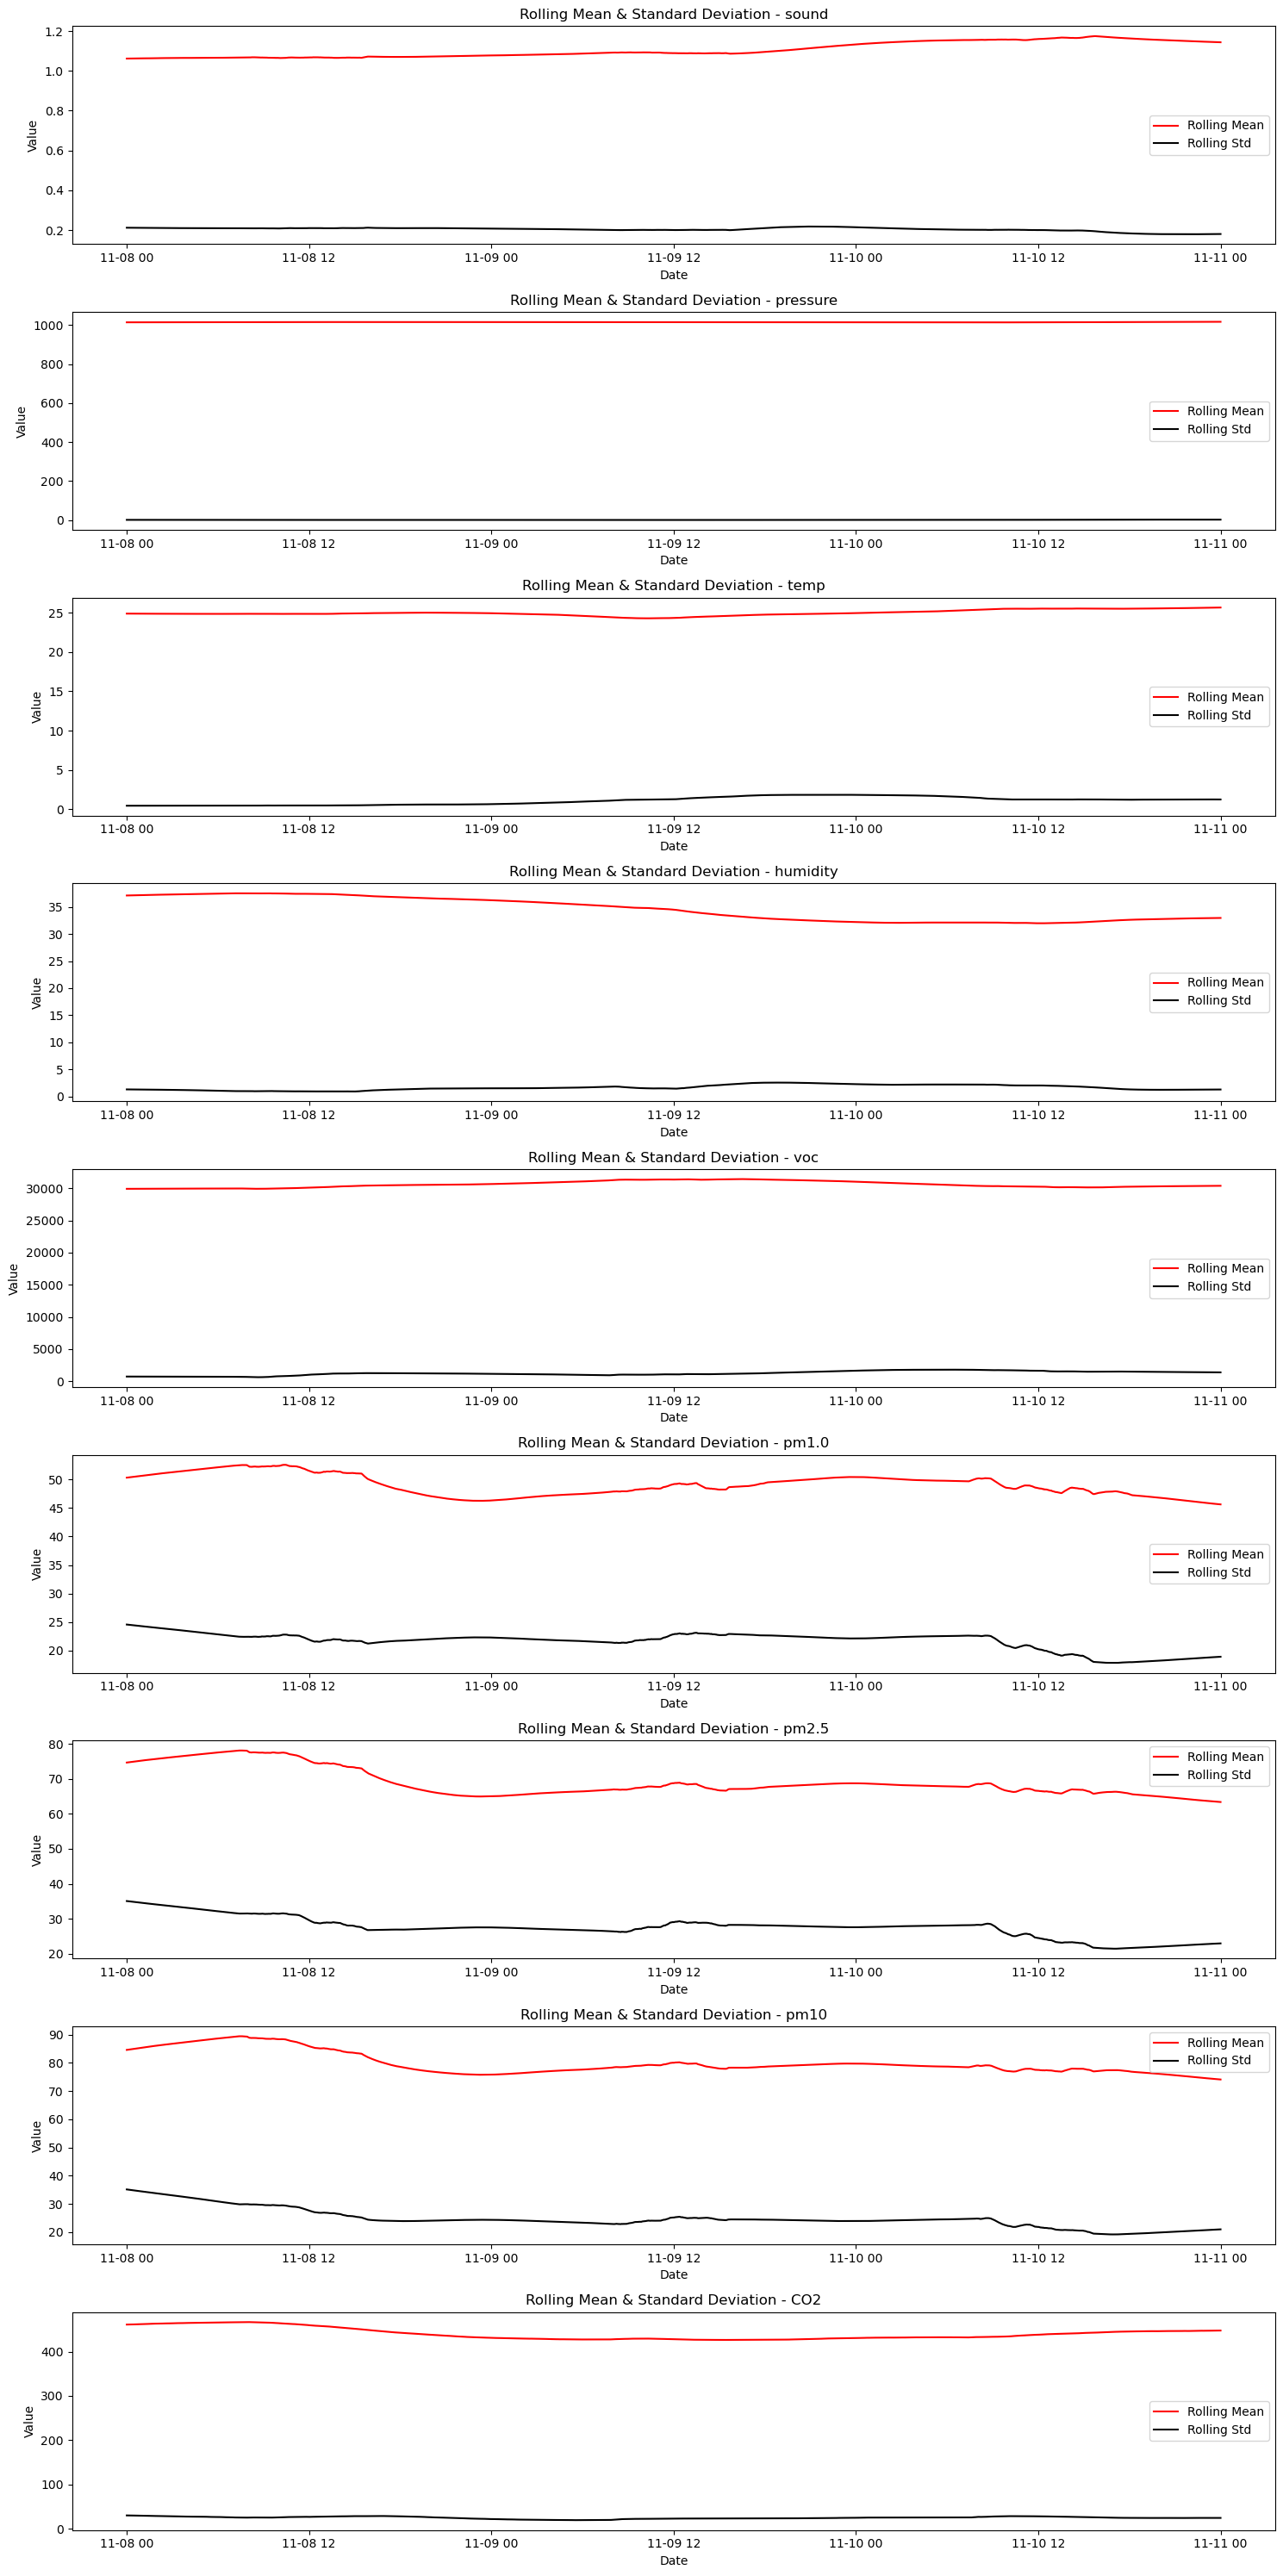

In [12]:
plt.figure(figsize=(15, 30))

window_size = 3600*24
for i, feature in enumerate(data):
    ts_data = data[feature]

    rolling_mean = ts_data.rolling(window=window_size).mean()
    rolling_std = ts_data.rolling(window=window_size).std()

    plt.subplot(9, 1, i+1)
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation' + ' - ' + feature)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    
plt.tight_layout()

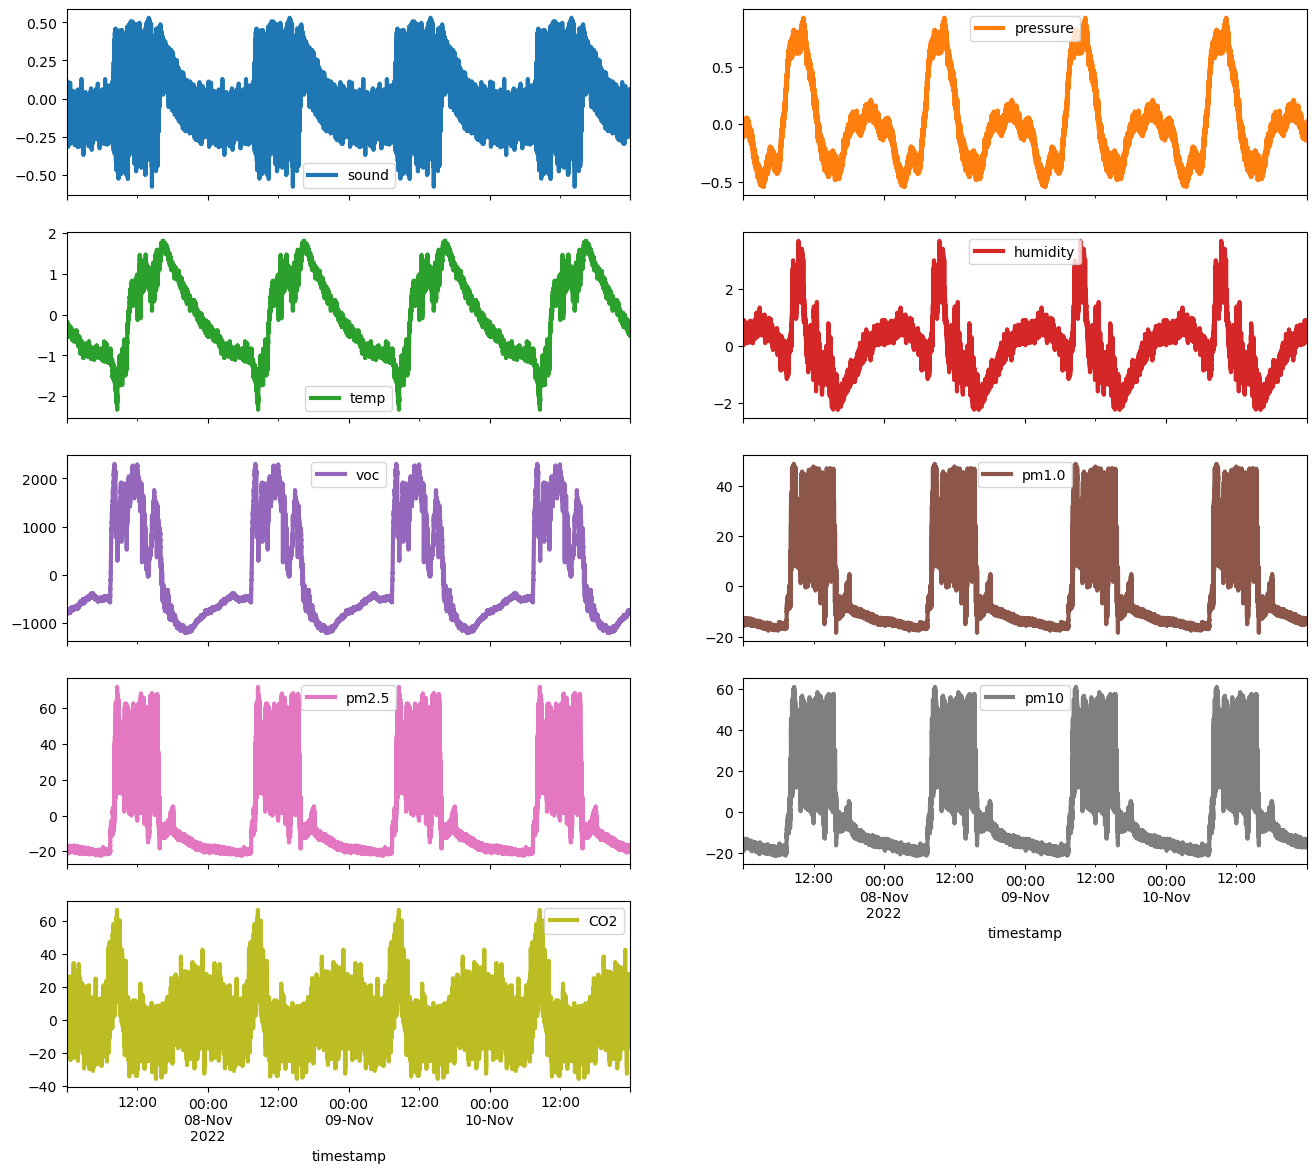

In [5]:
seasonality_dict = {}

for ts in data.columns:
    decompositions = seasonal_decompose(data[ts], period=60*60*24)
    seasonality_dict[ts] = decompositions.seasonal

pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(5, 2), linewidth=3, figsize=(16, 14));

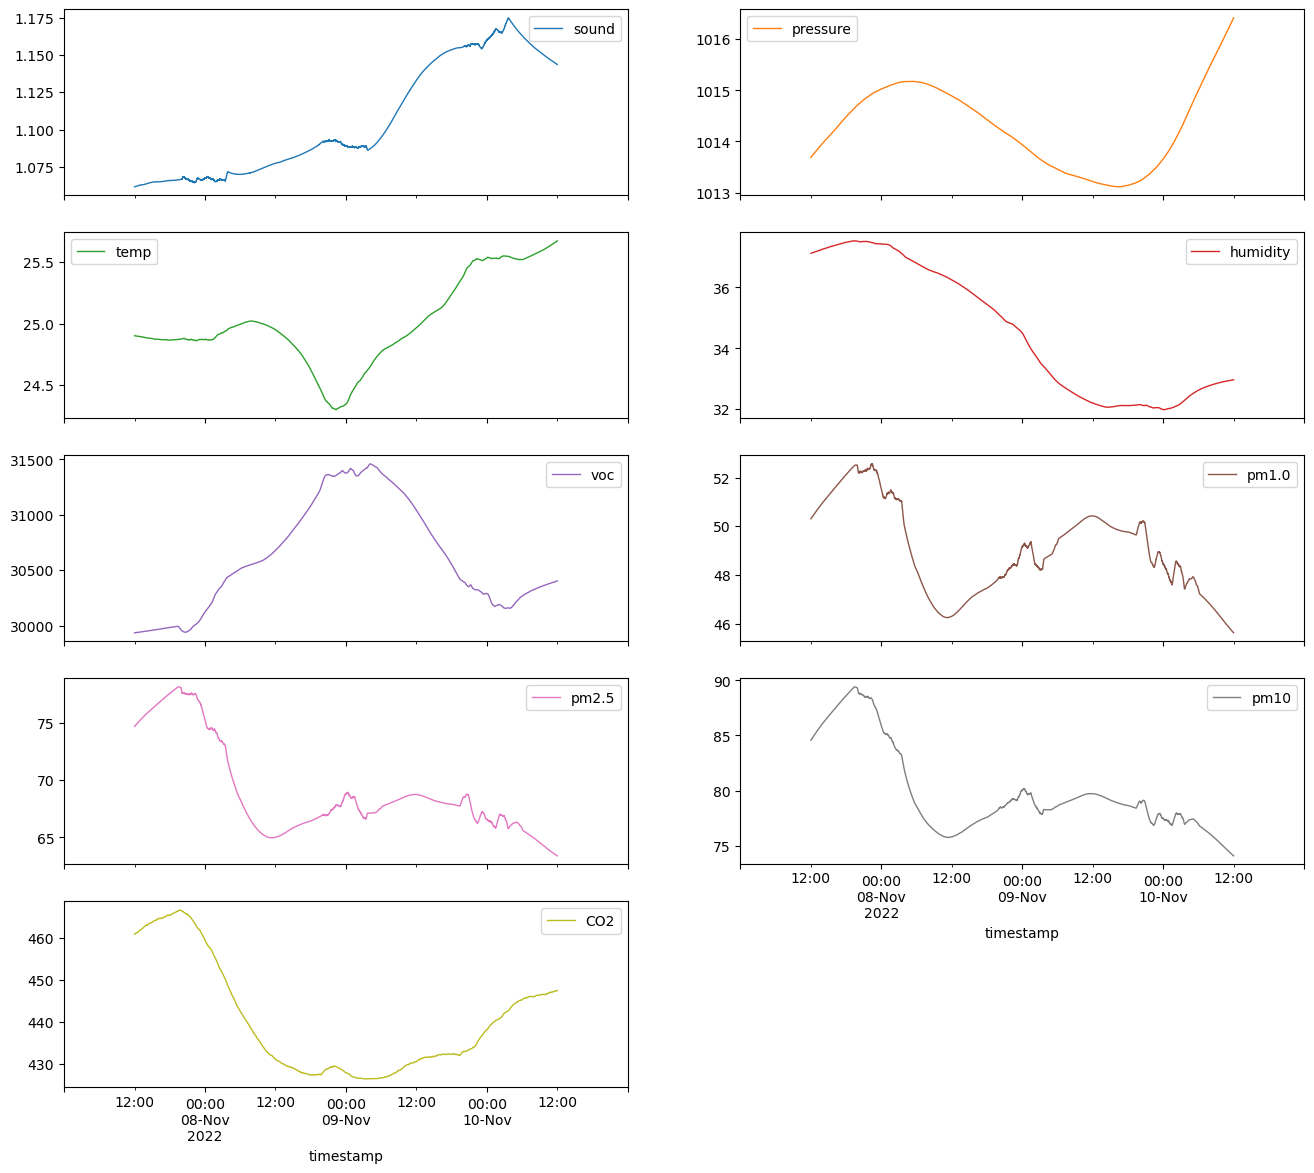

In [4]:
trend_dict = {}

for ts in data.columns:
    decomposition = seasonal_decompose(data[ts], period=60*60*24)
    trend_dict[ts] = decomposition.trend

pd.DataFrame(trend_dict).plot(subplots=True, layout=(5, 2), linewidth=1, figsize=(16, 14));

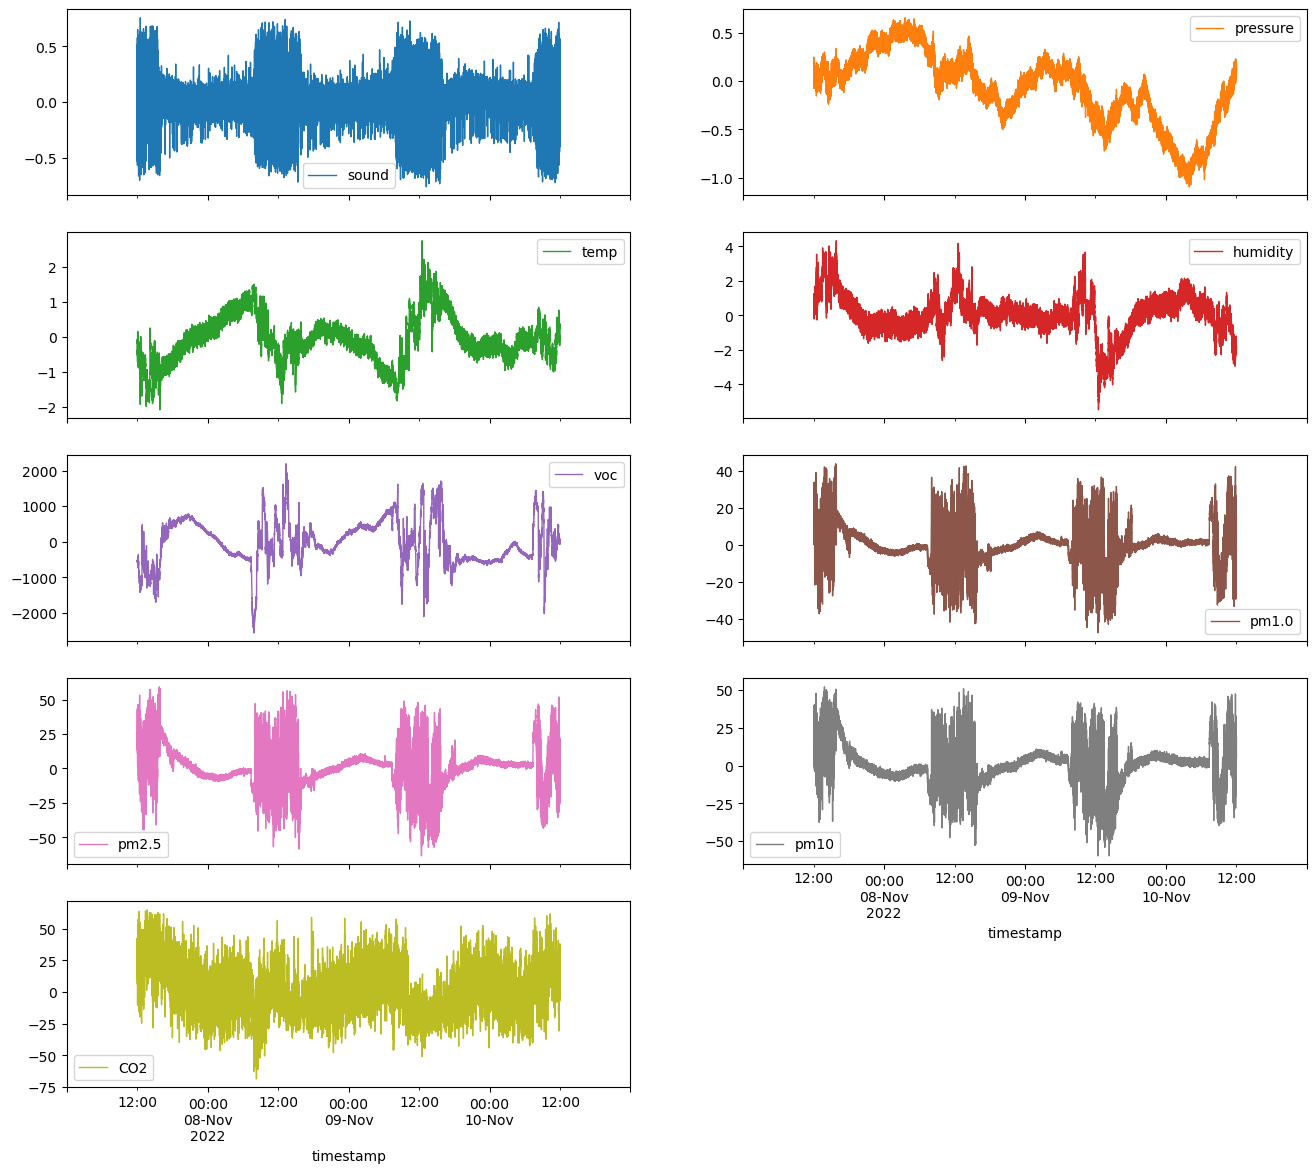

In [59]:
resid_dict = {}

for ts in data.columns:
    decomposition = seasonal_decompose(data[ts], period=60*60*24)
    resid_dict[ts] = decomposition.resid

pd.DataFrame(resid_dict).plot(subplots=True, layout=(5, 2), linewidth=1, figsize=(16, 14));

In [26]:
data_resample_30s = data.resample('30S').asfreq().interpolate(method='linear').dropna()

In [6]:
for i, feature in enumerate(data_resample_30s):
    X = data_resample_30s[feature].values
    result = adfuller(X)

    print(feature + ':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

sound:
ADF Statistic: -5.061661
p-value: 0.000017
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pressure:
ADF Statistic: 0.265307
p-value: 0.975696
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is not stationary
temp:
ADF Statistic: -2.250531
p-value: 0.188419
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is not stationary
humidity:
ADF Statistic: -2.238137
p-value: 0.192696
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is not stationary
voc:
ADF Statistic: -3.819268
p-value: 0.002716
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pm1.0:
ADF Statistic: -4.258816
p-value: 0.000523
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pm2.5:
ADF Statistic: -4.010484
p-value: 0.001357
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pm10:
ADF Statistic: -3.835

In [8]:
for i, feature in enumerate(data_resample_30s):
    X = data_resample_30s[feature].values
    result = kpss(X, regression='c', nlags="auto")

    print(feature + ':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))
        
    print(f'Result: The series is {"not " if result[1] < 0.05 else ""}stationary')

sound:
ADF Statistic: 2.851452
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
pressure:
ADF Statistic: 4.551273
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
temp:
ADF Statistic: 2.571637
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
humidity:
ADF Statistic: 11.578782
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
voc:
ADF Statistic: 1.037348
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
pm1.0:
ADF Statistic: 0.267672
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
pm2.5:
ADF Statistic: 0.469213
p-value: 0.048601
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.57

C:\Users\ivana\AppData\Local\Temp\ipykernel_29152\657501338.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X, regression='c', nlags="auto")
C:\Users\ivana\AppData\Local\Temp\ipykernel_29152\657501338.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X, regression='c', nlags="auto")
C:\Users\ivana\AppData\Local\Temp\ipykernel_29152\657501338.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X, regression='c', nlags="auto")
C:\Users\ivana\AppData\Local\Temp\ipykernel_29152\657501338.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available i

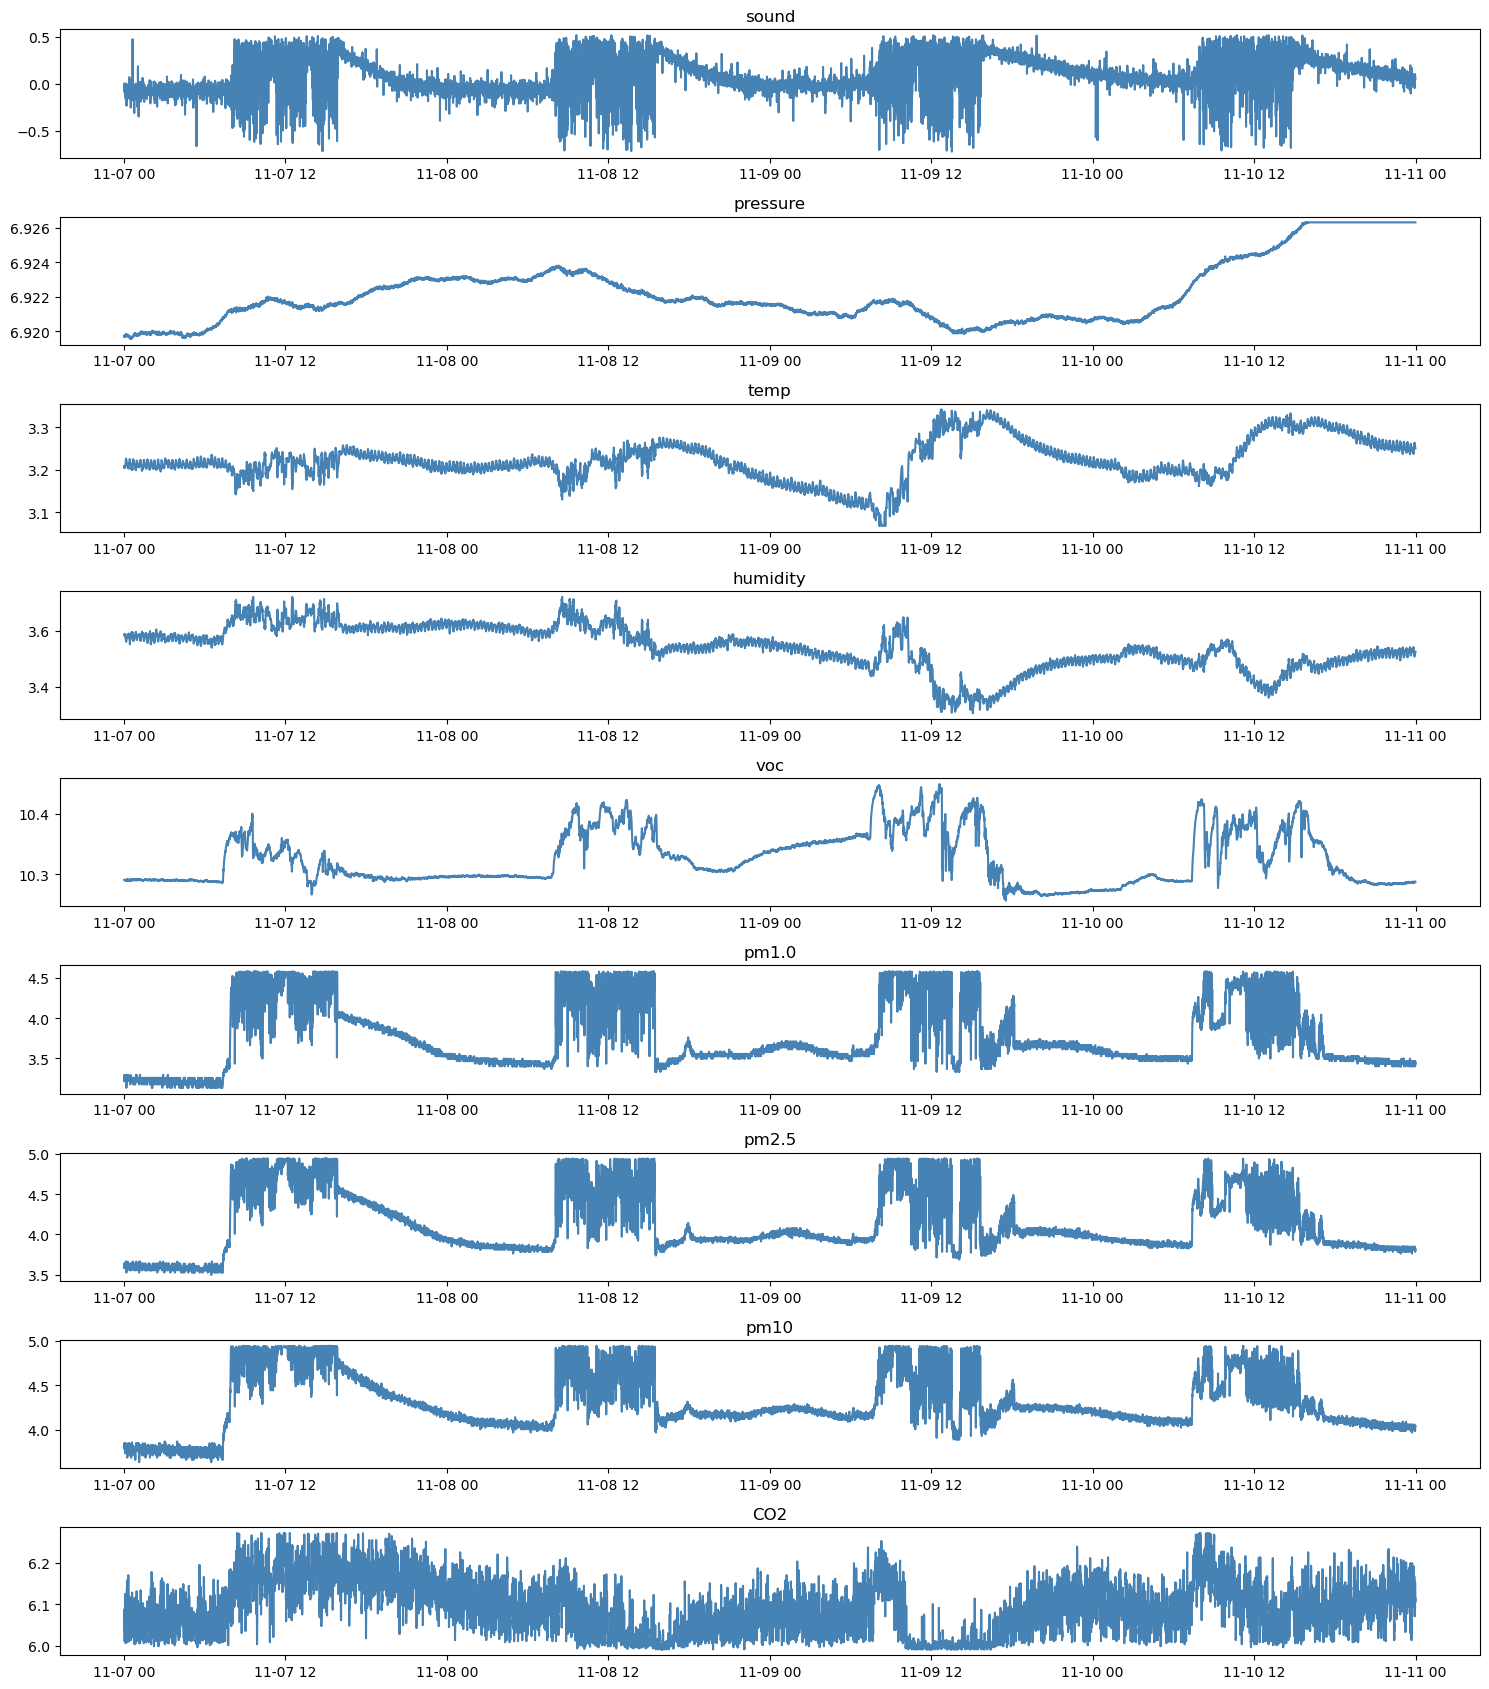

In [3]:
plt.figure(figsize=(15, 17))

for i, feature in enumerate(data_resample_30s):
    data_resample_30s[feature] = np.log(data_resample_30s[feature].values)
    plt.subplot(9, 1, i+1)
    plt.title(feature)
    plt.plot(data_resample_30s.index, data_resample_30s[feature].values, color="steelblue")

plt.tight_layout()

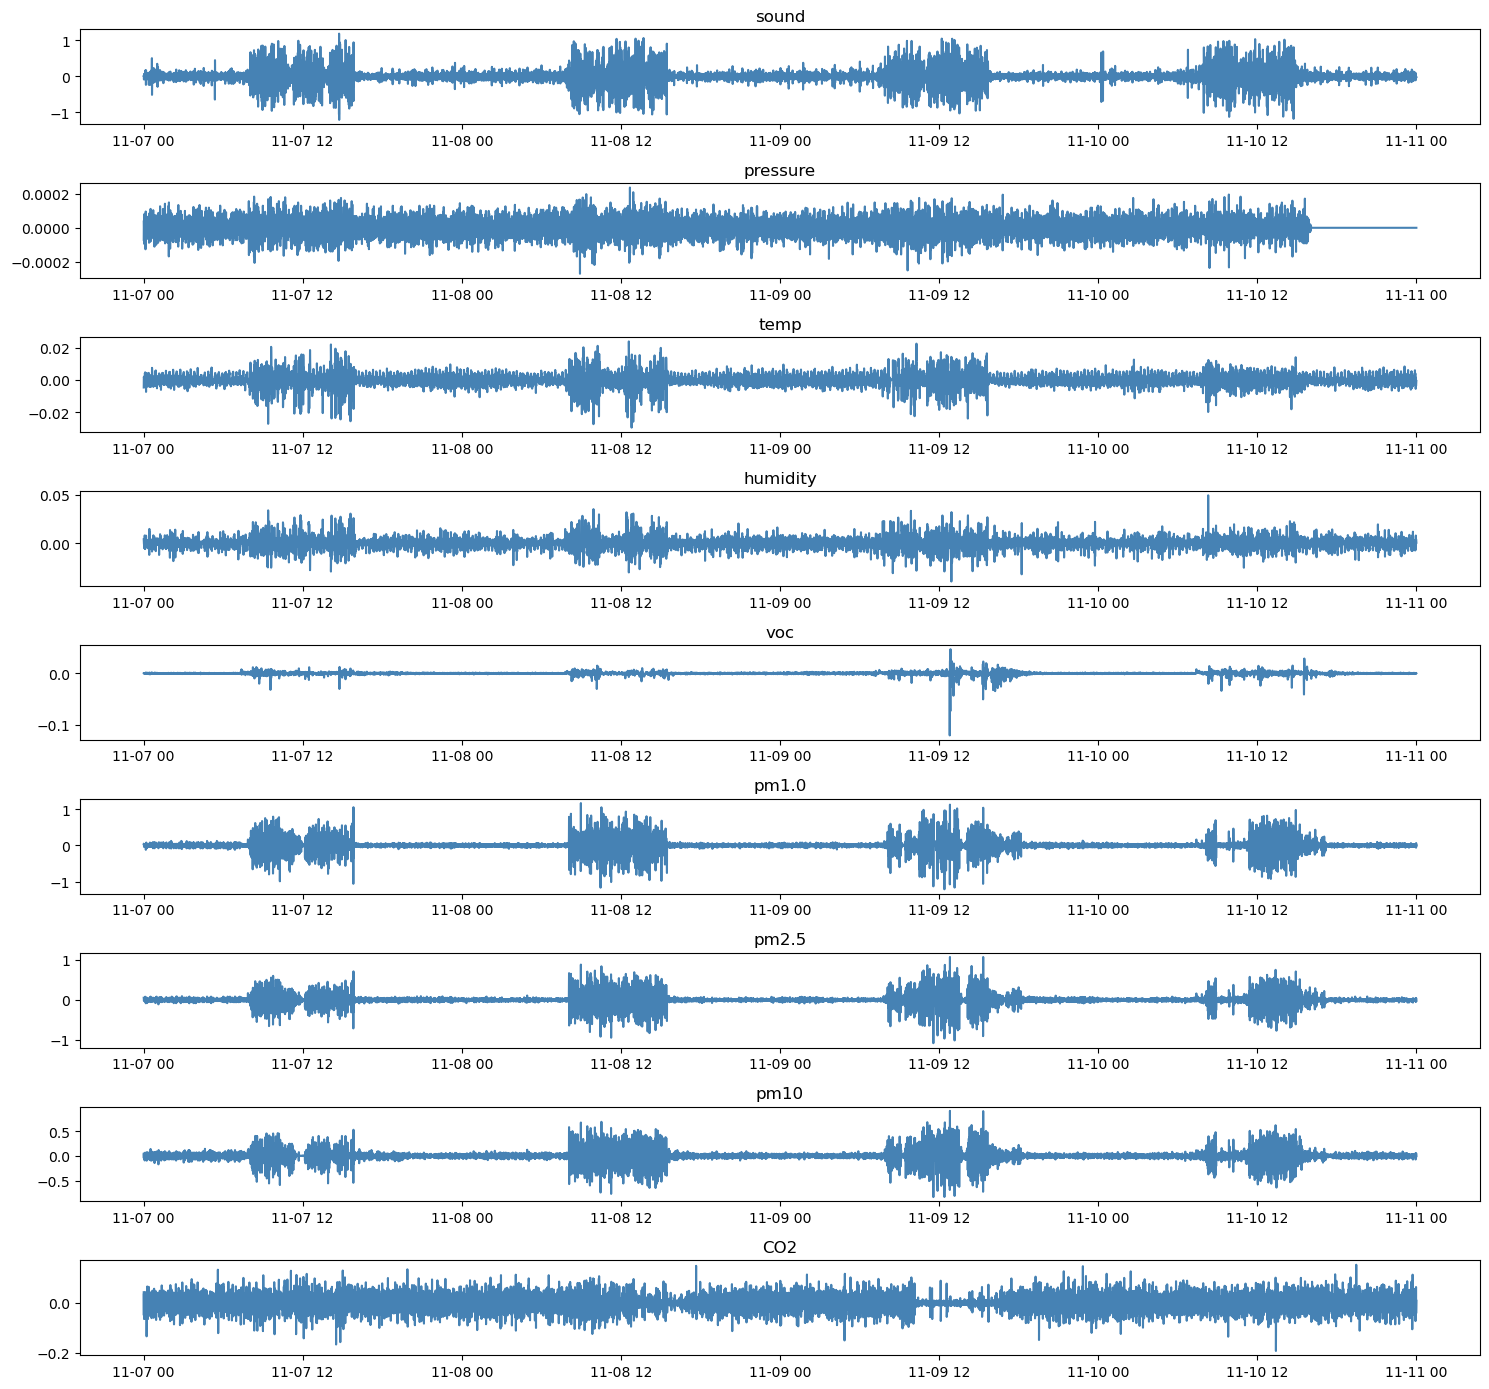

In [4]:
plt.figure(figsize=(15, 14))

for i, feature in enumerate(data_resample_30s):
    data_resample_30s[feature] = data_resample_30s[feature].diff()
    plt.subplot(9, 1, i+1)
    plt.title(feature)
    plt.plot(data_resample_30s.index, data_resample_30s[feature].values, color="steelblue")

plt.tight_layout()
data_resample_30s = data_resample_30s.dropna()

In [49]:
for i, feature in enumerate(data_resample_30s):
    X = data_resample_30s[feature].values
    result = adfuller(X)

    print(feature + ':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

sound:
ADF Statistic: -26.268298
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pressure:
ADF Statistic: -11.994365
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
temp:
ADF Statistic: -19.877535
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
humidity:
ADF Statistic: -18.862702
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
voc:
ADF Statistic: -18.065565
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pm1.0:
ADF Statistic: -19.247133
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pm2.5:
ADF Statistic: -19.607989
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: The series is stationary
pm10:
ADF Statistic: -20.104579

In [50]:
for i, feature in enumerate(data_resample_30s):
    X = data_resample_30s[feature].values
    result = kpss(X, regression='c', nlags="auto")

    print(feature + ':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))
        
    print(f'Result: The series is {"not " if result[1] < 0.05 else ""}stationary')

sound:
ADF Statistic: 0.500000
p-value: 0.041667
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
pressure:
ADF Statistic: 0.634762
p-value: 0.019476
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is not stationary
temp:
ADF Statistic: 0.007355
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
humidity:
ADF Statistic: 0.008664
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
voc:
ADF Statistic: 0.027693
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
pm1.0:
ADF Statistic: 0.035807
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
pm2.5:
ADF Statistic: 0.038938
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [5]:
for i, feature in enumerate(['sound', 'pressure']):
    data_resample_30s[feature] = data_resample_30s[feature].diff()

data_resample_30s = data_resample_30s.dropna()

In [52]:
for i, feature in enumerate(data_resample_30s):
    X = data_resample_30s[feature].values
    result = kpss(X, regression='c', nlags="auto")

    print(feature + ':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))
        
    print(f'Result: The series is {"not " if result[1] < 0.05 else ""}stationary')

sound:
ADF Statistic: 0.035376
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
pressure:
ADF Statistic: 0.024549
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
temp:
ADF Statistic: 0.007246
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
humidity:
ADF Statistic: 0.008609
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
voc:
ADF Statistic: 0.027691
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
pm1.0:
ADF Statistic: 0.034049
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: The series is stationary
pm2.5:
ADF Statistic: 0.036087
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: 

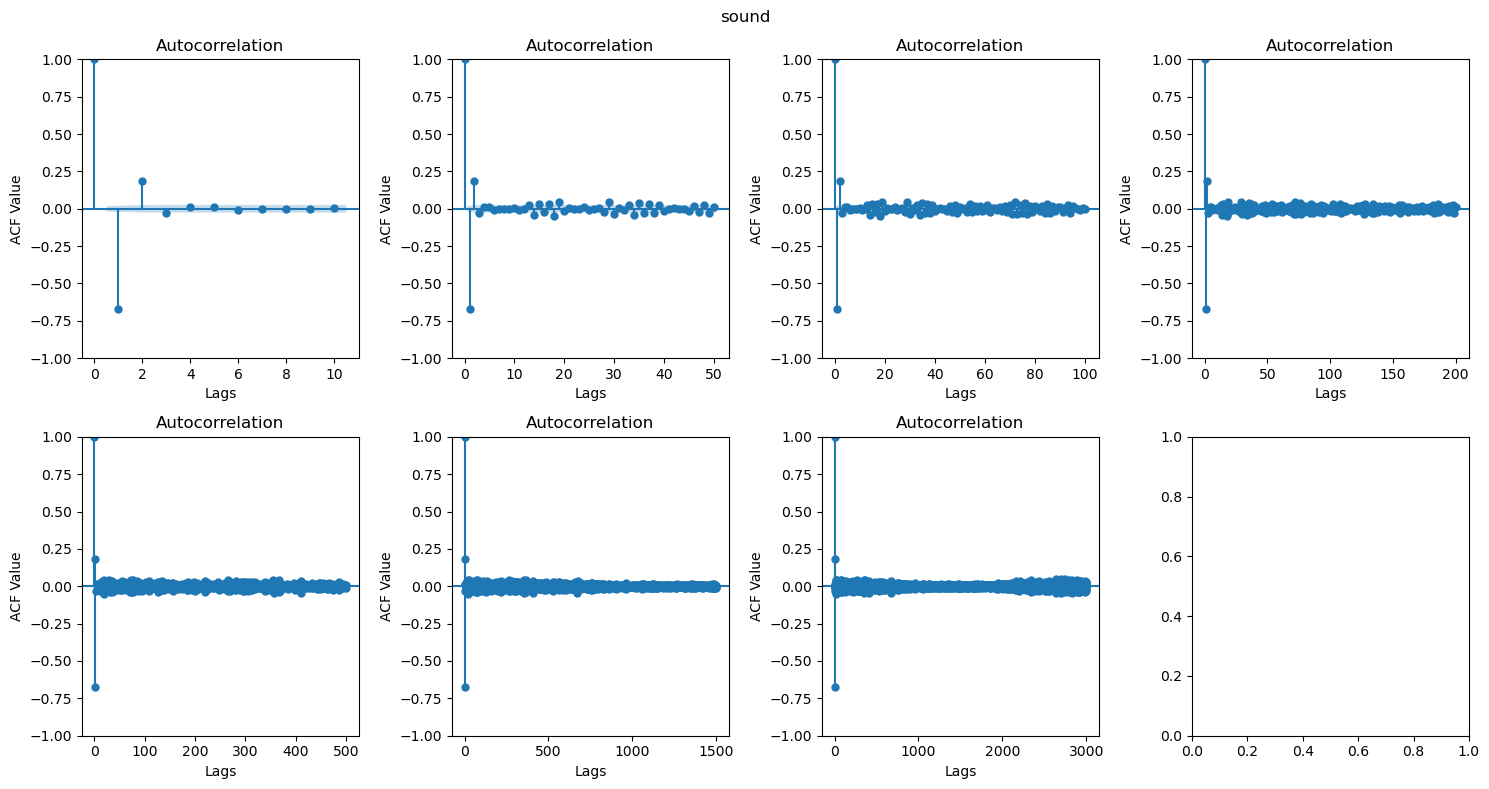

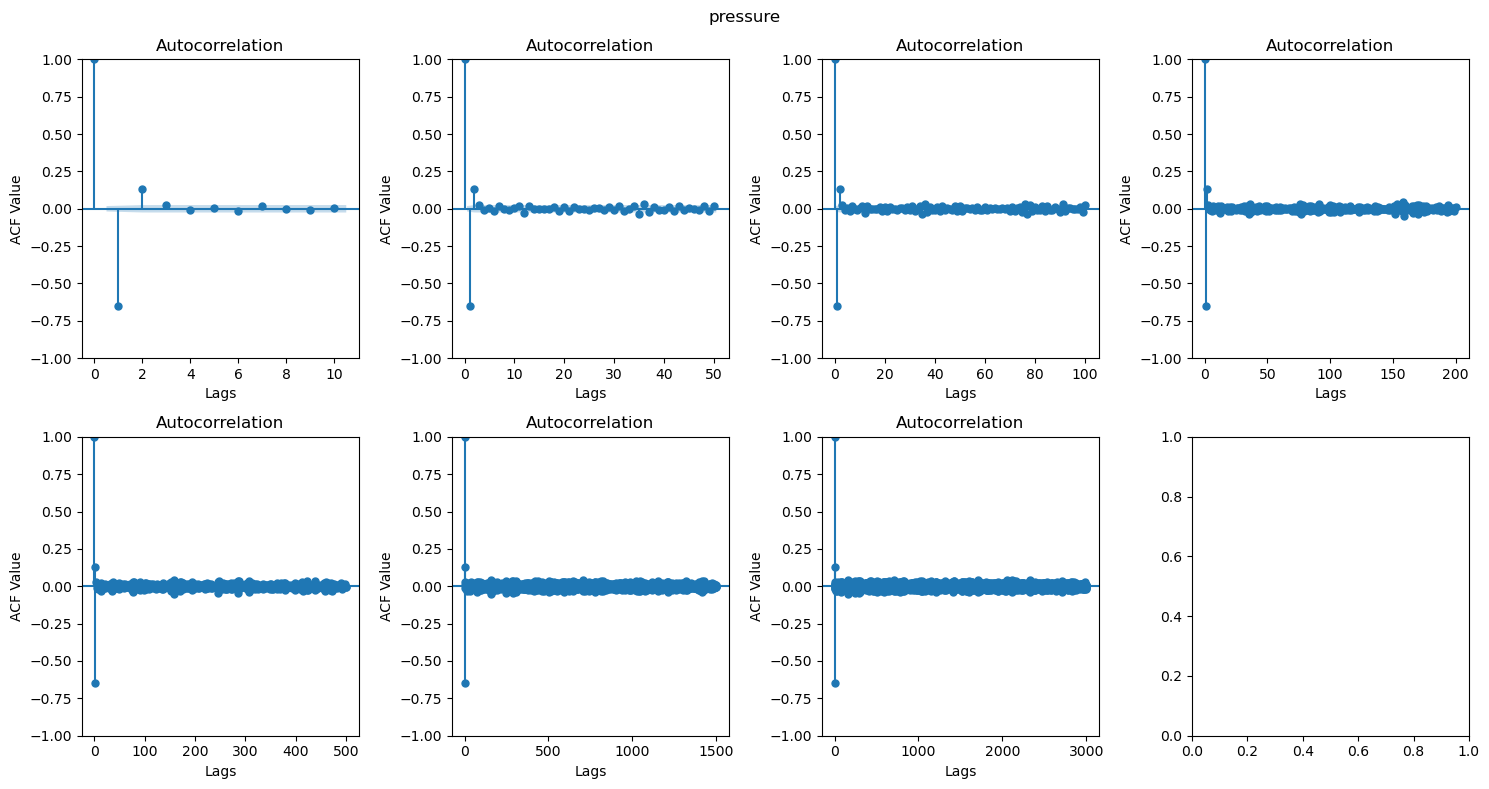

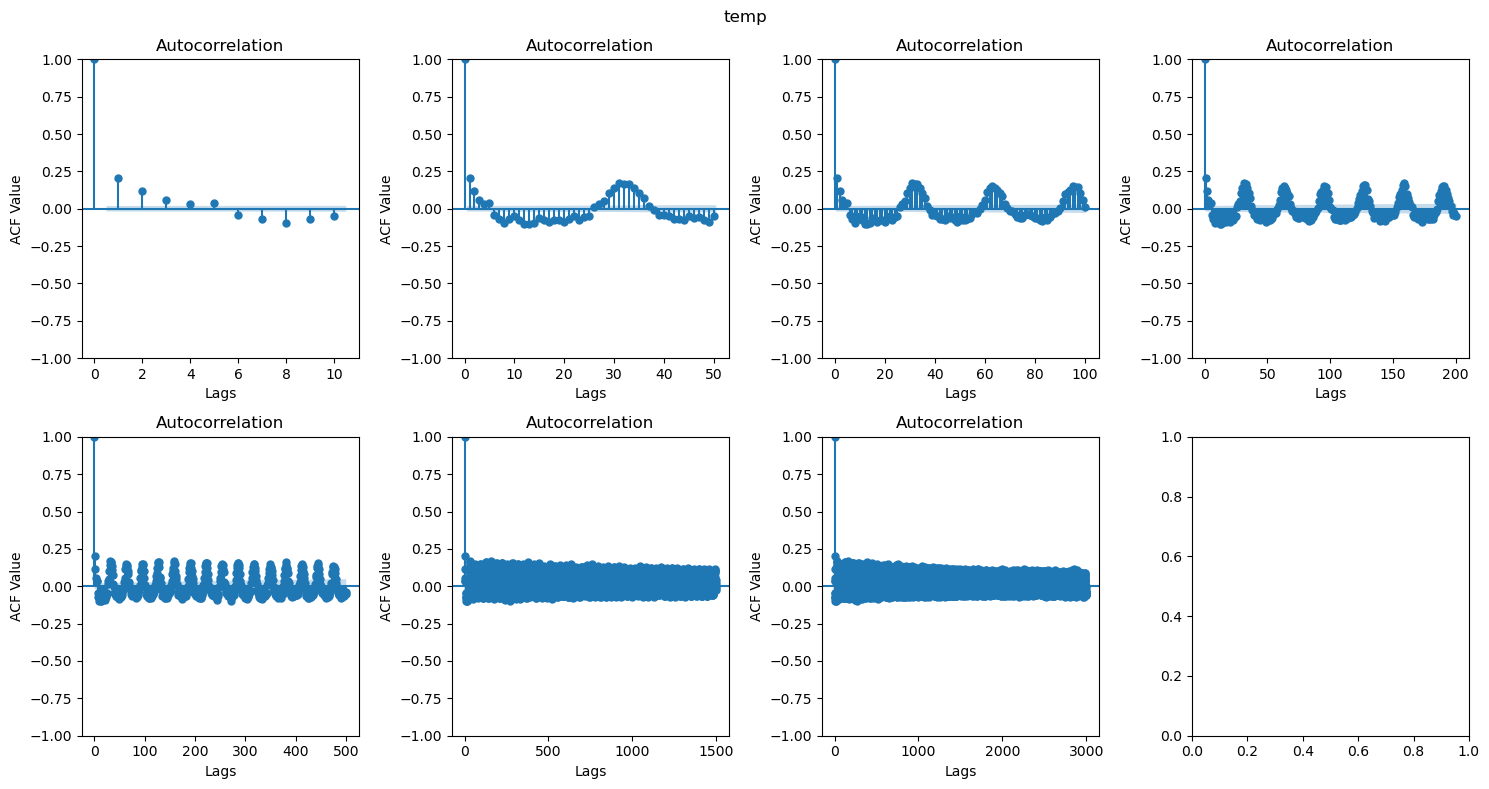

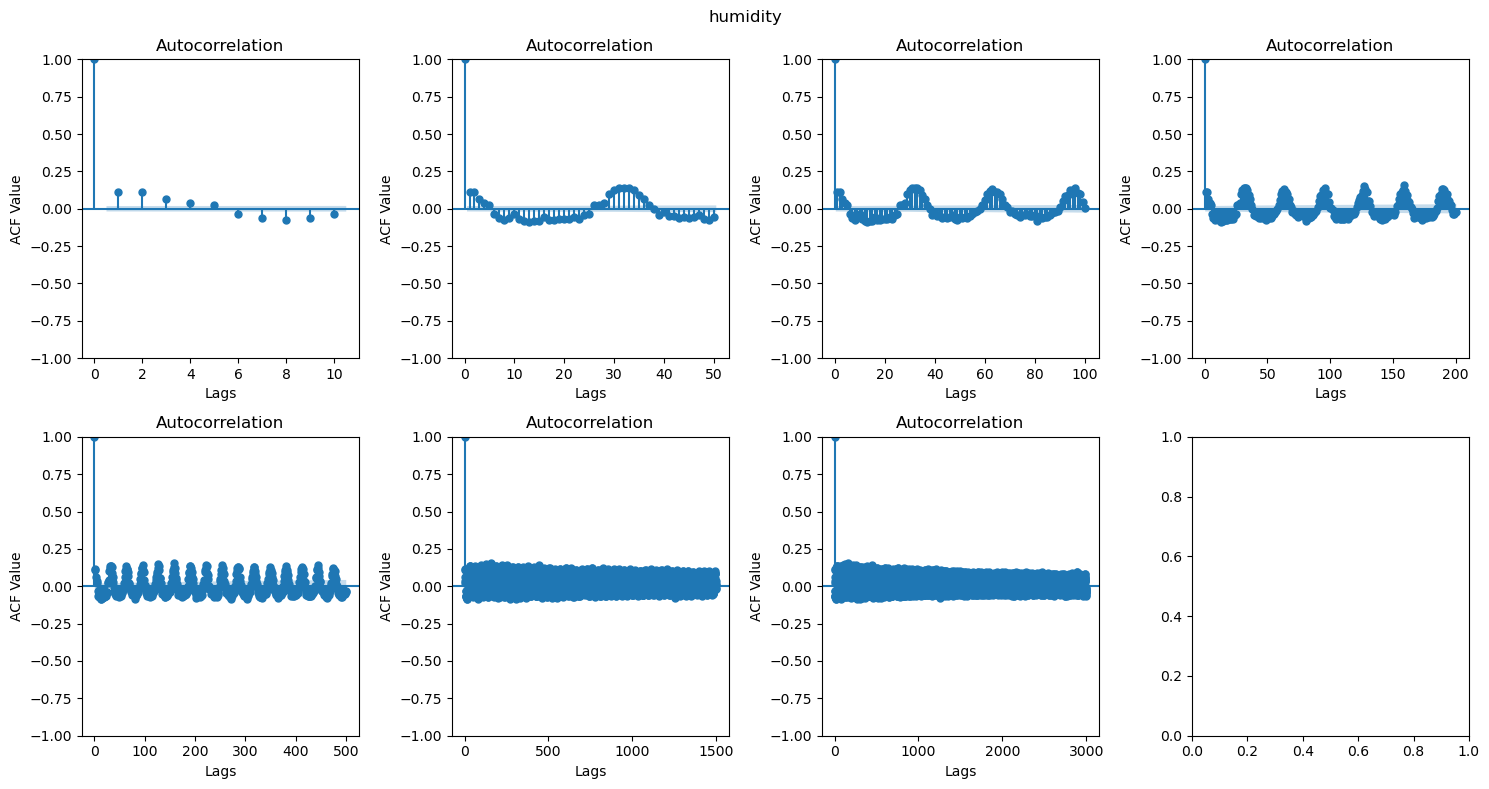

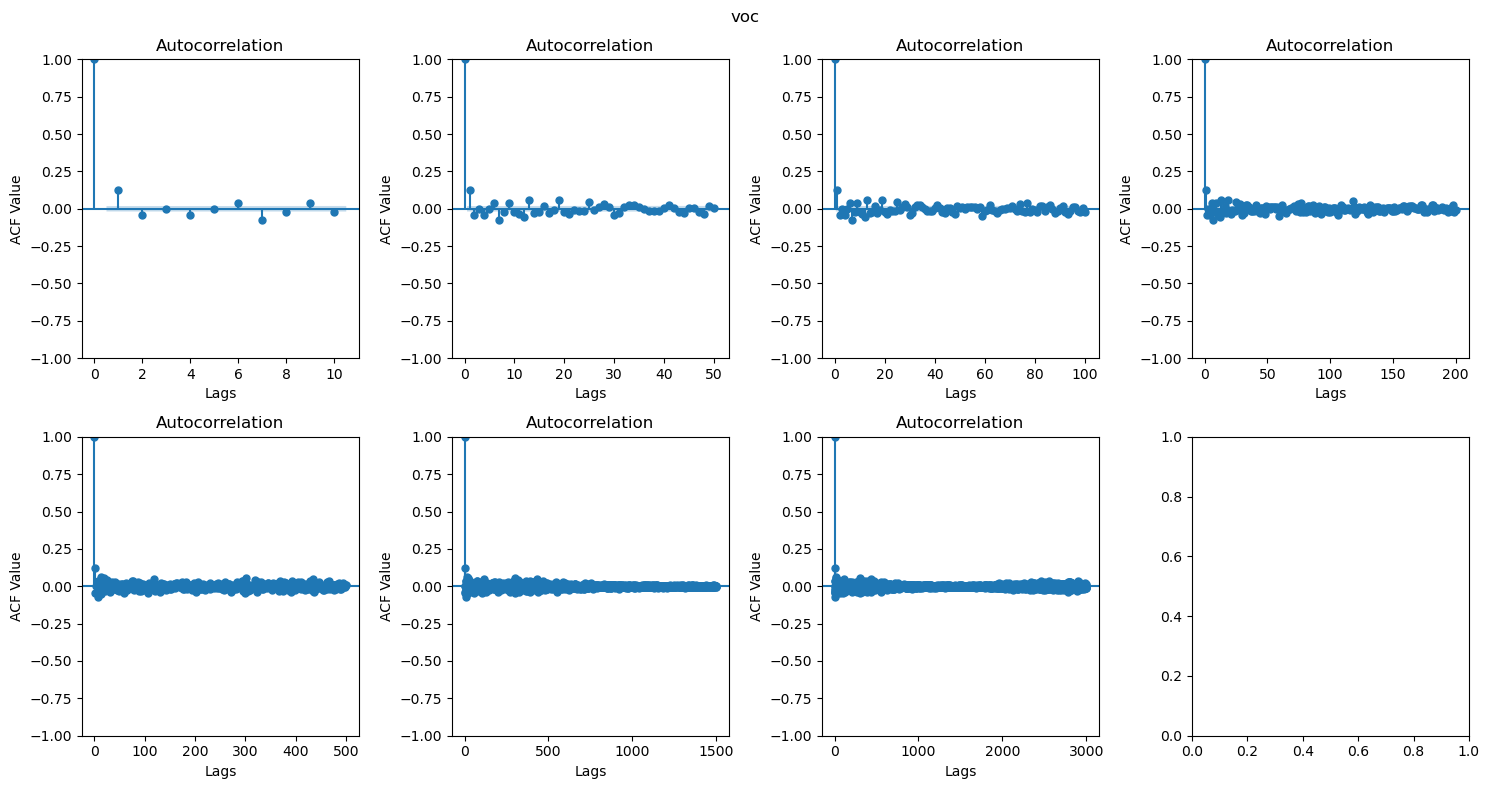

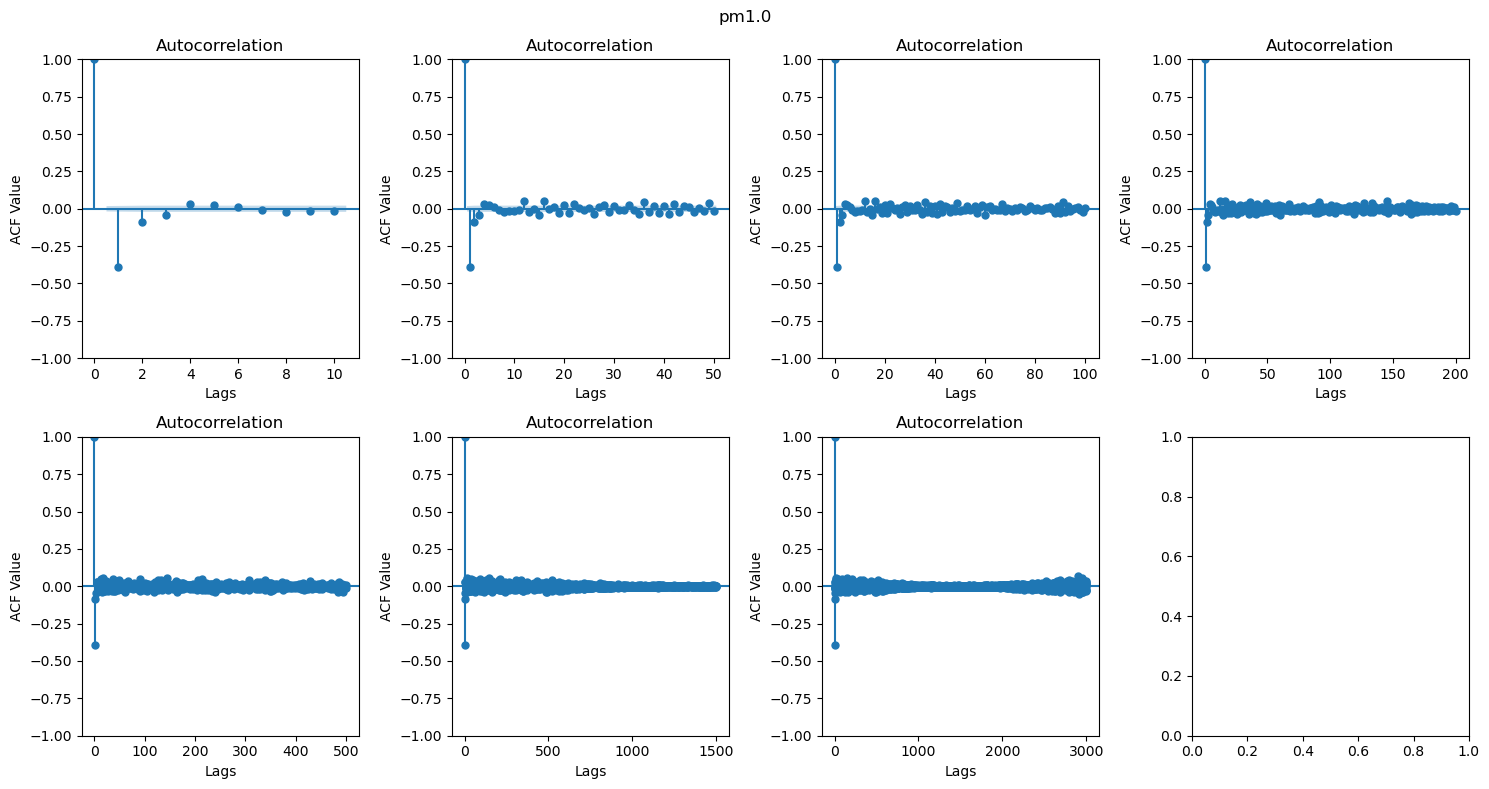

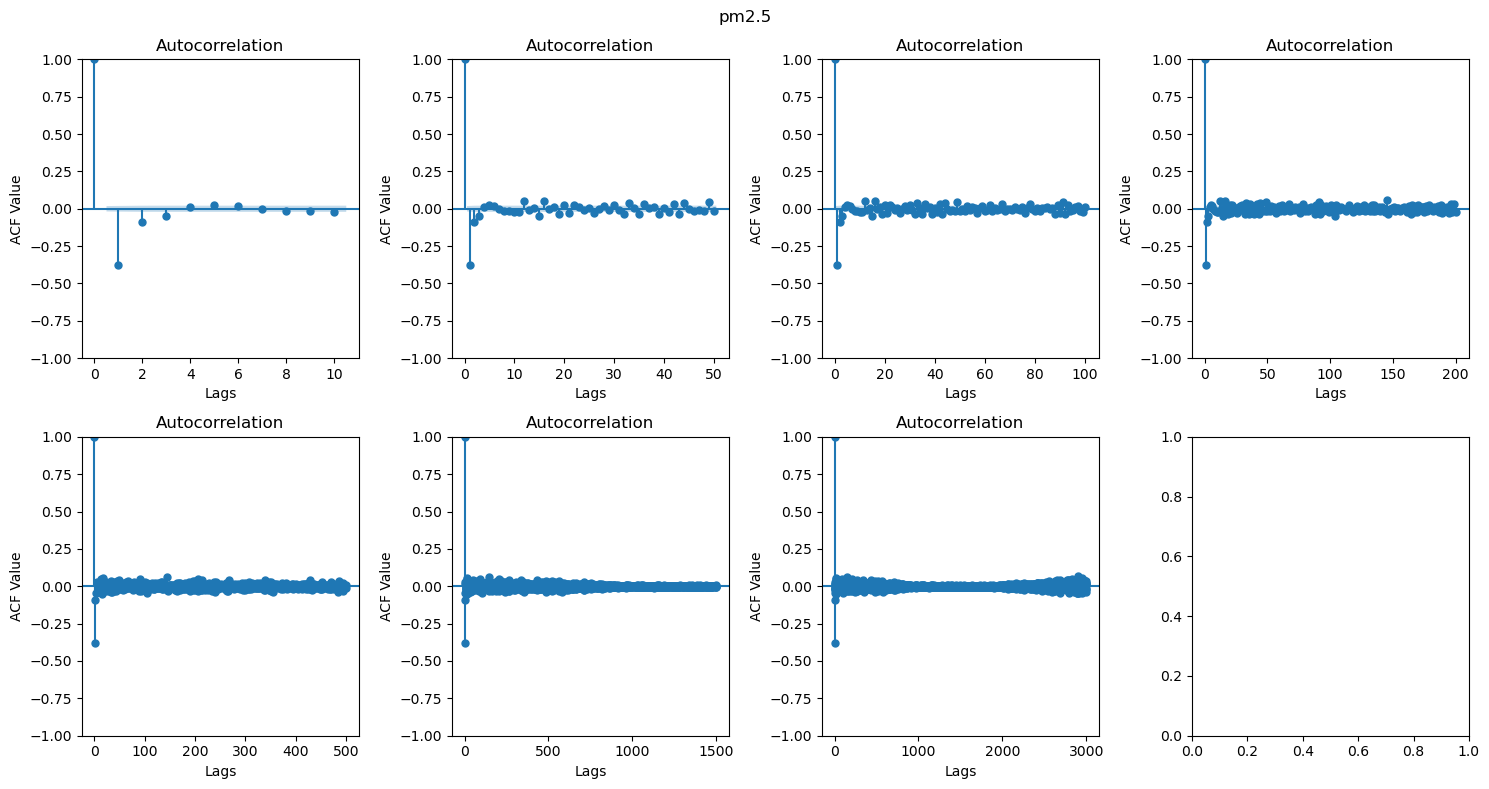

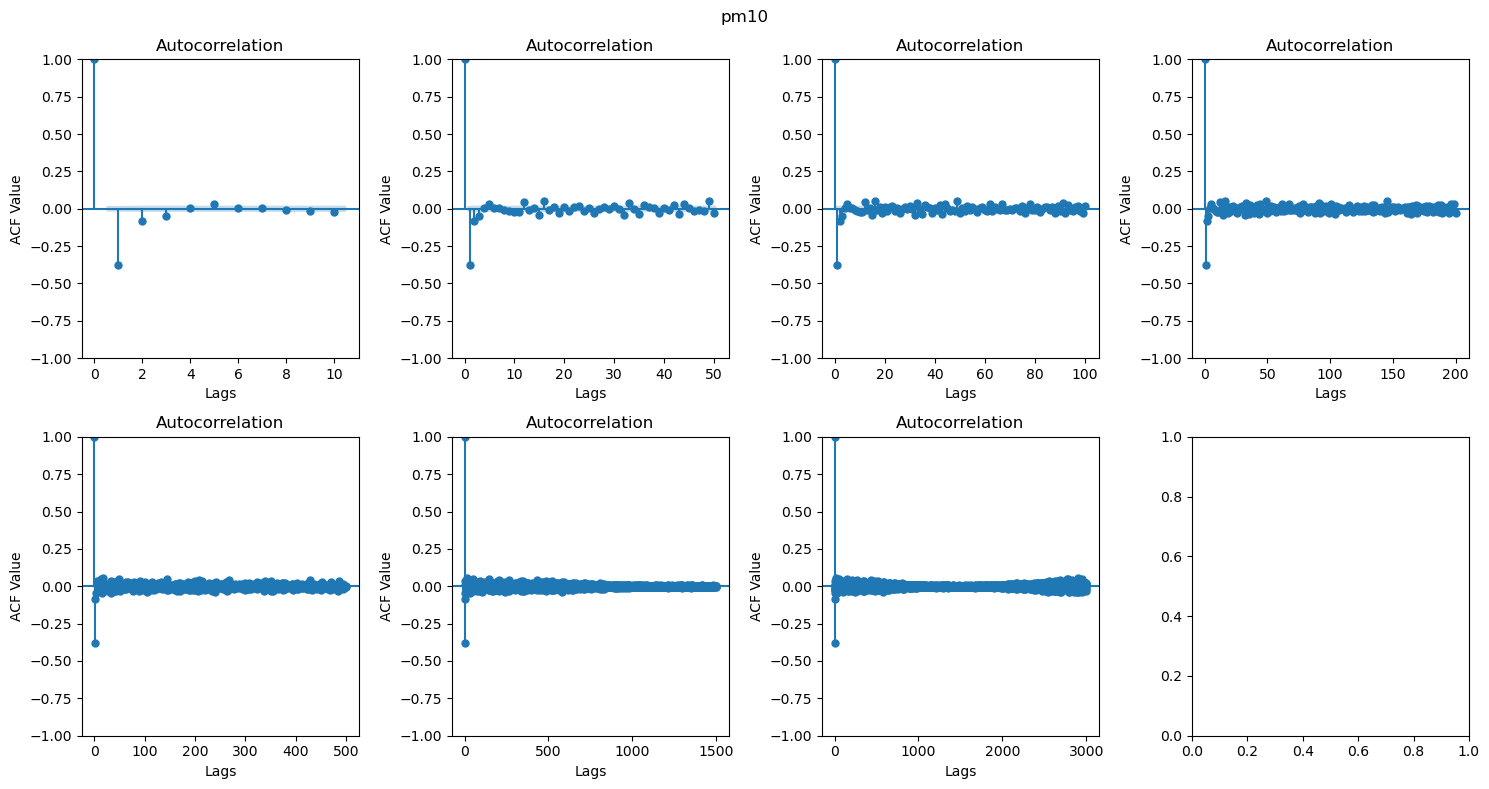

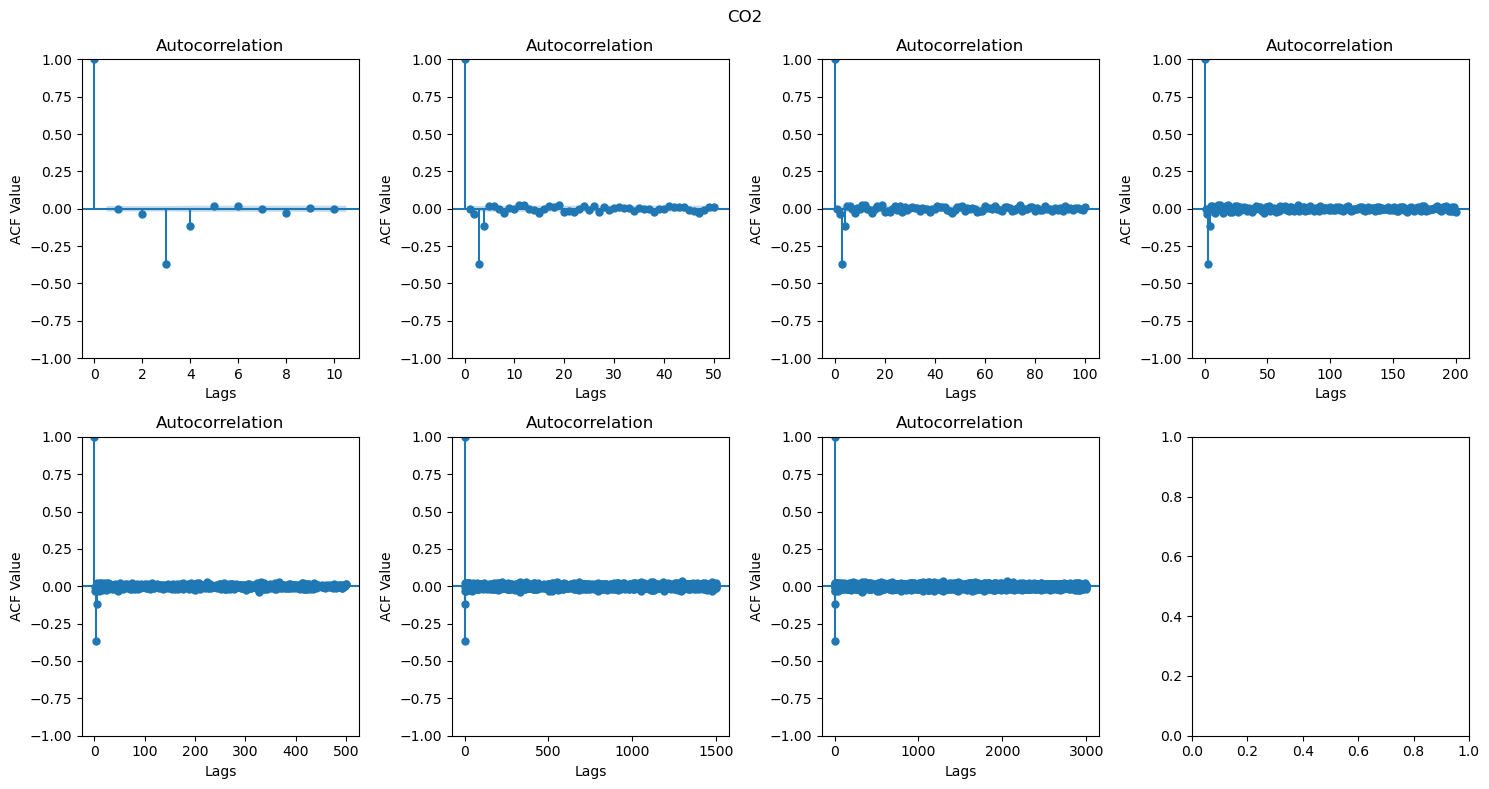

In [9]:
for i, feature in enumerate(data_resample_30s):
    lags = [10, 50, 100, 200, 500, 1500, 3000]

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    fig.suptitle(feature)
    for j, l in enumerate(lags):
        plot_acf(data_resample_30s[feature], lags=l, ax=ax[j//4, j%4])
        ax[j//4, j%4].set_xlabel("Lags")
        ax[j//4, j%4].set_ylabel("ACF Value")
    plt.tight_layout()

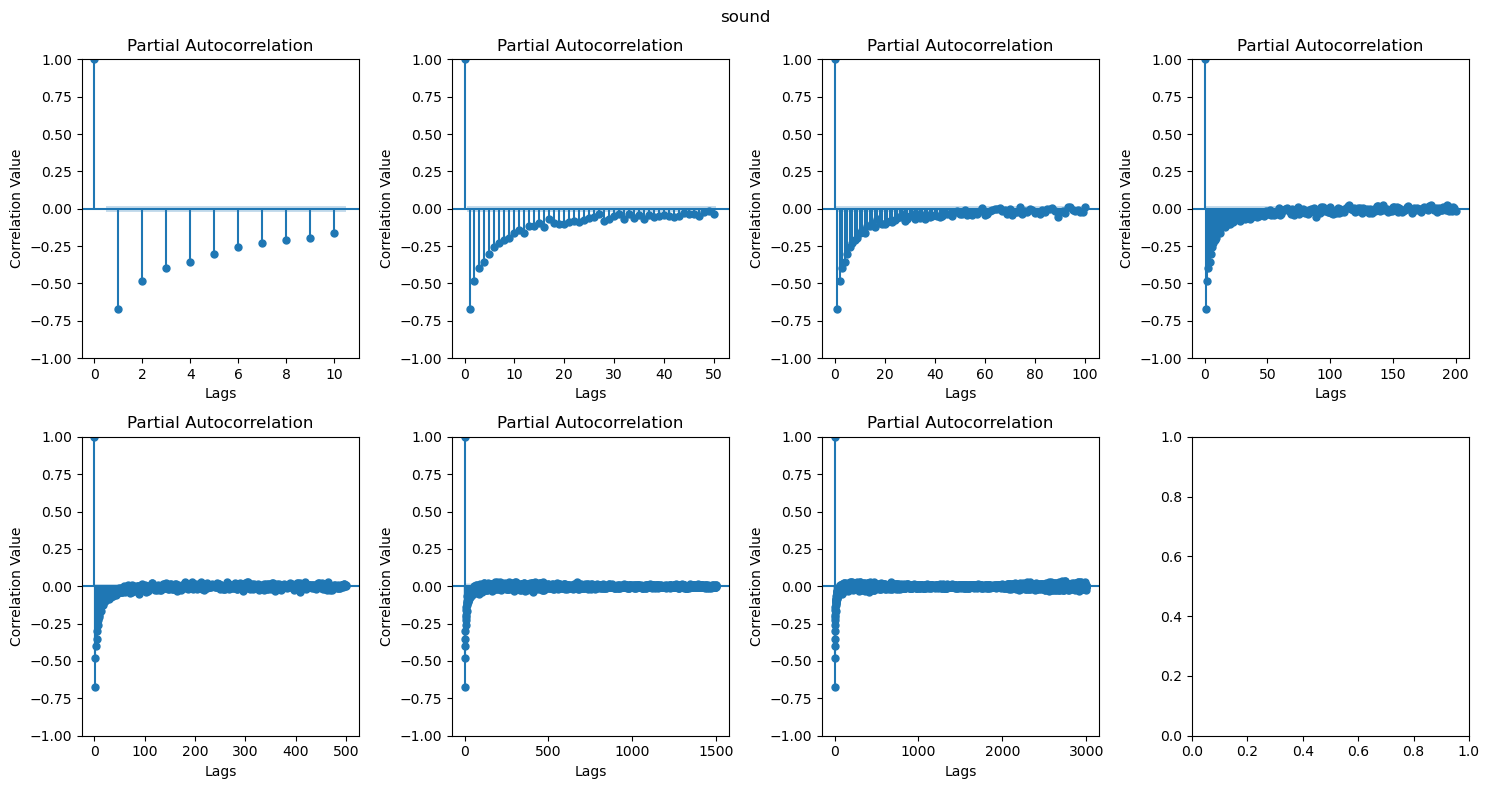

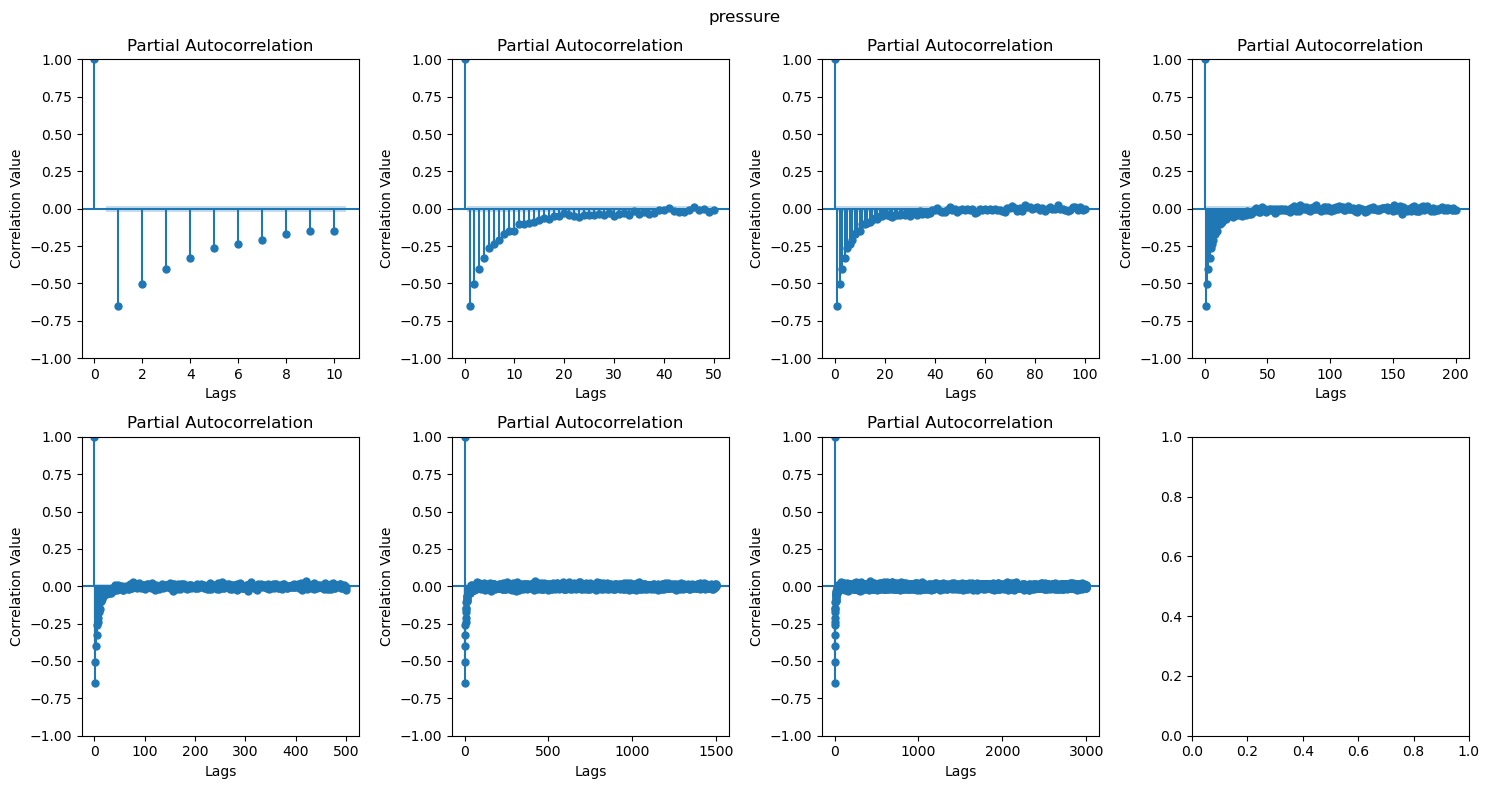

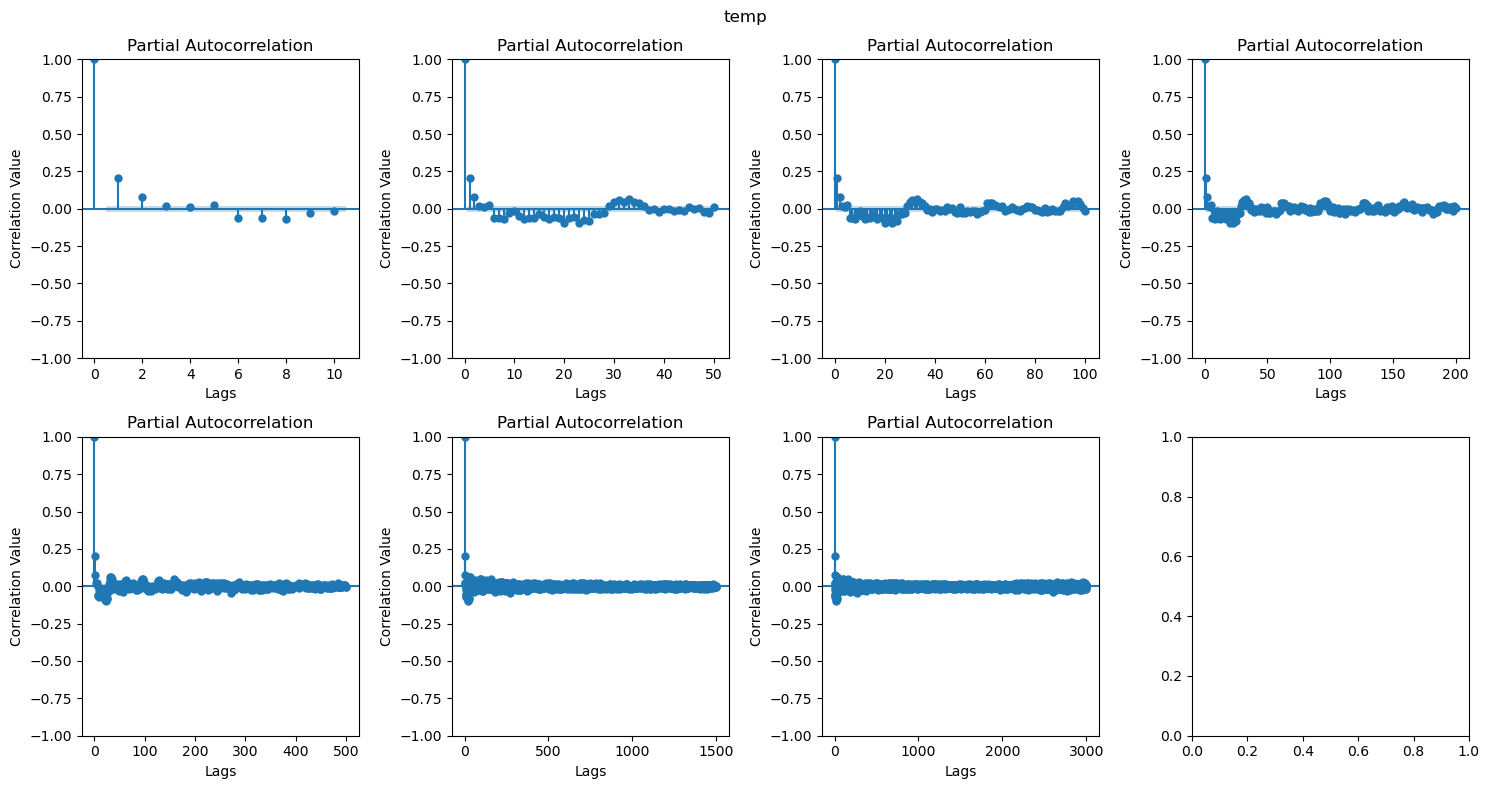

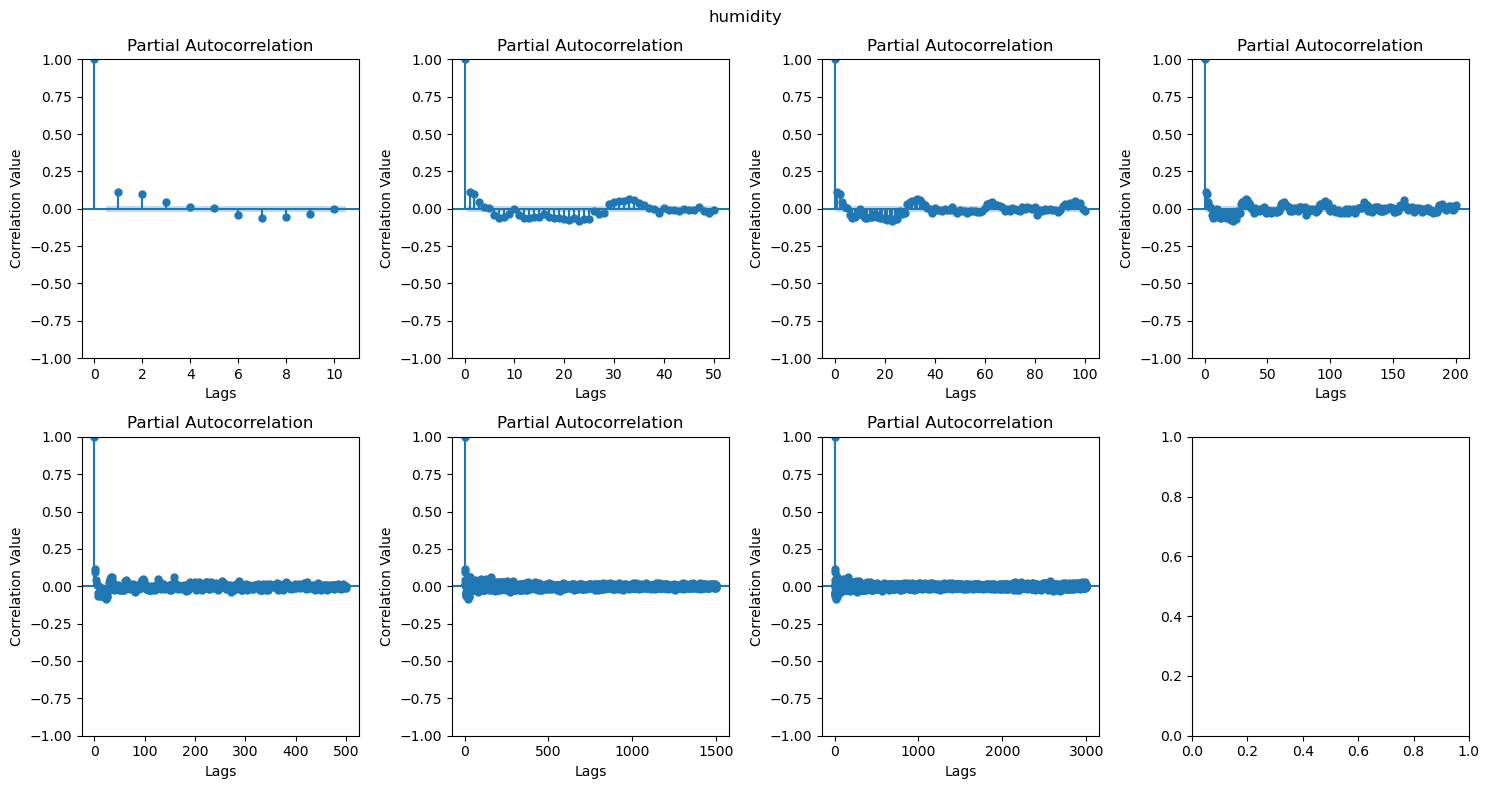

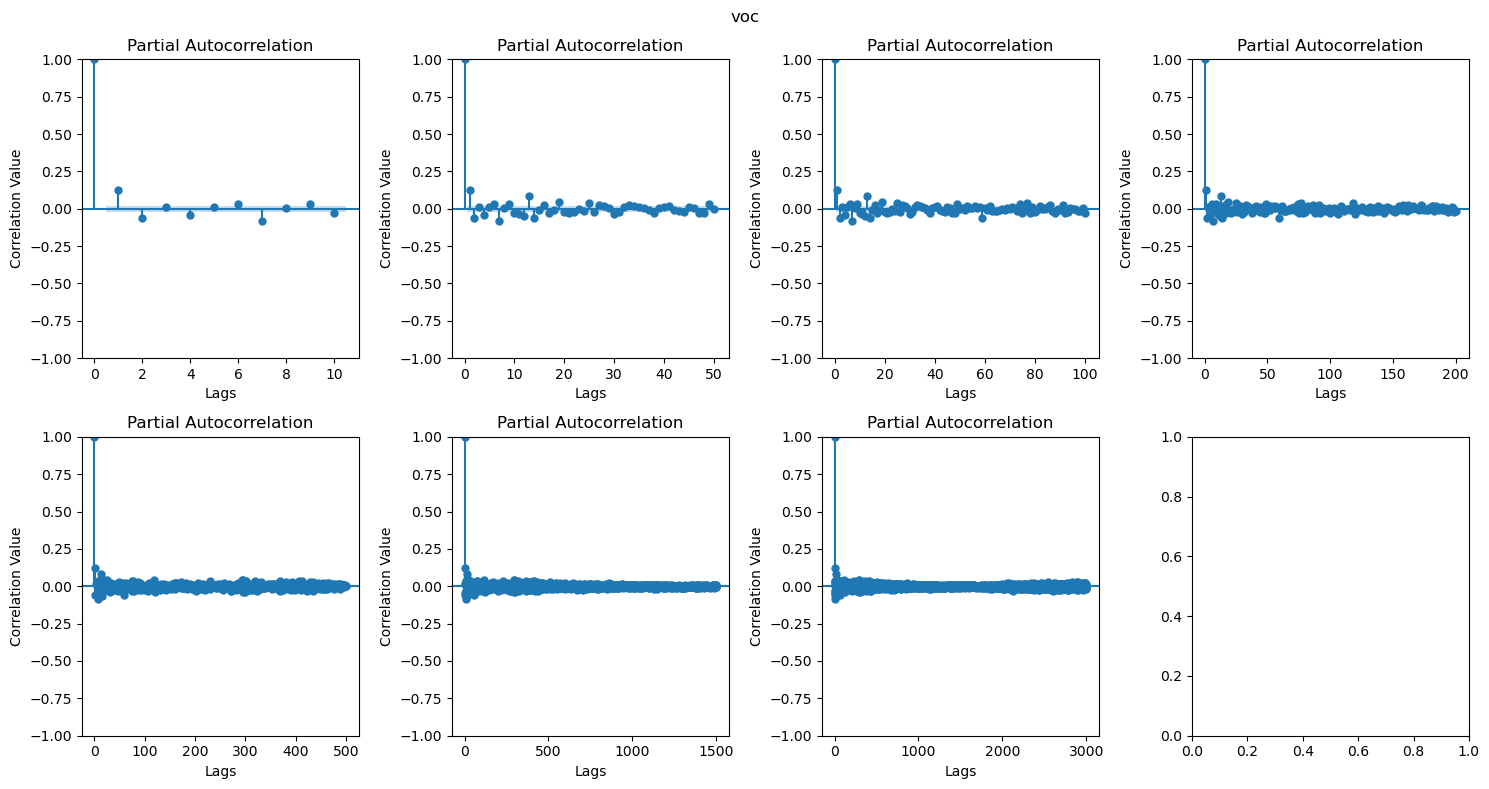

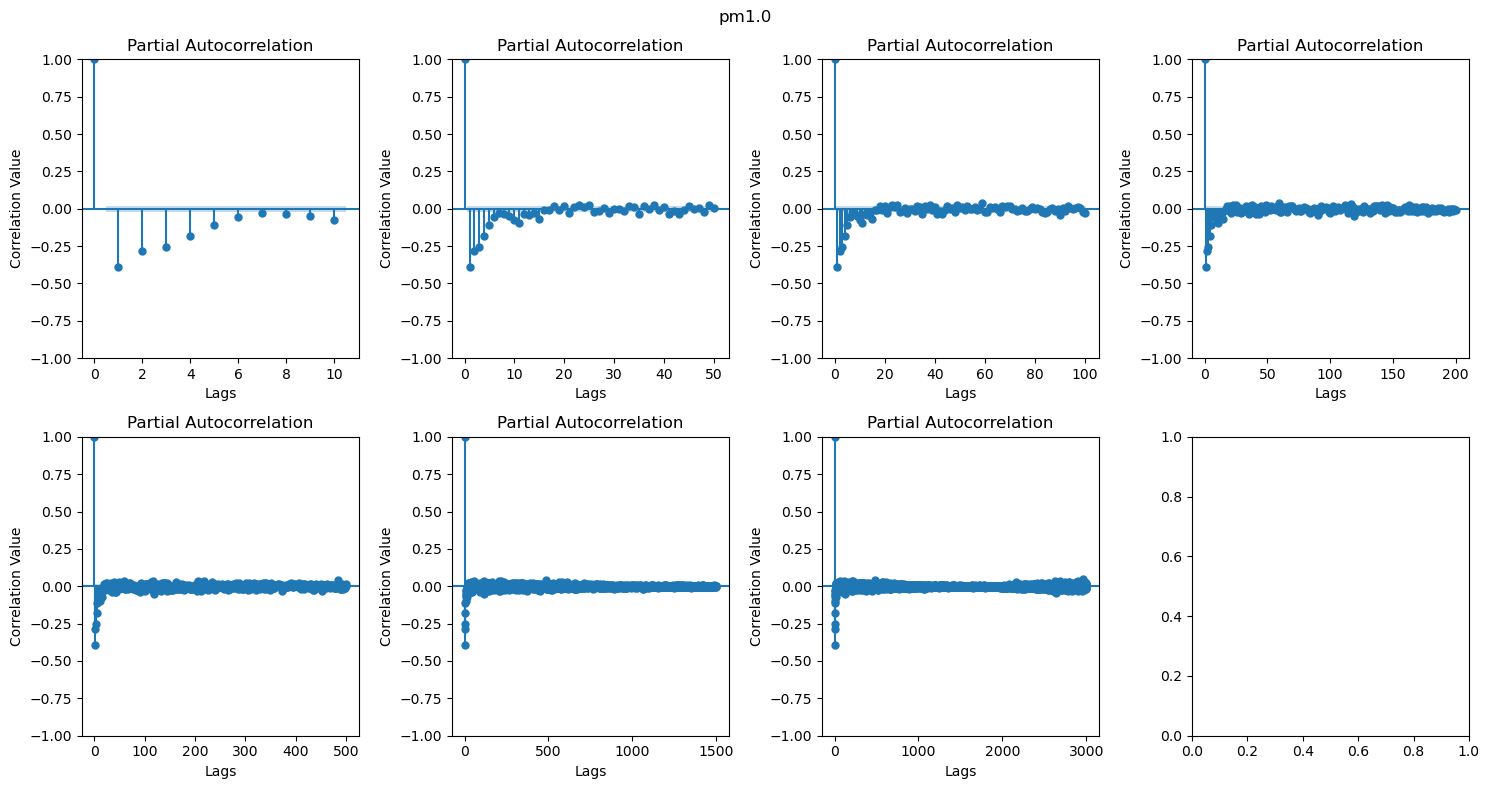

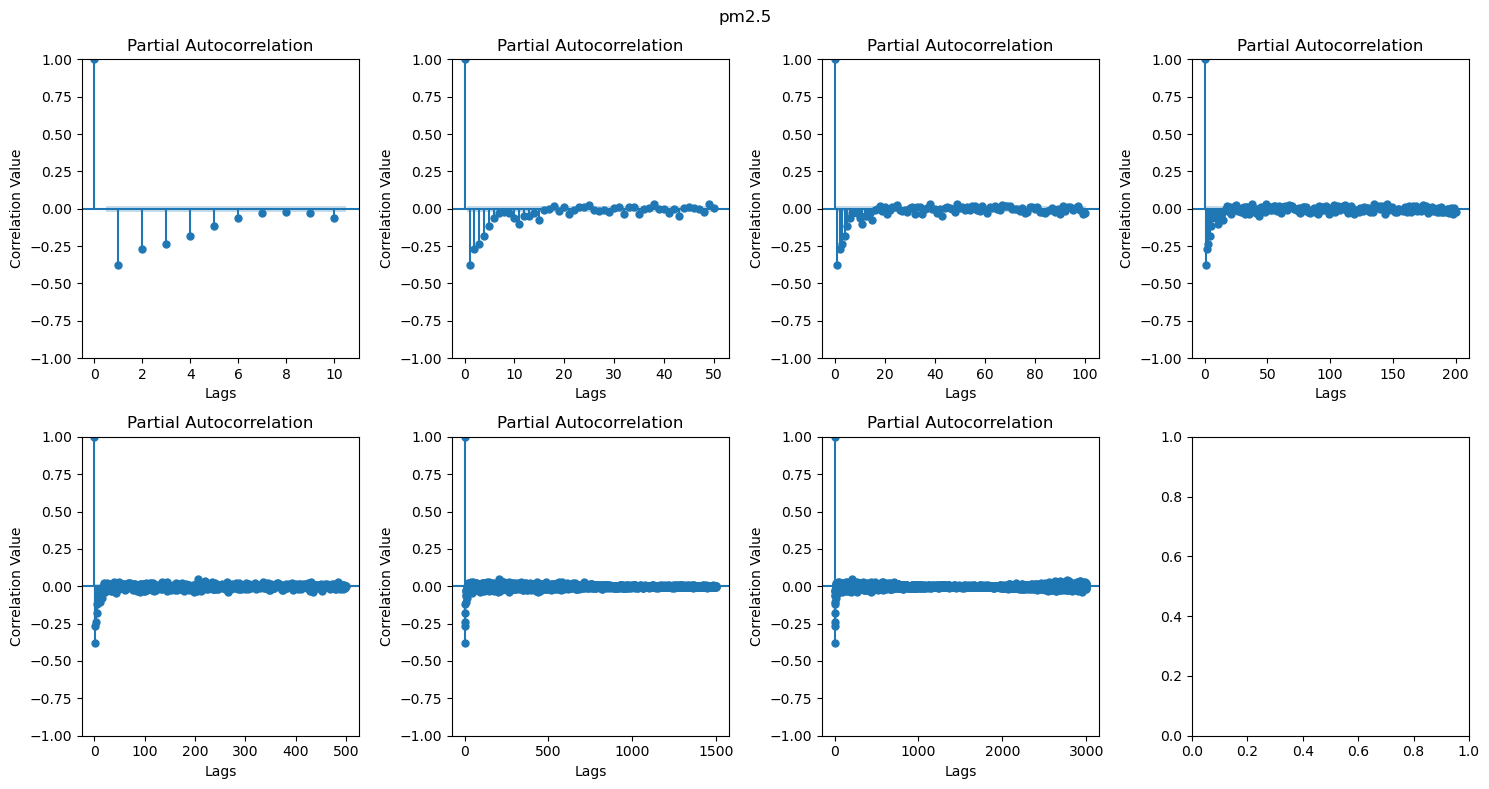

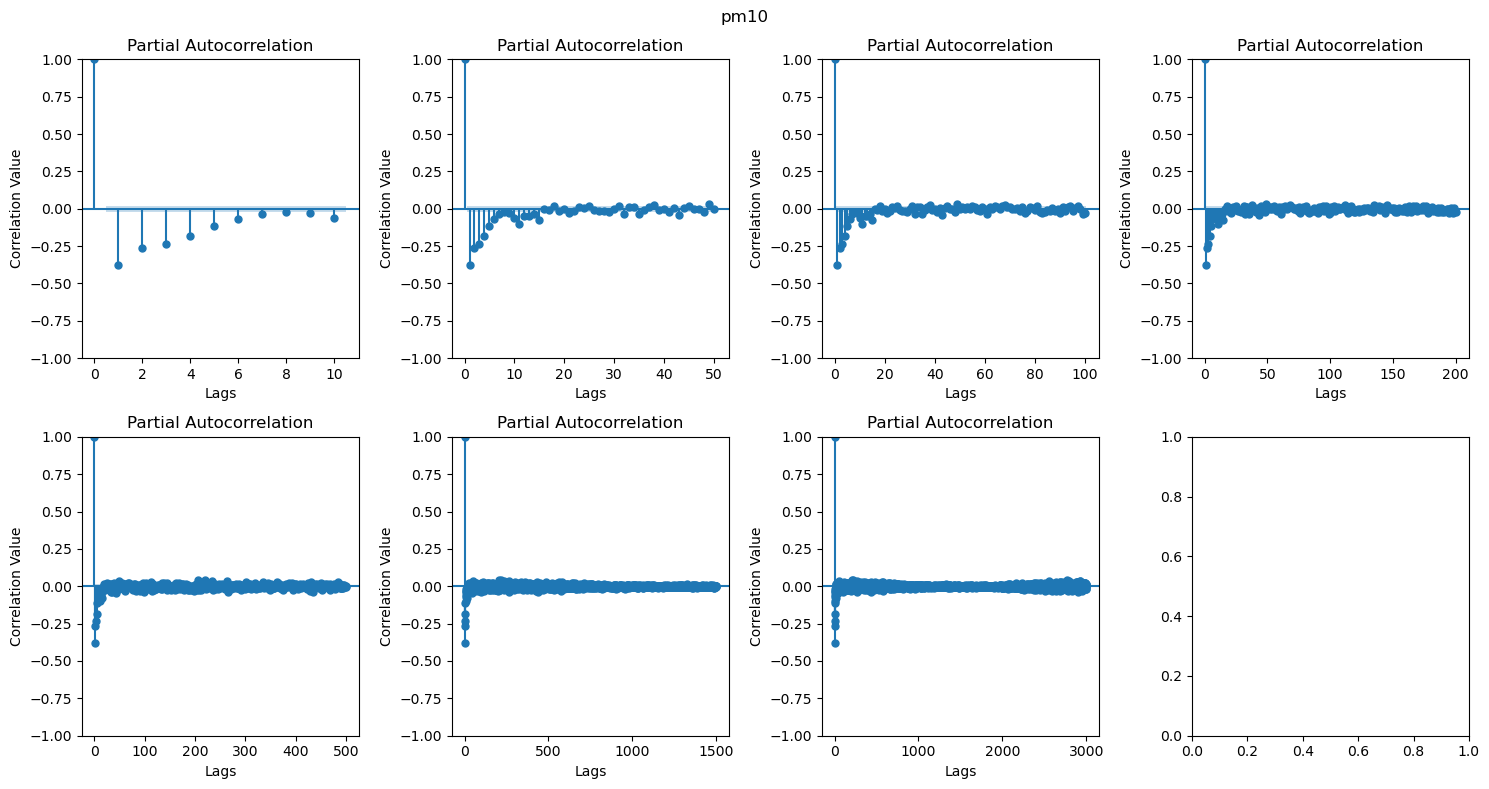

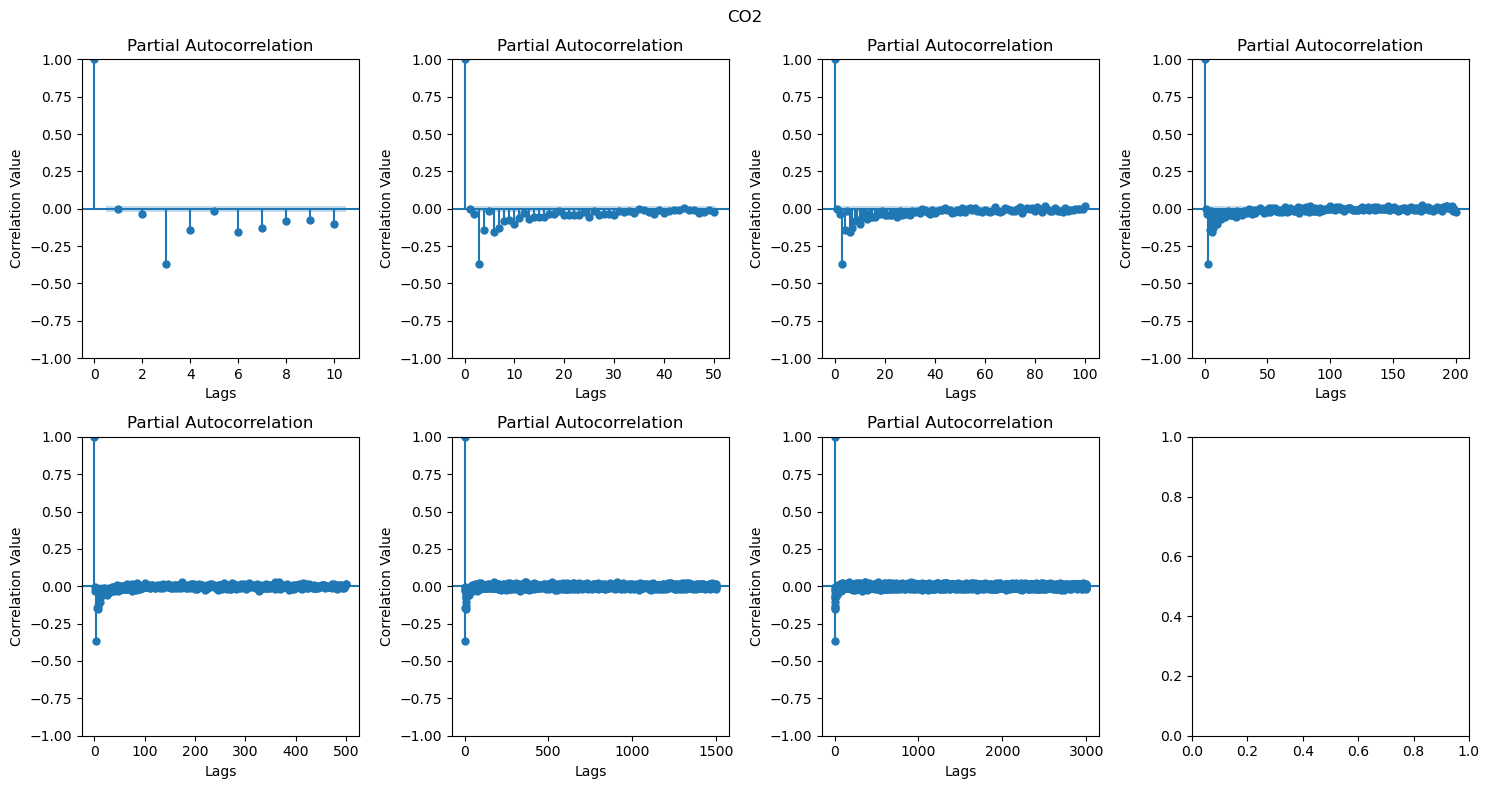

In [11]:
for i, feature in enumerate(data_resample_30s):
    lags = [10, 50, 100, 200, 500, 1500, 3000]

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    fig.suptitle(feature)
    for j, l in enumerate(lags):
        plot_pacf(data_resample_30s[feature], lags=l, ax=ax[j//4, j%4])
        ax[j//4, j%4].set_xlabel("Lags")
        ax[j//4, j%4].set_ylabel("Correlation Value")
    plt.tight_layout()

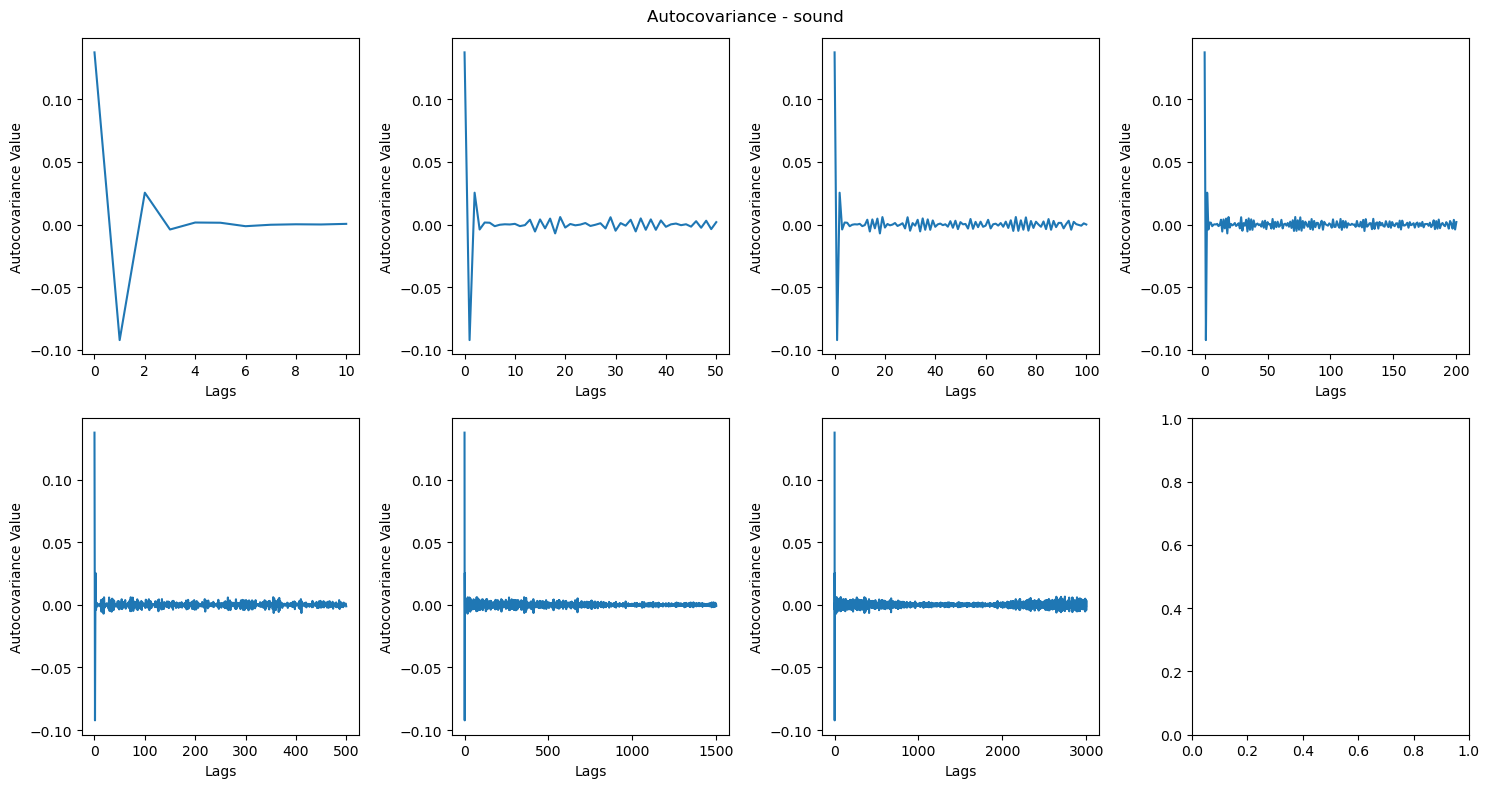

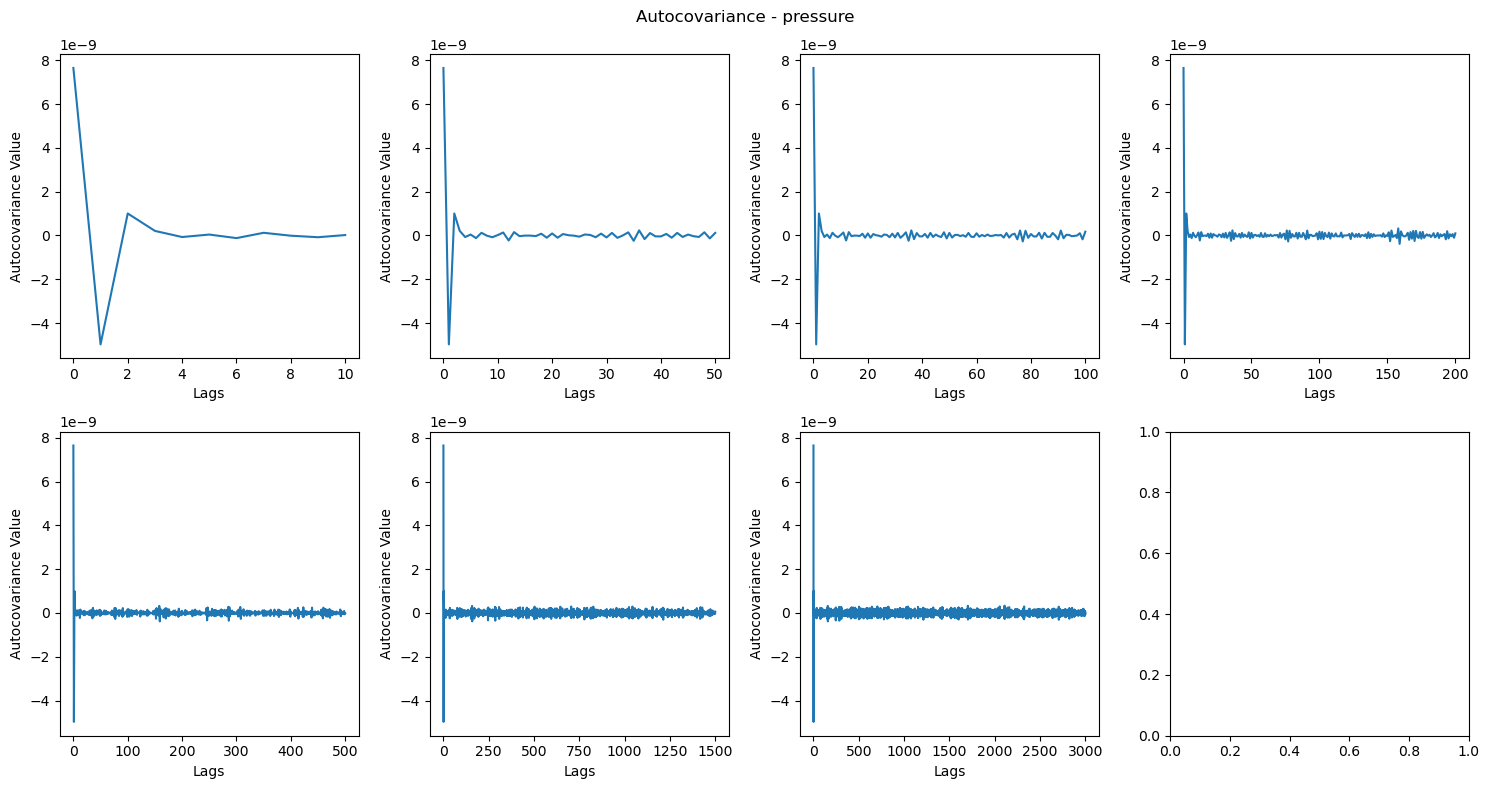

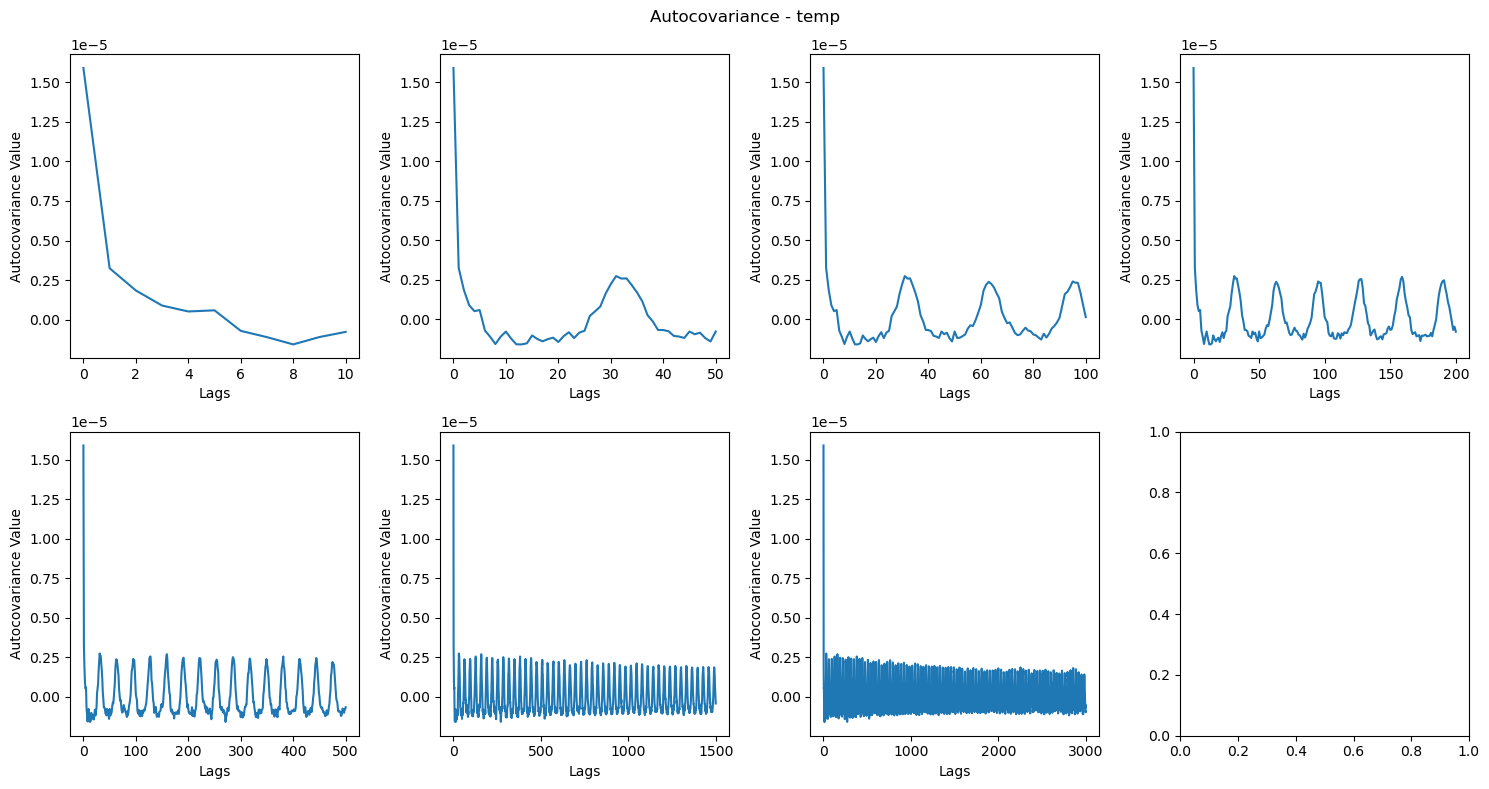

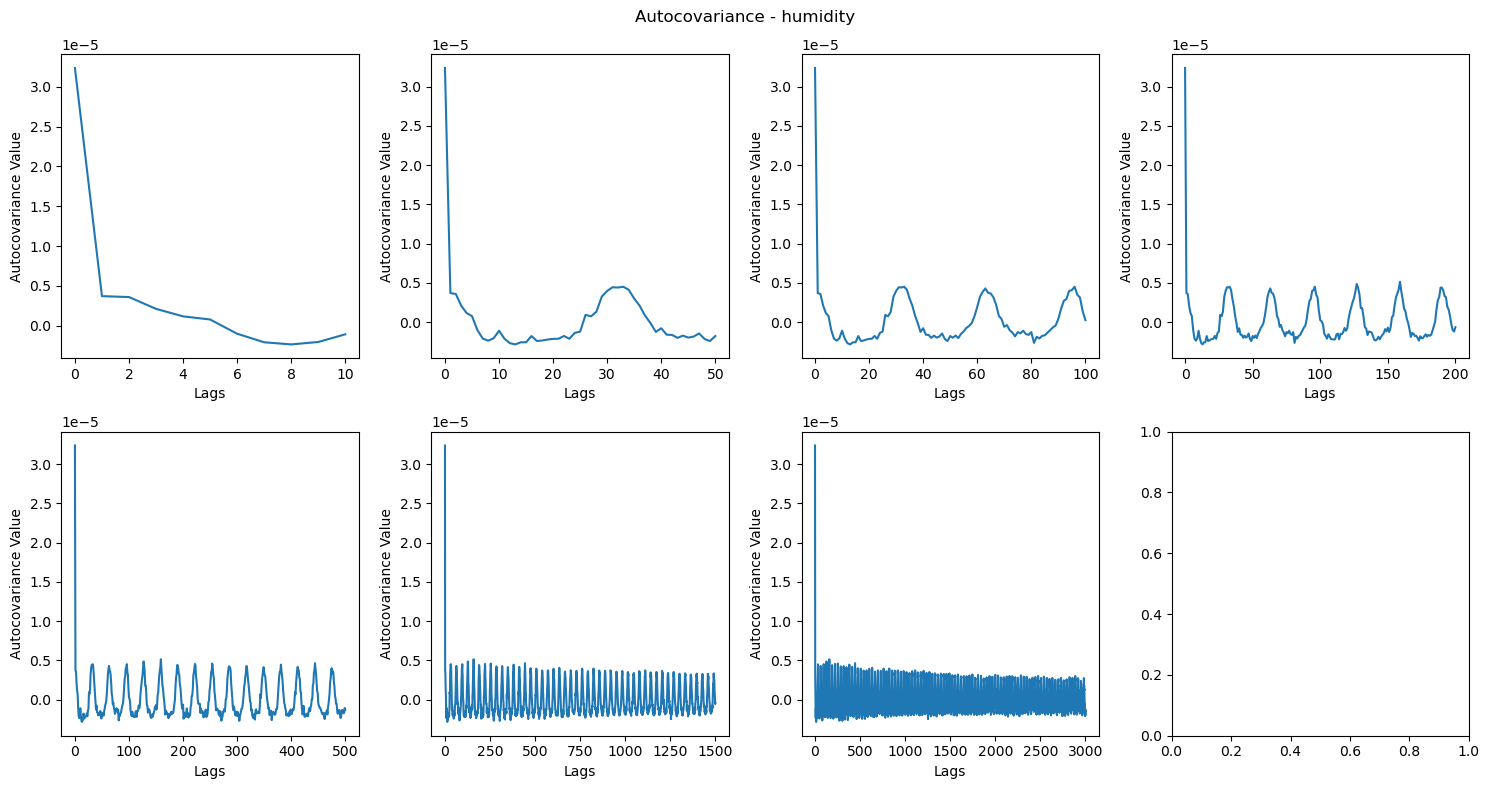

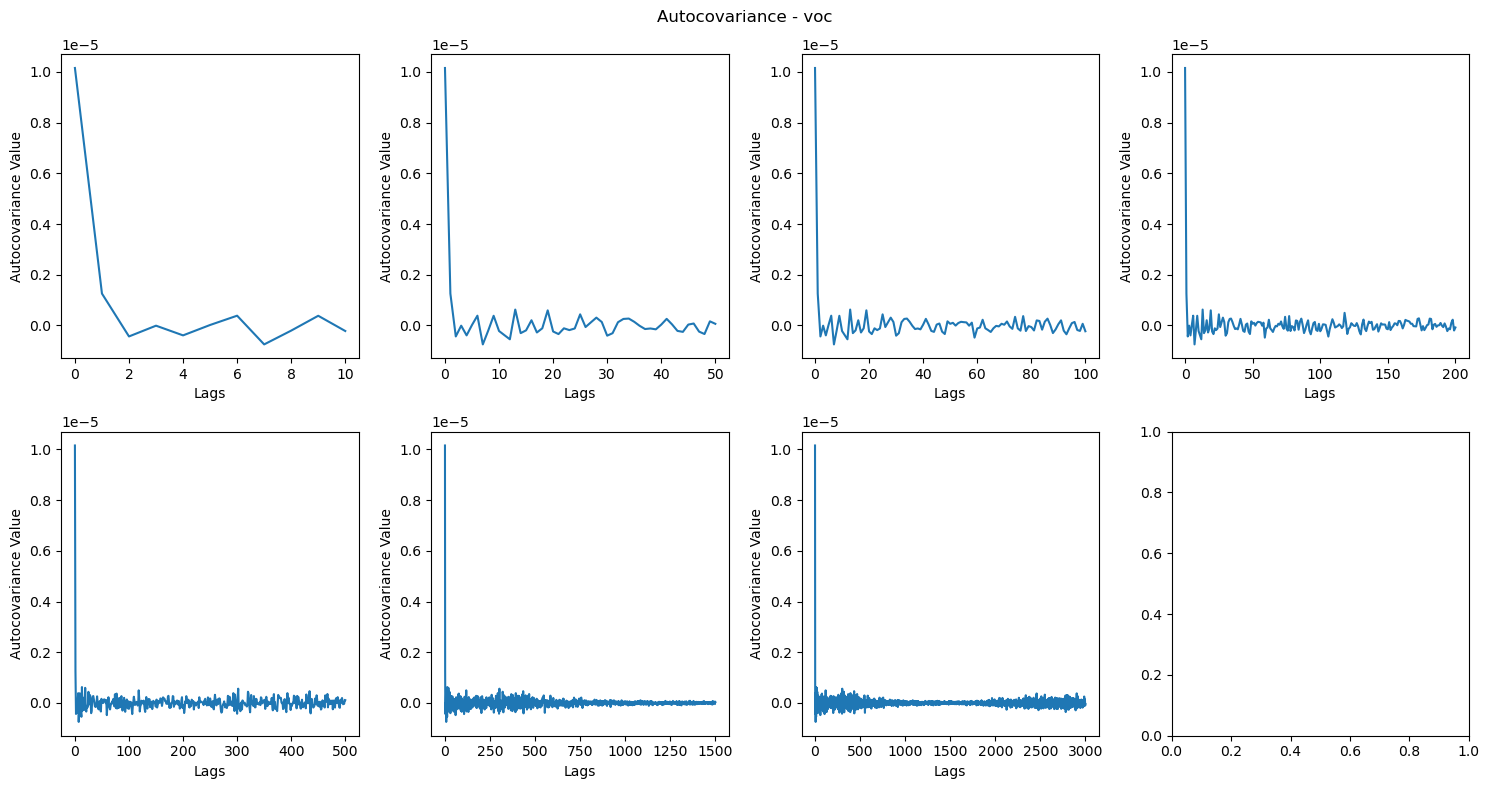

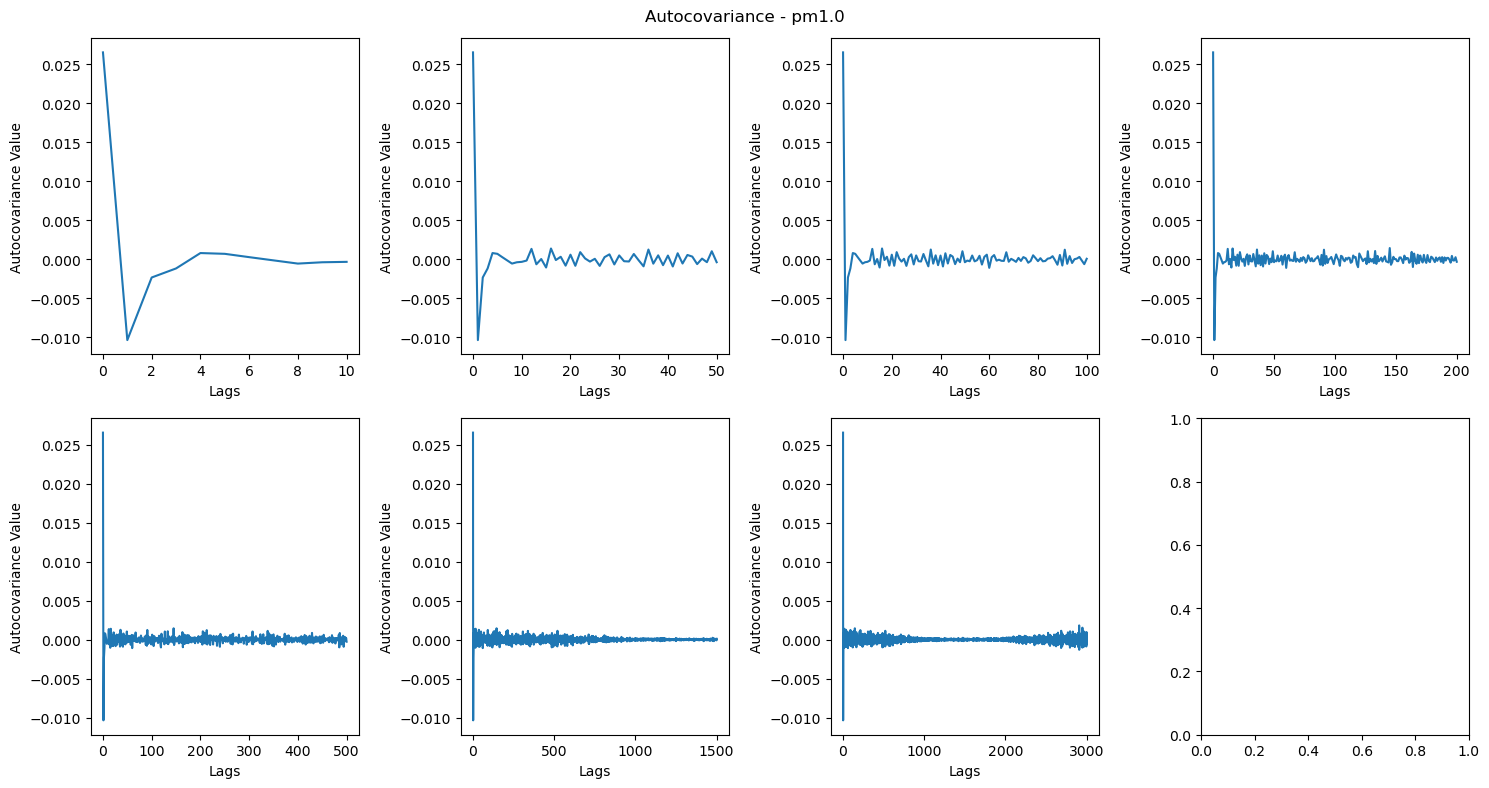

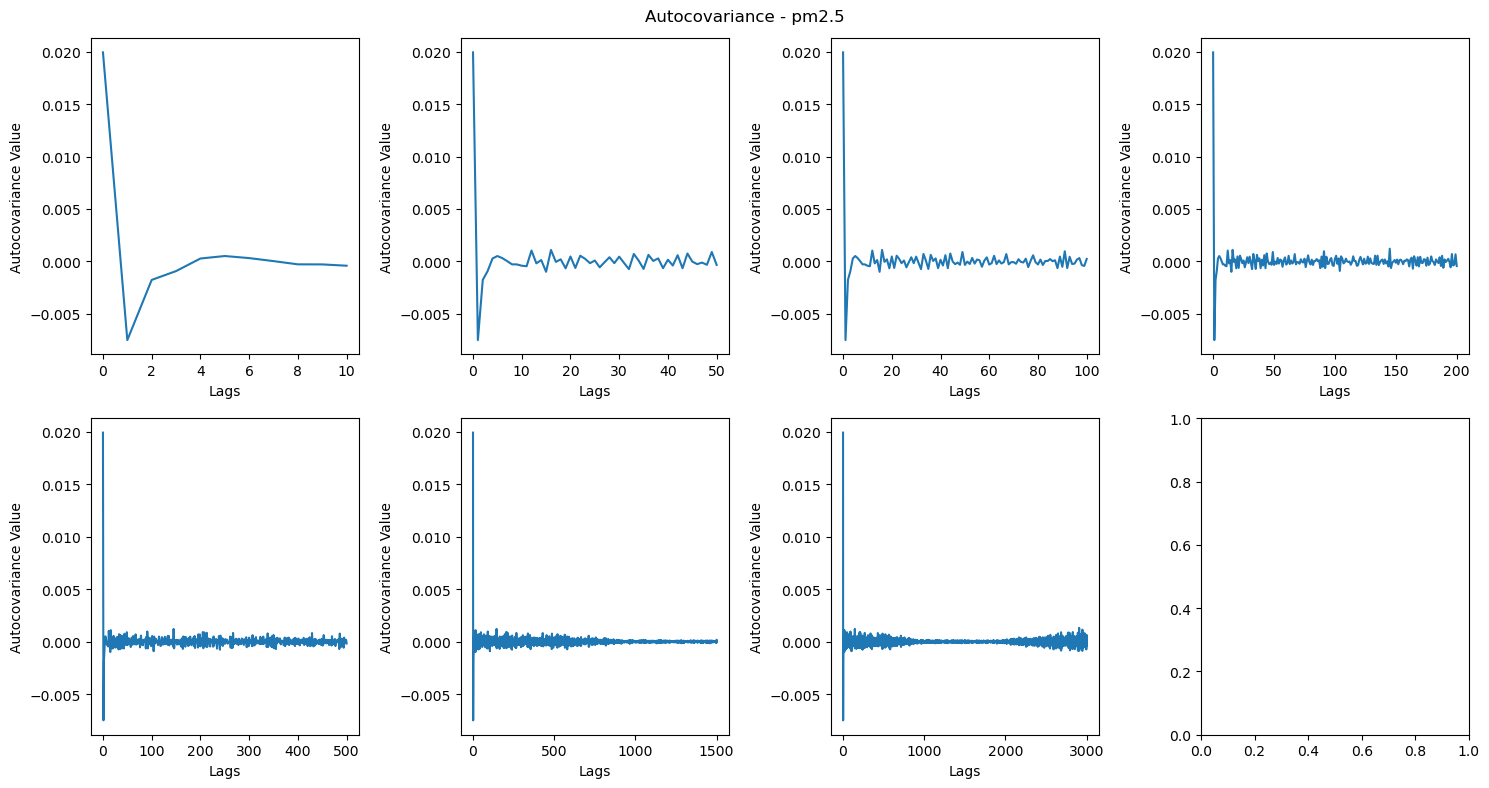

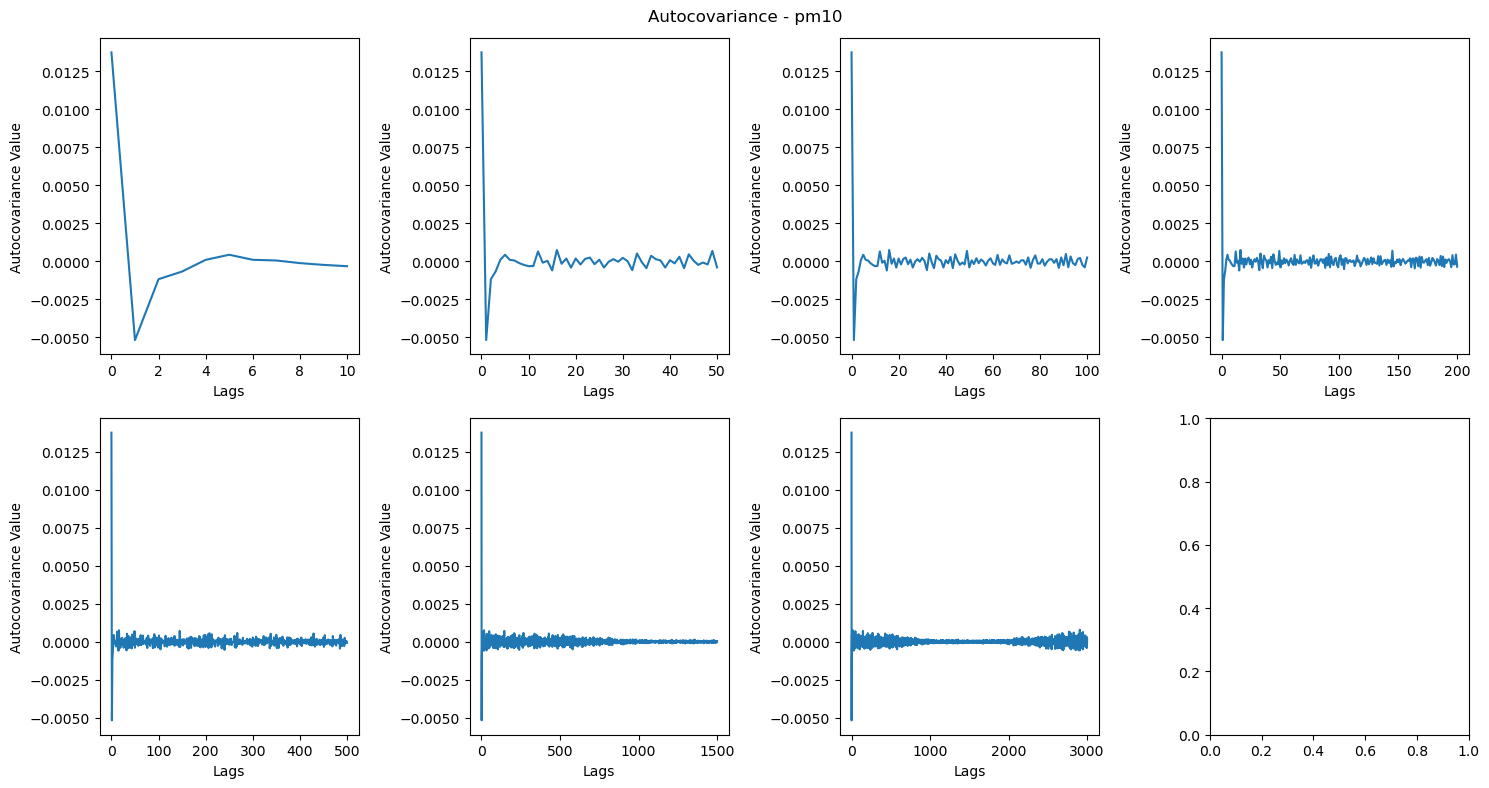

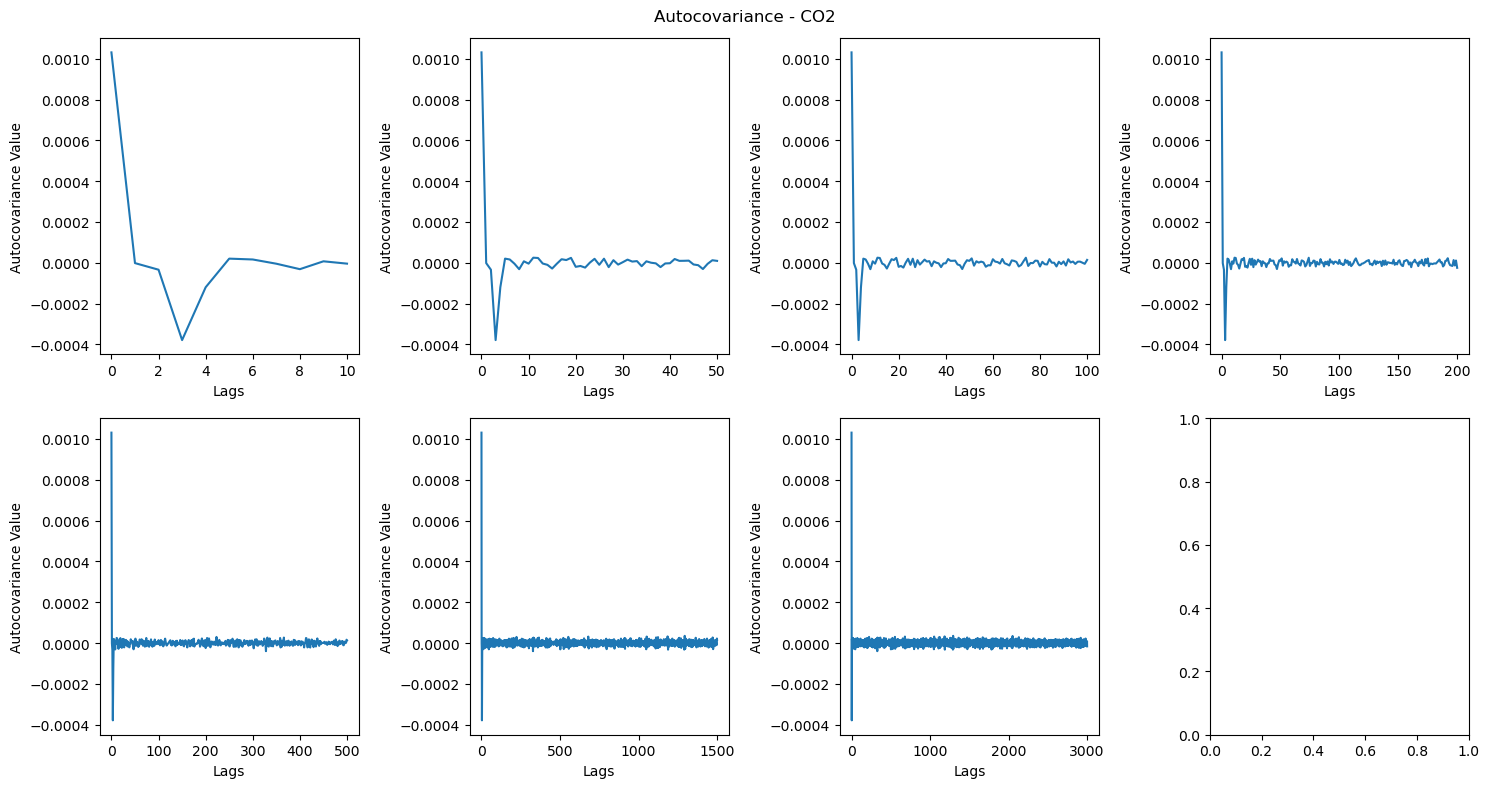

In [10]:
for i, feature in enumerate(data_resample_30s):
    lags = [10, 50, 100, 200, 500, 1500, 3000]
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    fig.suptitle("Autocovariance - " + feature)
    for j, l in enumerate(lags):
        res = acovf(data_resample_30s[feature], nlag=l)
        ax[j//4, j%4].plot(res)
        ax[j//4, j%4].set_xlabel("Lags")
        ax[j//4, j%4].set_ylabel("Autocovariance Value")
    plt.tight_layout()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
# # Split the data into training and testing sets
# train_size = int(0.8 * len(data_resample_30s))
# train_data = data_resample_30s[:train_size]
# test_data = data_resample_30s[train_size:]
 
# # Define the input features (lag features) and target variable
 
# y_train = train_data['humidity']
 
# y_test = test_data['humidity']

In [80]:
# # Create and train the autoregressive model
# lag_order = 3000 # Adjust this based on the ACF plot
# ar_model = AutoReg(y_train, lags=lag_order)
# ar_results = ar_model.fit()

In [81]:
# y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
# #print(y_pred)
 
# # Calculate MAE and RMSE
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'Mean Absolute Error: {mae:.5f}')
# print(f'Root Mean Squared Error: {rmse:.5f}')

Mean Absolute Error: 0.00147
Root Mean Squared Error: 0.00190


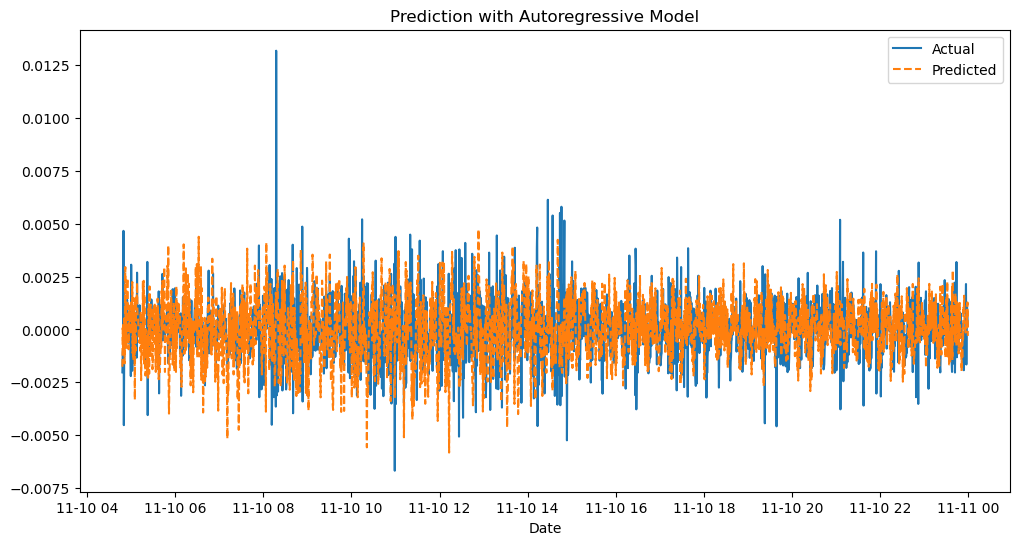

In [82]:
# plt.figure(figsize=(12, 6))
# plt.plot(test_data.index ,y_test, label='Actual')
# plt.plot( test_data.index,y_pred, label='Predicted', linestyle='--')
# plt.xlabel('Date')
# plt.ylabel('')
# plt.legend()
# plt.title('Prediction with Autoregressive Model')
# plt.show()

In [83]:
# from statsmodels.tsa.arima.model import ARIMA

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:               345599
Model:                 ARIMA(5, 1, 0)   Log Likelihood              388213.756
Date:                Wed, 10 Apr 2024   AIC                        -776415.512
Time:                        14:33:25   BIC                        -776350.993
Sample:                    11-07-2022   HQIC                       -776396.962
                         - 11-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6662      0.001   -742.335      0.000      -0.668      -0.664
ar.L2         -0.4467      0.001   -313.365      0.000      -0.450      -0.444
ar.L3         -0.2793      0.002   -158.704      0.0

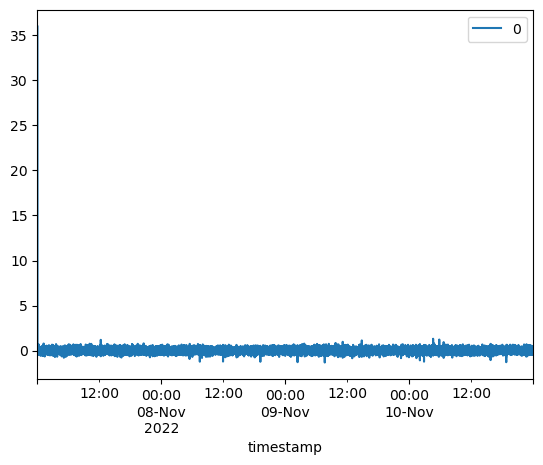

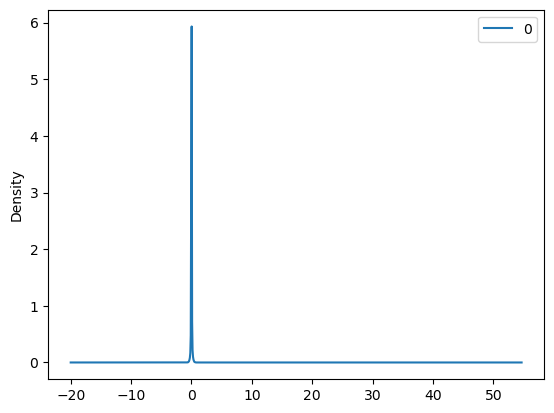

                   0
count  345599.000000
mean        0.000089
std         0.099706
min        -1.334919
25%        -0.023656
50%        -0.000664
75%         0.022691
max        35.996349


In [84]:
# # fit model
# model = ARIMA(data['humidity'], order=(5,1,0))
# model_fit = model.fit()
# # summary of fit model
# print(model_fit.summary())
# # line plot of residuals
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# plt.show()
# # summary stats of residuals
# print(residuals.describe())

In [86]:
# X = data_resample_30s['humidity']
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
#  model = ARIMA(history, order=(5,1,0))
#  model_fit = model.fit()
#  output = model_fit.forecast()
#  yhat = output[0]
#  predictions.append(yhat)
#  obs = test[t]
#  history.append(obs)
#  print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = np.sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.000237, expected=-0.000605
predicted=-0.000001, expected=0.003047


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.001227, expected=-0.000961


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.000607, expected=-0.000248


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.000298, expected=-0.003668
predicted=-0.000779, expected=0.001942
predicted=0.000070, expected=0.002172
predicted=0.000669, expected=0.001843


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.000704, expected=0.003505
predicted=0.001386, expected=-0.001278
predicted=0.000739, expected=0.000413
predicted=0.001077, expected=-0.001107


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.000463, expected=0.001546


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=0.000846, expected=-0.002788


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=-0.000451, expected=-0.003890
predicted=-0.001704, expected=-0.004682
predicted=-0.002514, expected=0.000621
predicted=-0.001509, expected=0.002664
predicted=-0.000420, expected=0.000714


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=-0.000549, expected=0.001236
predicted=-0.000122, expected=-0.002681


c:\Users\Dositej 14\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=-0.000538, expected=0.002792


KeyboardInterrupt: 